In [1]:
import numpy as np
from IPython.display import clear_output
import torch
import random
import matplotlib.pyplot as plt
from collections import deque
import itertools
from grid_env import Qmaze
%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
from agent import Agent

class DQNAgent(Agent):
    def calculate_target(self, new_obses_t, rews_t, dones_t, var):
        target_qvalues = self.target_net(new_obses_t)
        self.target_qvalues = target_qvalues

        max_val = target_qvalues.max().item() * var

        ### Method 1
        # means = target_qvalues.mean(axis=1).view(BATCH_SIZE, 1)
        # bias_vals = means - target_qvalues
        # for i in range(4):
        #   noise = torch.tensor(np.random.multivariate_normal(bias_vals[:, i].detach().cpu().numpy(), max_val * np.identity(BATCH_SIZE))).to(device)
        #   target_qvalues[:, i] += noise
        # max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 2
        # noise = torch.from_numpy(np.random.normal(0, 10 * var, target_qvalues.size())).to(device)
        # noisy_target_qvalues = target_qvalues + noise
        # max_target_qvalues = noisy_target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 3
        max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]
        noise = torch.from_numpy(np.random.normal(0, 10 * var, max_target_qvalues.size())).to(device)
        max_target_qvalues += noise

        if self.counter % 1000 == 0:
          print(self.online_net(new_obses_t)[0,:])
          for g in self.optimizer.param_groups:
            g['lr'] *= 0.85
            lr = g['lr']
            print(f"learning rate: {lr}")

        self.targets = rews_t + self.gamma * (1 - dones_t) * max_target_qvalues


In [9]:
GAMMA = 0.9
BATCH_SIZE = 32
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 0.0001
EPSILON_END = 0.0001
EPSILON_DECAY = 5000
TARGET_UPDATE_FREQ = 200

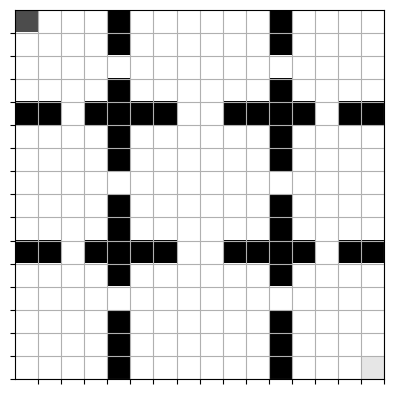

In [10]:
maze = [
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
]
env = Qmaze(maze)
Qmaze.show(env)

trained 0.1-500 0 times - ep num = 0
tensor([-14705.0908,  11202.9775,     90.3810,  11401.5322],
       grad_fn=<SliceBackward0>)
learning rate: 0.425
tensor([9202.8213, 8655.8623, 9297.0537, 8938.3037], grad_fn=<SliceBackward0>)
learning rate: 0.36124999999999996
tensor([5454.5815, 5413.1211, 5415.3652, 5394.0601], grad_fn=<SliceBackward0>)
learning rate: 0.30706249999999996
tensor([3039.2529, 3056.7744, 3077.3066, 3033.0374], grad_fn=<SliceBackward0>)
learning rate: 0.26100312499999995
tensor([-1495.2031,   335.9118,  2362.3396,  4159.7339],
       grad_fn=<SliceBackward0>)
learning rate: 0.22185265624999995


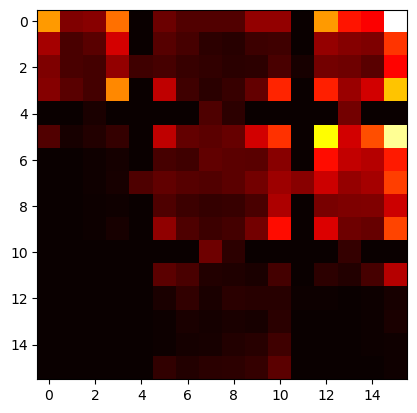

trained 0.1-500 0 times - ep num = 2


KeyboardInterrupt: 

In [11]:
for sigma in [0.1, 0.5, 1]:
  for rate in [500, 1000, 5000]:
    avg_returns = []
    episodes = []
    current_coverage = []
    coverage_steps = [5000, 10000, 15000, 50000]
    prefix = f"{sigma}_{rate}_"

    # Noise defined
    for k in range(3):
        torch.cuda.empty_cache()
        current_return = []

        replay_buffer = deque(maxlen=BUFFER_SIZE)
        rew_buffer = []
        temp_episodes = []

        rat_cell = (0, 0)
        env = Qmaze(maze)
        env.reset(rat_cell)
        obs = env.observe()

        agent = DQNAgent(env, EPSILON_START, EPSILON_END, EPSILON_DECAY, GAMMA, 0.5)
        cnt = 0
        coverage_counter = 0
        episode = 0
        for step in itertools.count():
            agent.counter += 1
            action = agent.choose_action(step, obs)

            new_obs, rew, done = env.act(action)
            Transition = (obs, action, rew, done, new_obs)
            replay_buffer.append(Transition)
            obs = new_obs

            if done != 'not_over':
                rat_cell = (0,0)
                env.reset(rat_cell)
                obs = env.observe()
                rew_buffer.append(GAMMA**(cnt))
                episode += 1
                cnt = 0

            if len(replay_buffer) > BATCH_SIZE:
                transitions = random.sample(replay_buffer, BATCH_SIZE)
                obses = np.asarray([t[0] for t in transitions])
                actions = np.asarray([t[1] for t in transitions])
                rews = np.asarray([t[2] for t in transitions])
                dones = np.asarray([t[3] for t in transitions])
                new_obses = np.asarray([t[4] for t in transitions])

                converted_dones = [done != 'not_over' for done in dones]

                obses_t = torch.as_tensor(obses, dtype=torch.float32).to(device)
                actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1).to(device)
                rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1).to(device)
                dones_t = torch.as_tensor(converted_dones, dtype=torch.float32).unsqueeze(-1).to(device)
                new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32).to(device)

                # Calculate noise
                var = sigma / np.ceil (agent.counter / rate)

                agent.calculate_target(new_obses_t, rews_t, dones_t, var)
                agent.calculate_action_qvalues(obses_t, actions_t)
                agent.optimize_network()

            if step % TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()

            if step in coverage_steps:
                if k == 0:
                    current_coverage.append(np.copy(env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])))
                else:
                    current_coverage[coverage_counter] = np.concatenate(
                        [current_coverage[coverage_counter], env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])], axis=0)

                coverage_counter += 1

                plt.imshow(env.coverage, cmap='hot', interpolation='nearest')
                plt.show()

            if step > 55000:
                episodes.append(np.copy(temp_episodes))
                avg_returns.append(np.copy(rew_buffer))
                break
            cnt += 1

            if step % 5000 == 0:
                temp_episodes.append(episode)
                
                print(f"trained {sigma}-{rate} {k} times - ep num = {episode}")

    min_length = np.min([len(array) for array in avg_returns])
    np.save(prefix+"episodes.npy", np.mean(episodes, axis=0))
    np.save(prefix+"score.npy", np.mean([array[:min_length] for array in avg_returns], axis=0))
    for s in range(len(coverage_steps)):
        np.save(prefix+f"heat_{coverage_steps[s]}.npy", np.mean(current_coverage[s], axis=0))

In [34]:
plt.imshow(np.mean(current_coverage[1], axis=0)[0:][:], cmap='hot', interpolation='nearest')

IndexError: ignored

<ipython-input-174-4ba5ae3ef7bf>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: ignored

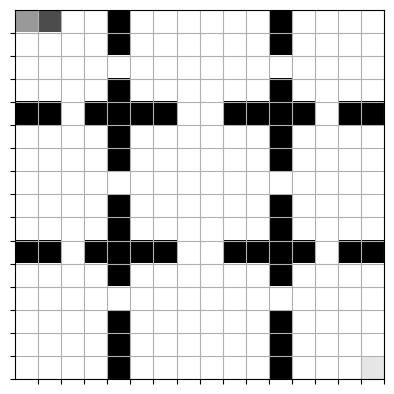

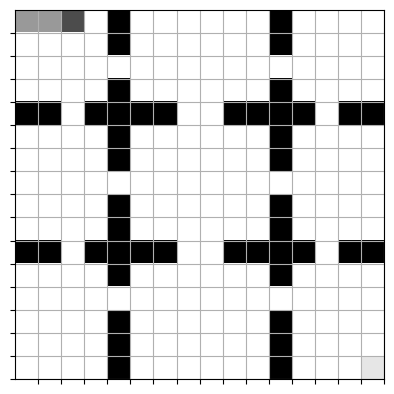

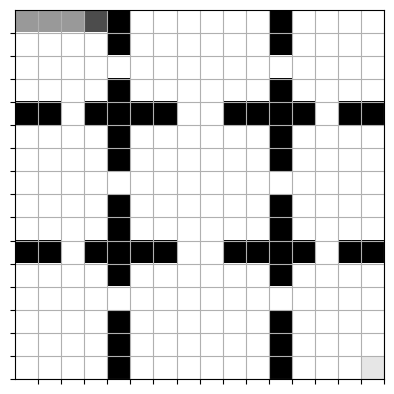

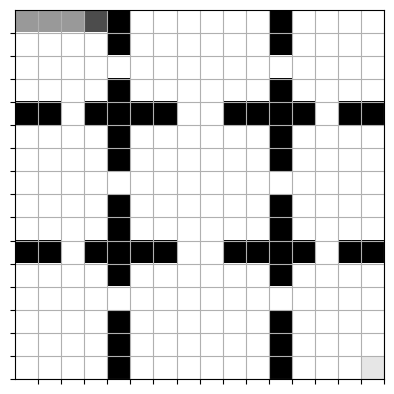

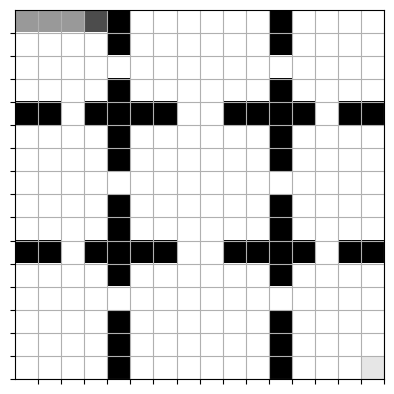

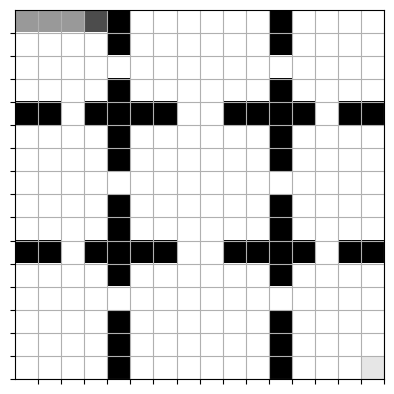

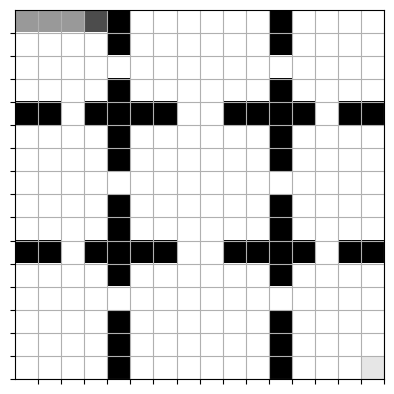

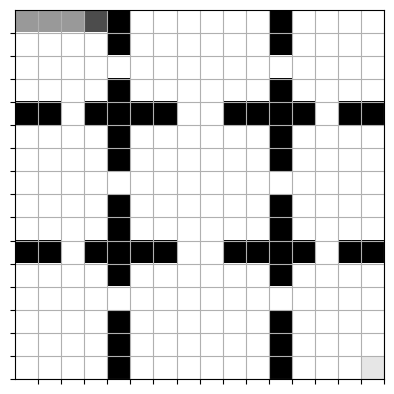

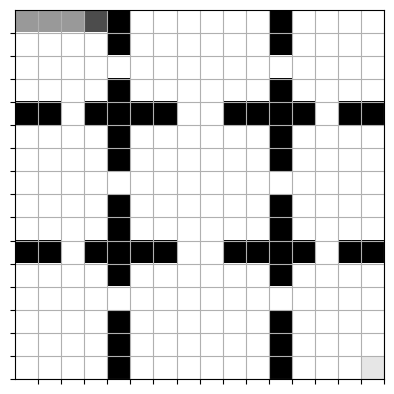

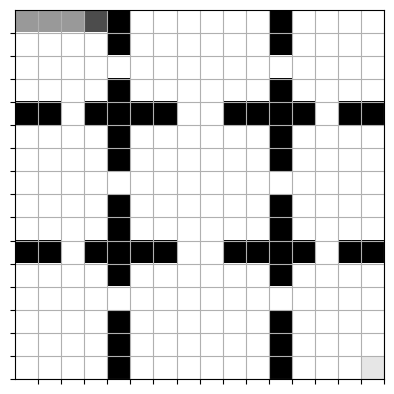

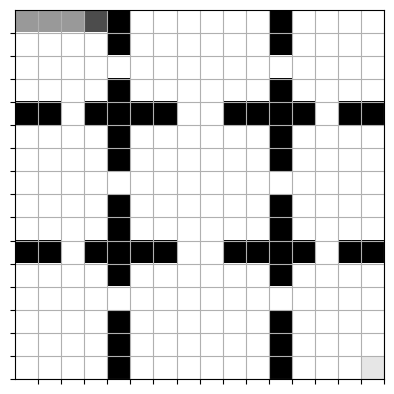

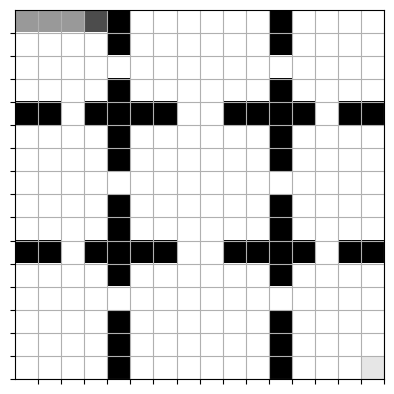

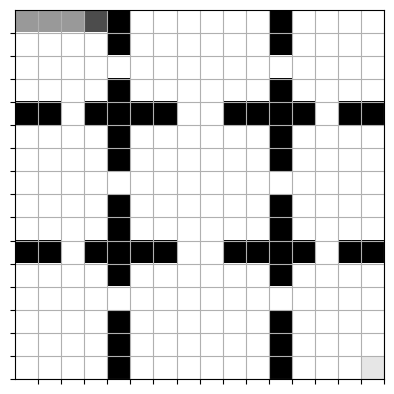

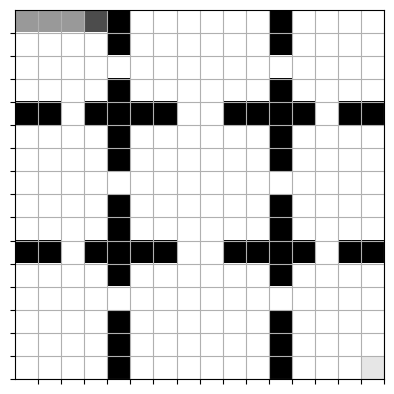

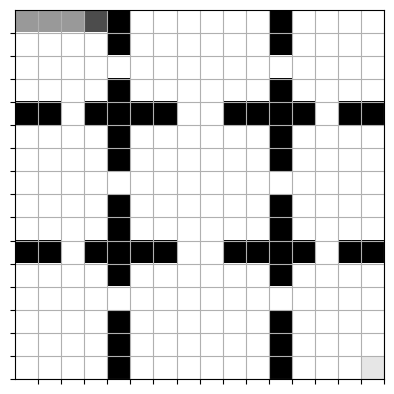

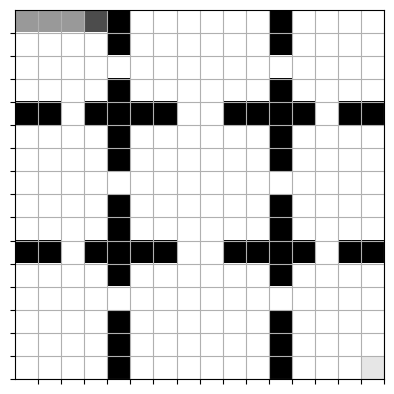

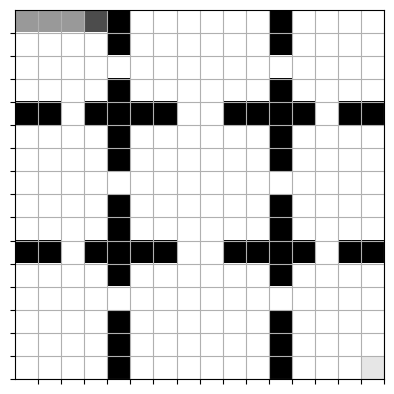

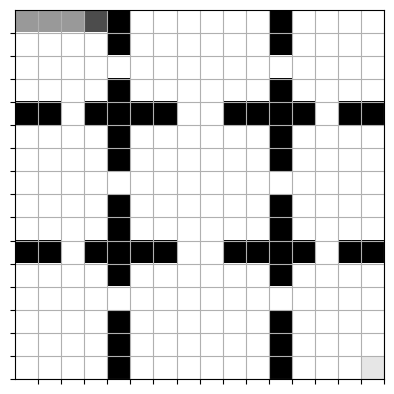

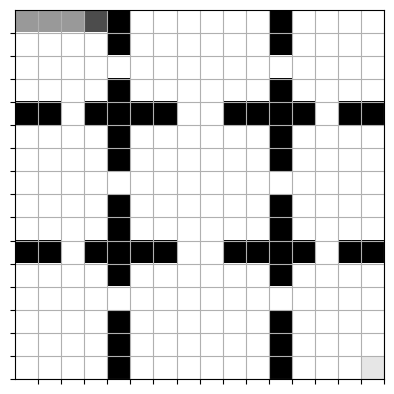

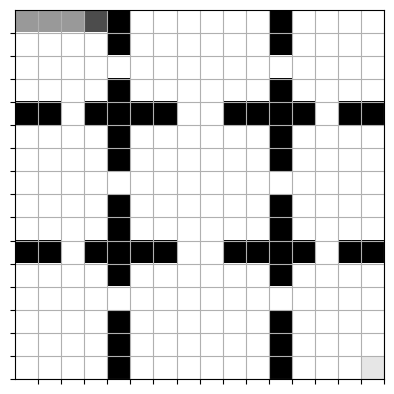

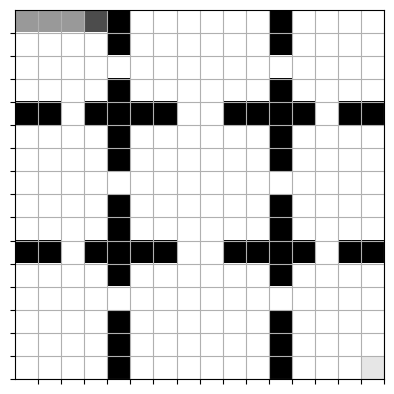

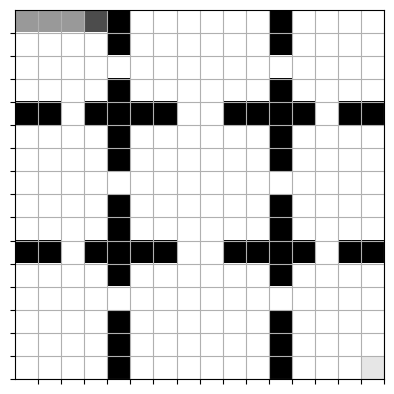

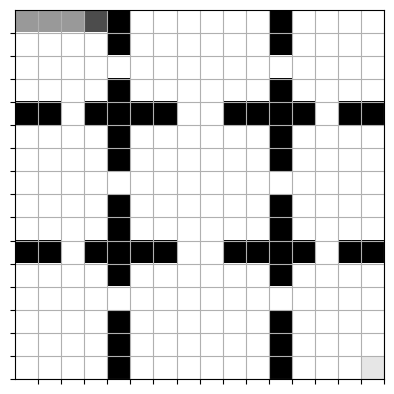

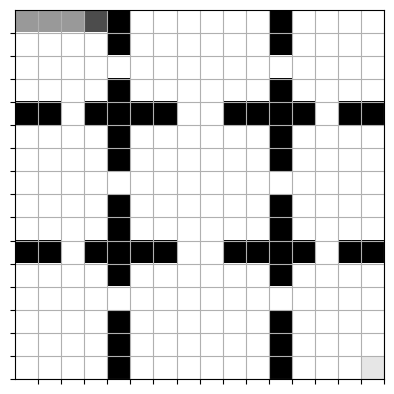

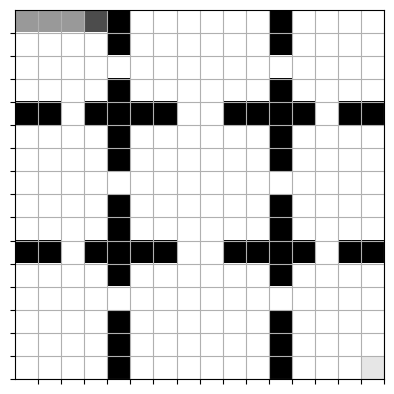

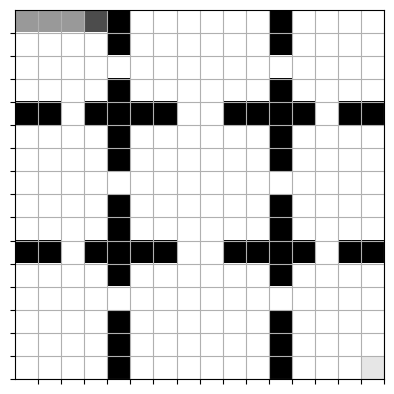

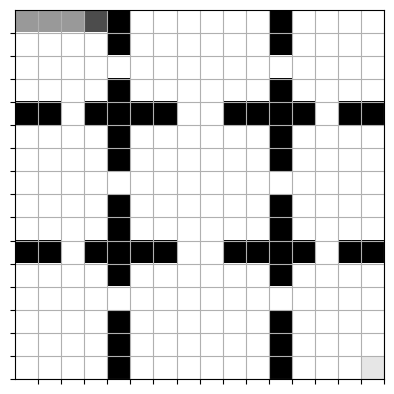

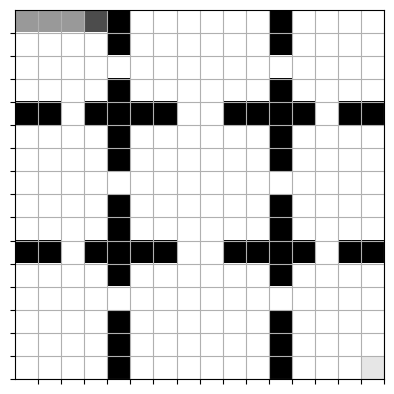

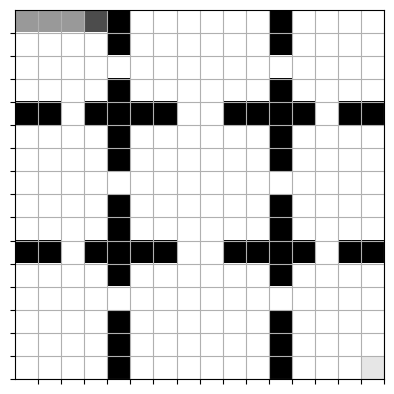

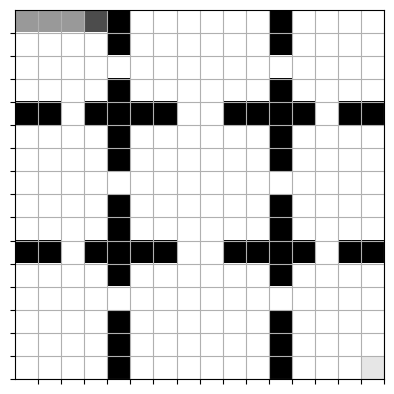

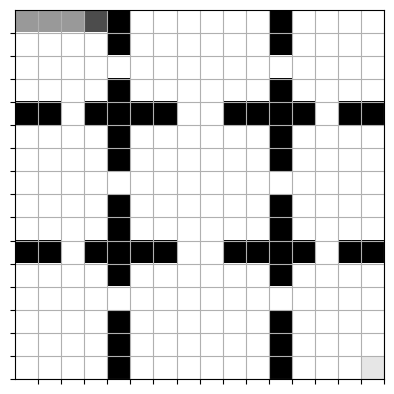

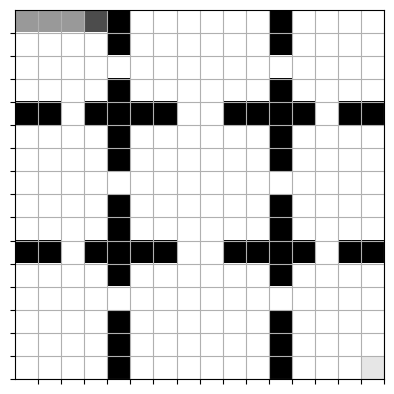

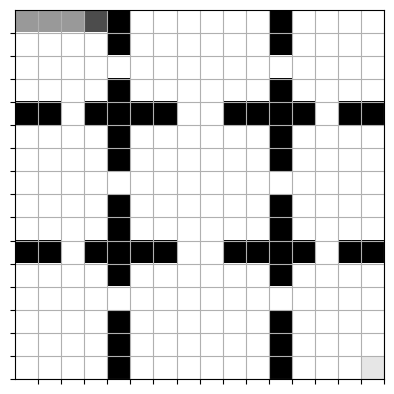

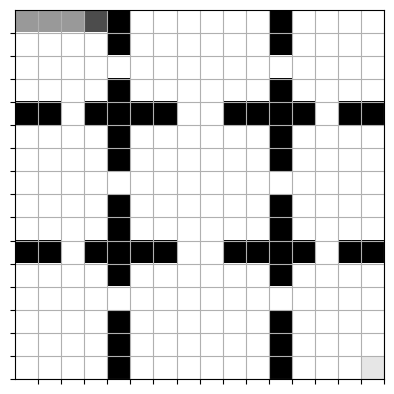

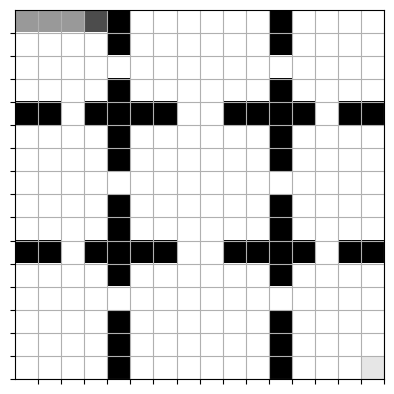

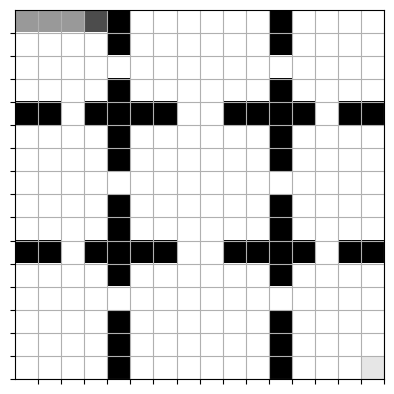

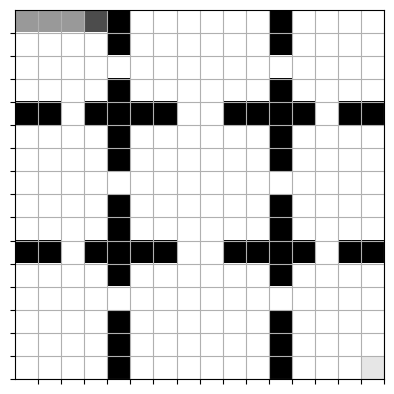

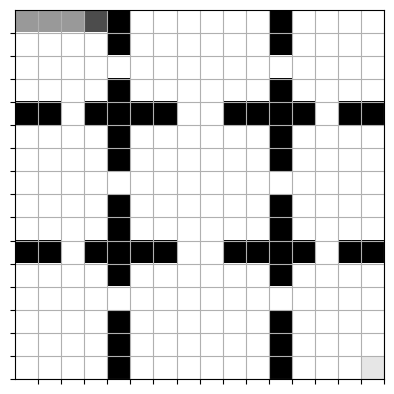

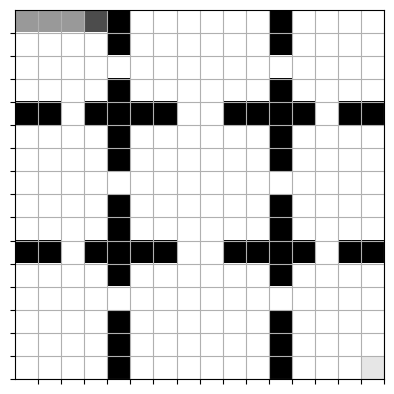

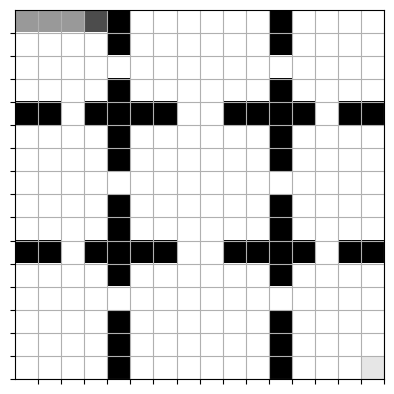

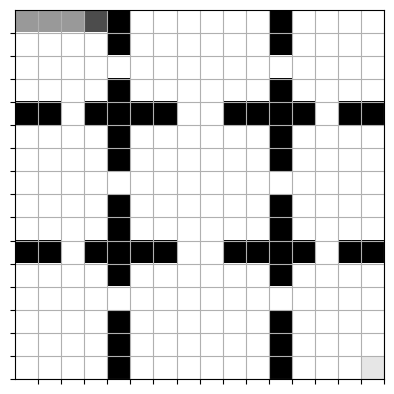

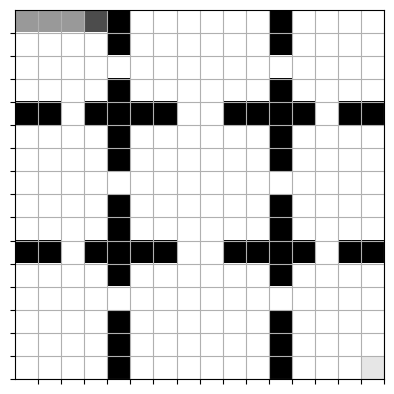

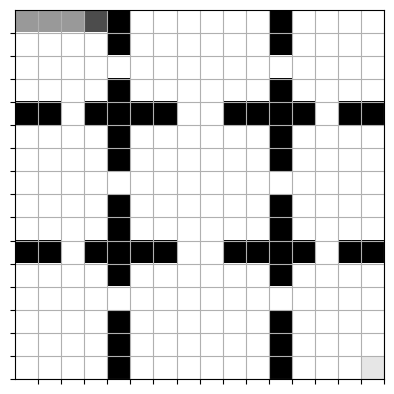

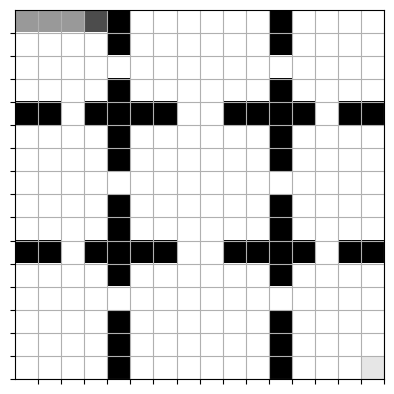

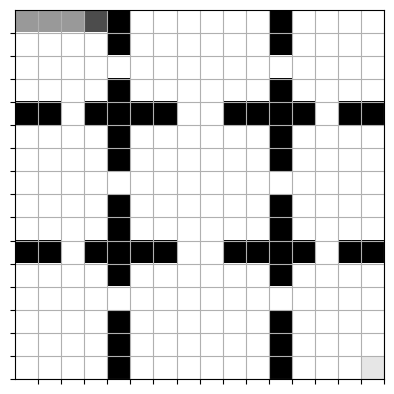

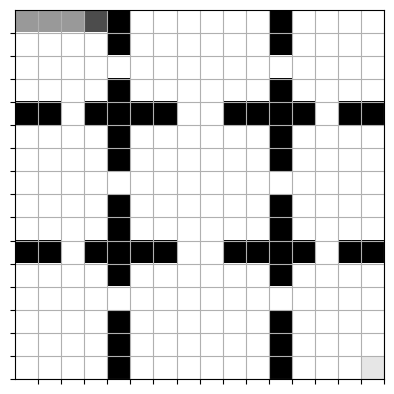

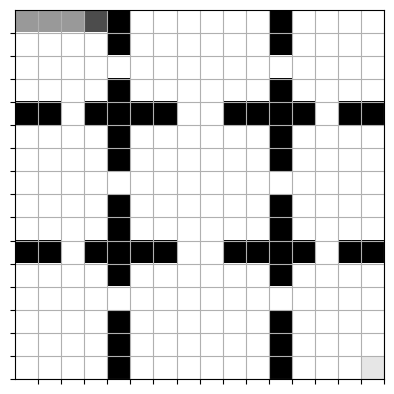

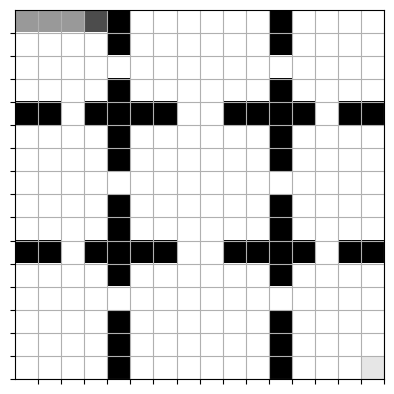

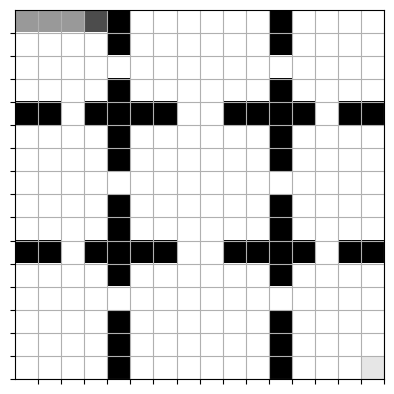

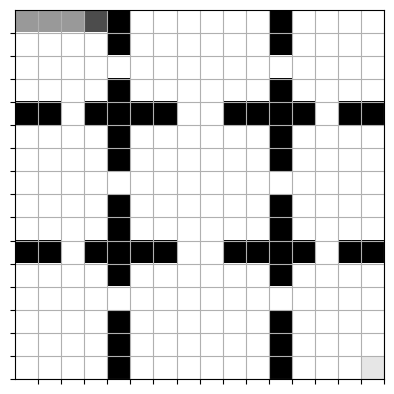

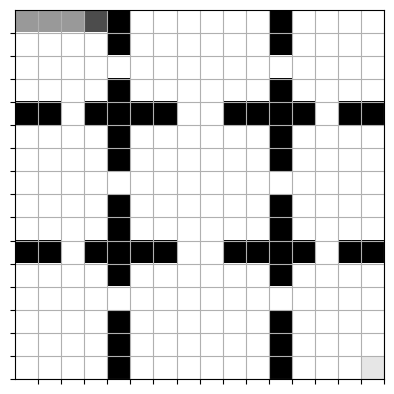

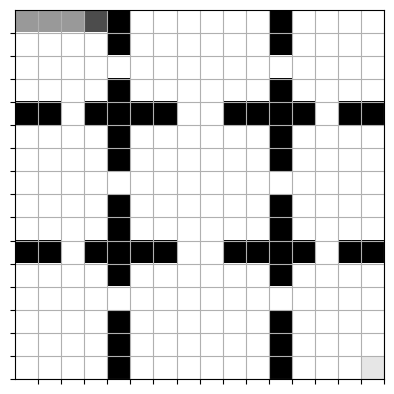

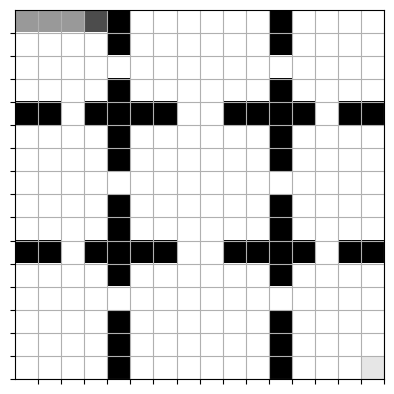

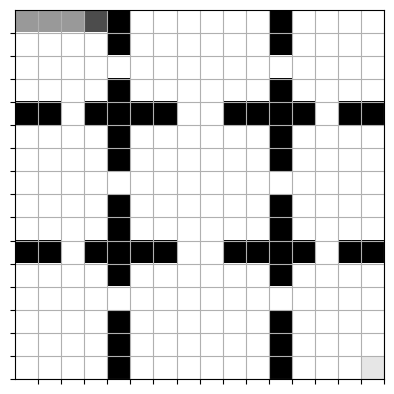

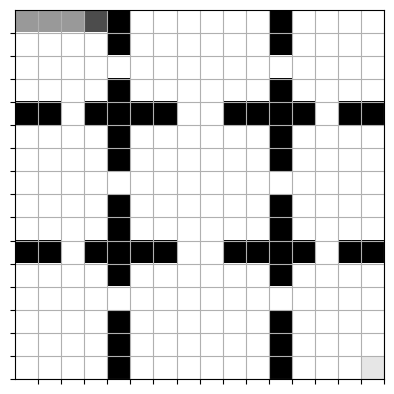

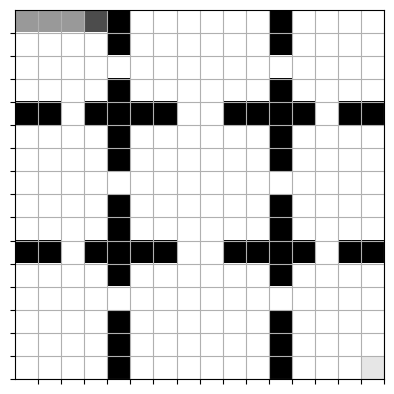

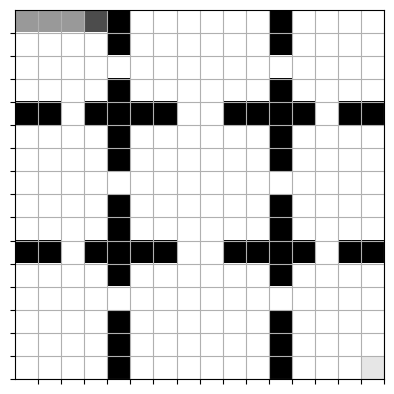

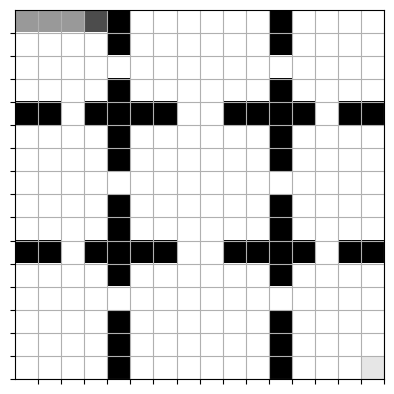

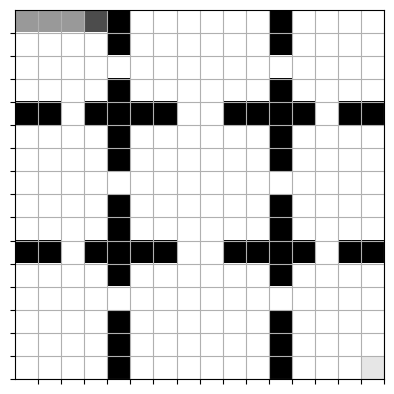

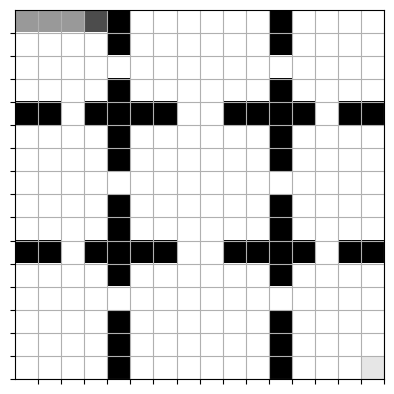

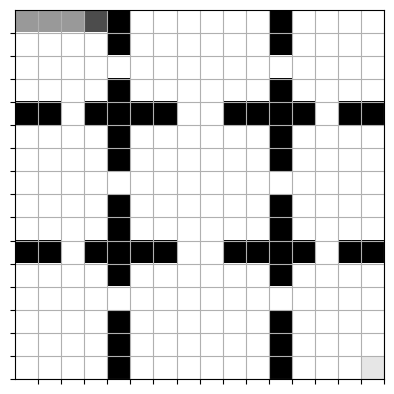

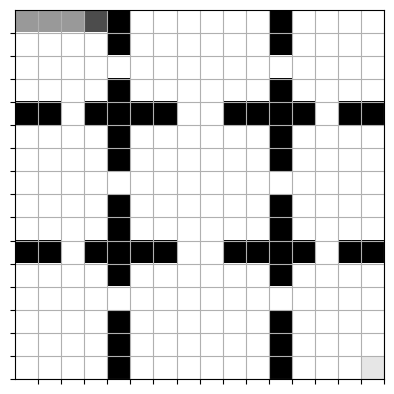

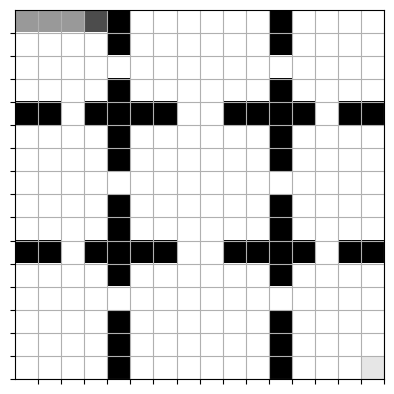

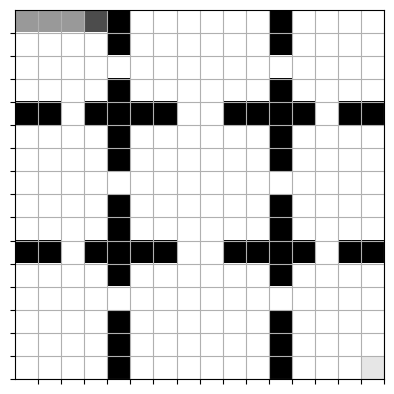

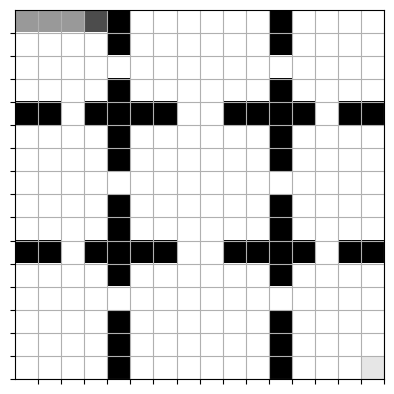

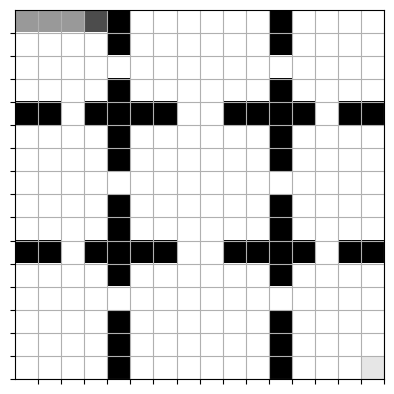

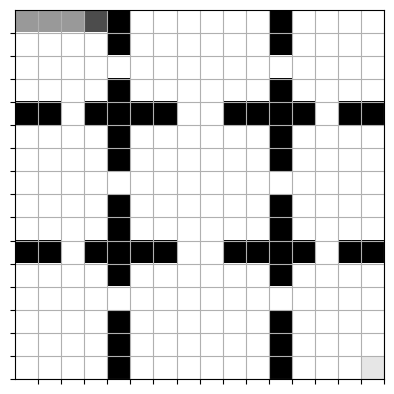

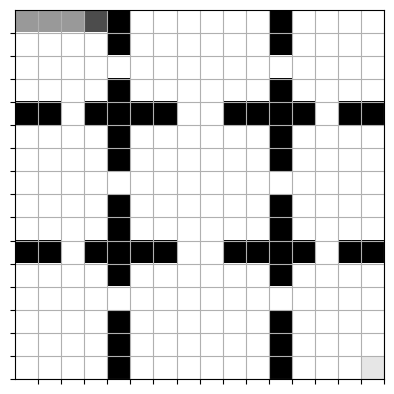

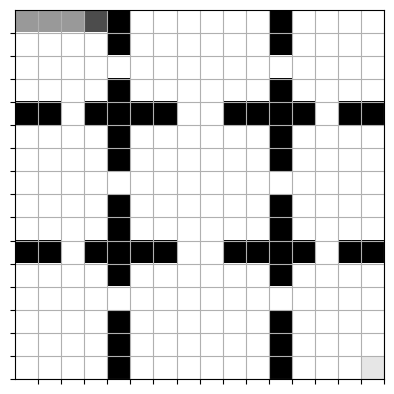

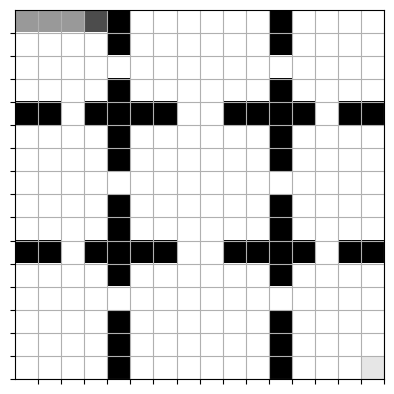

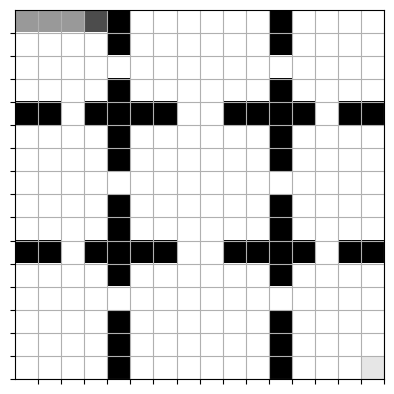

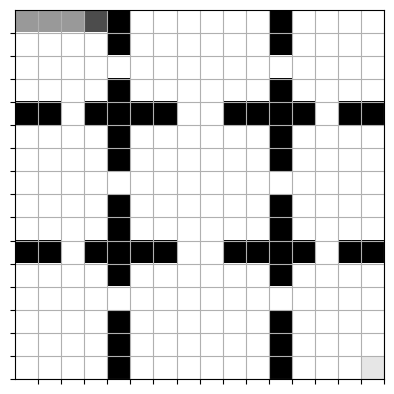

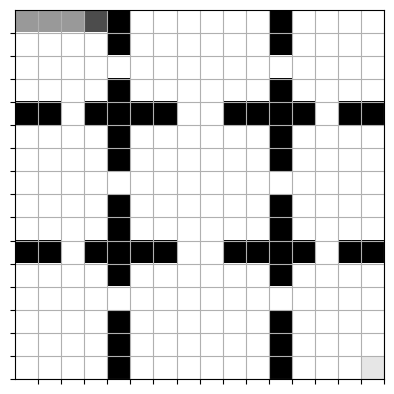

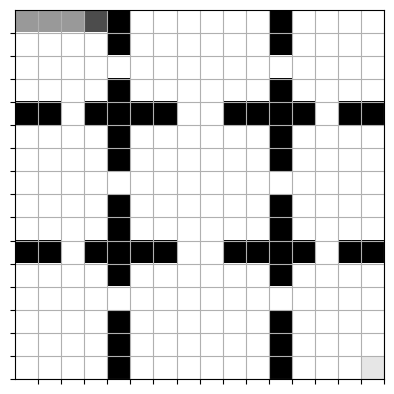

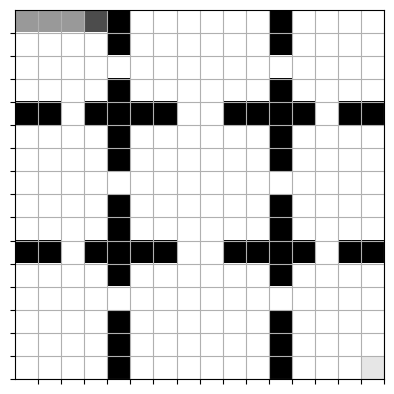

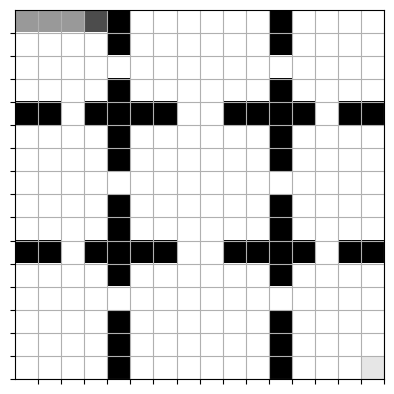

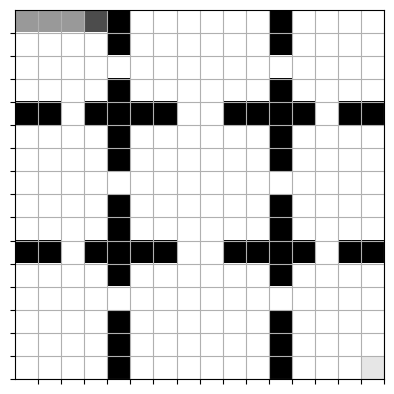

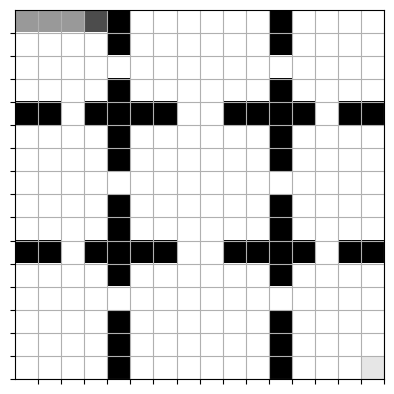

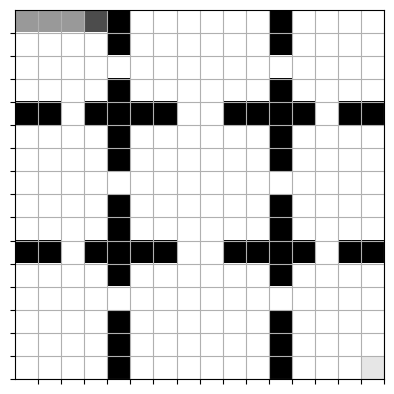

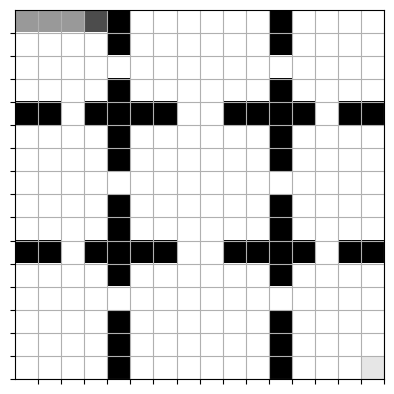

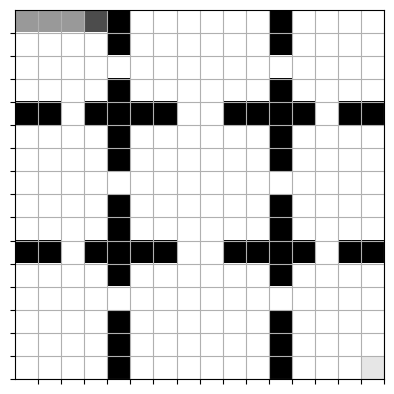

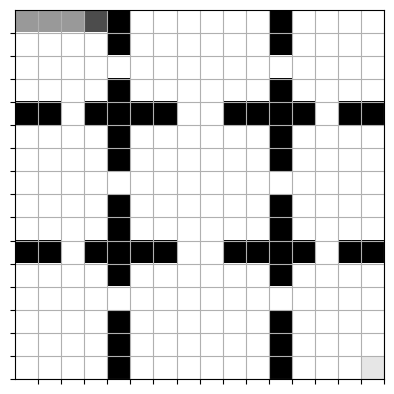

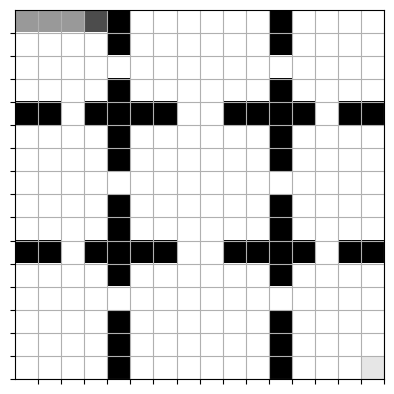

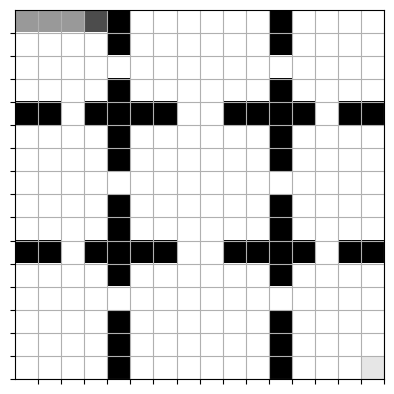

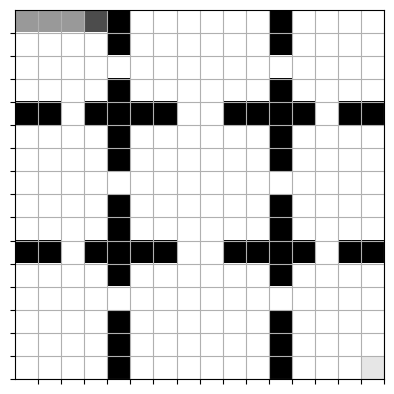

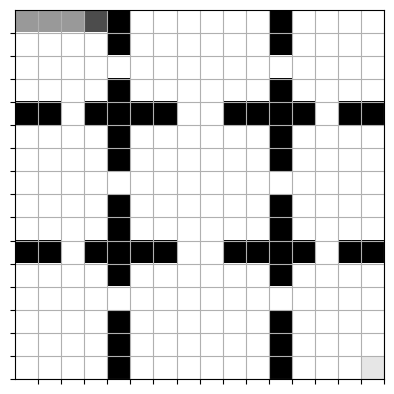

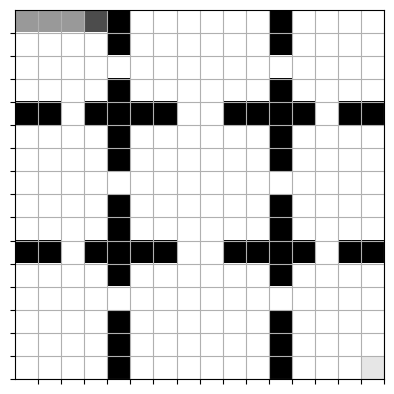

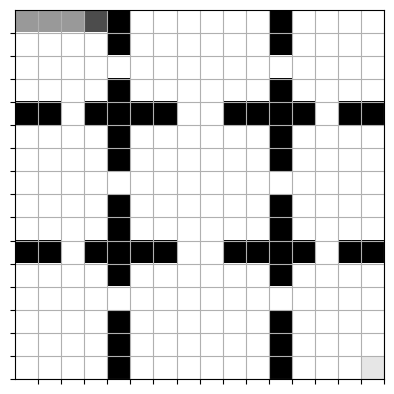

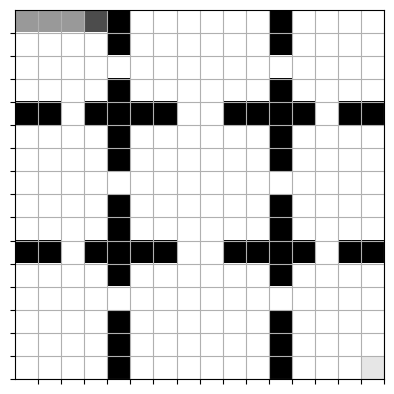

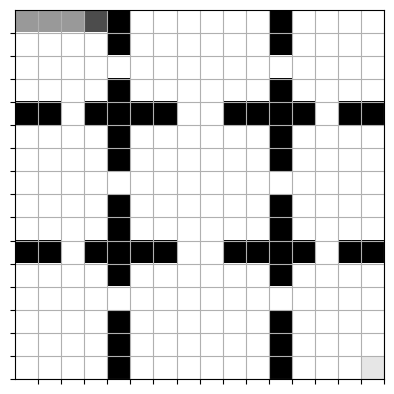

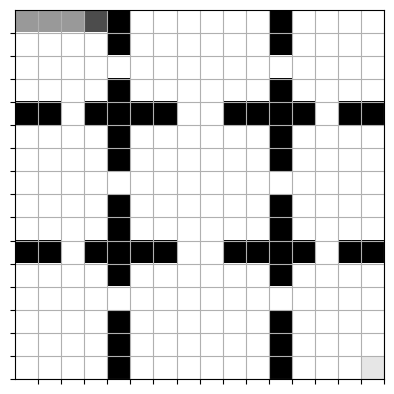

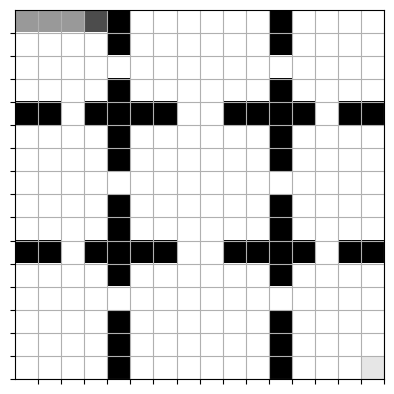

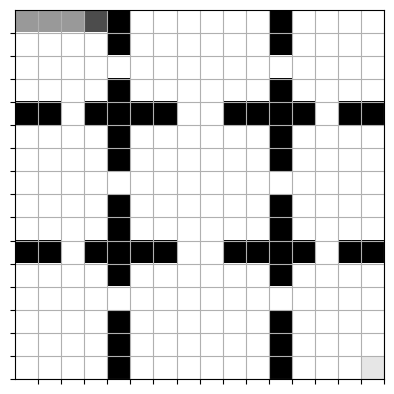

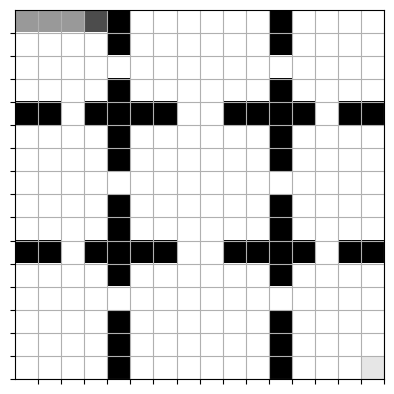

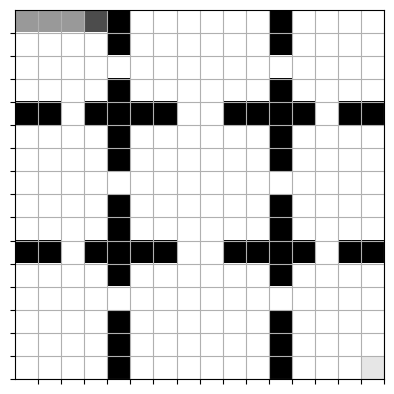

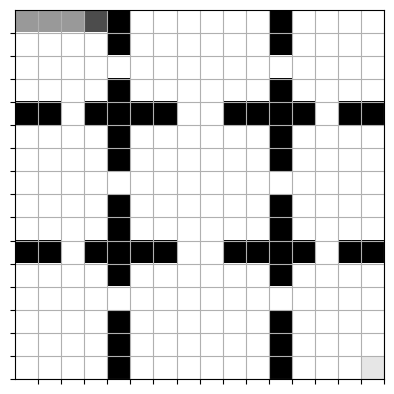

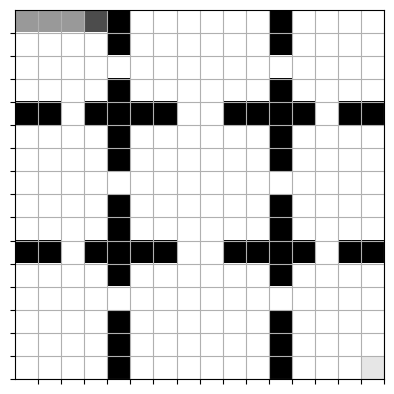

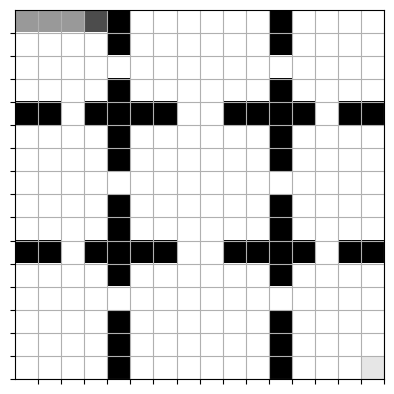

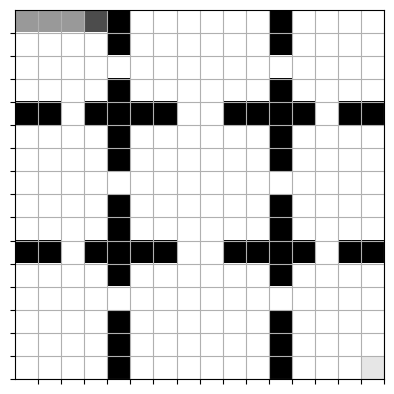

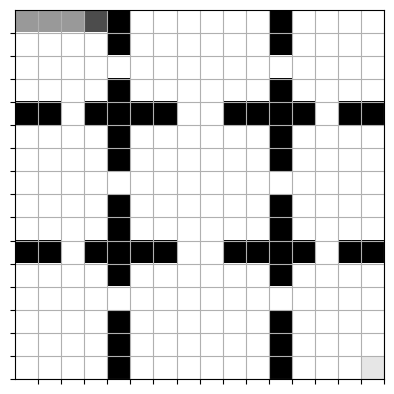

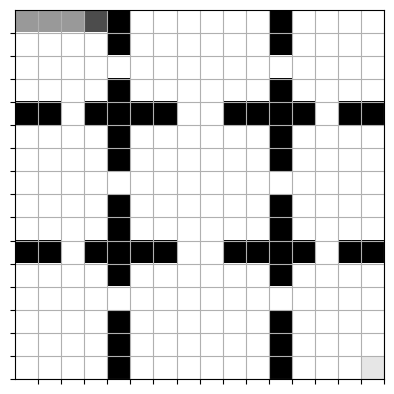

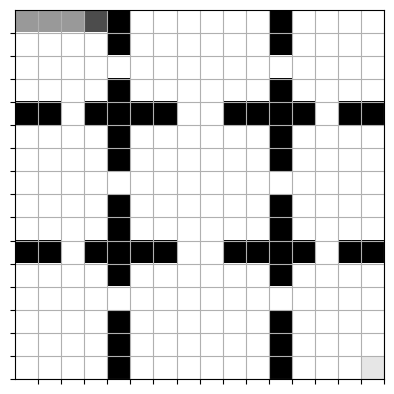

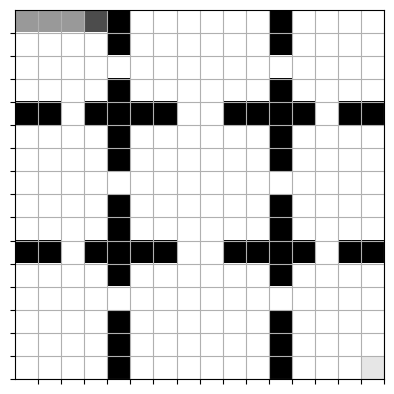

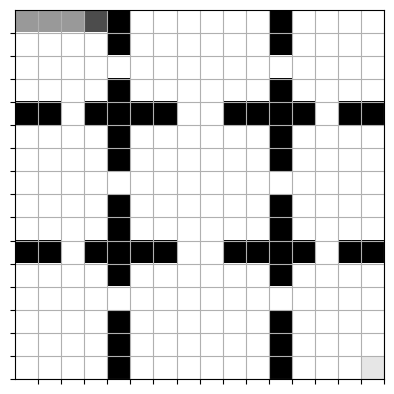

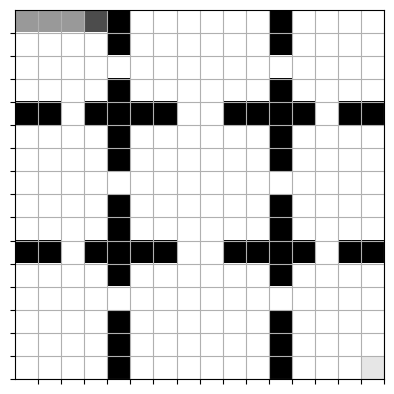

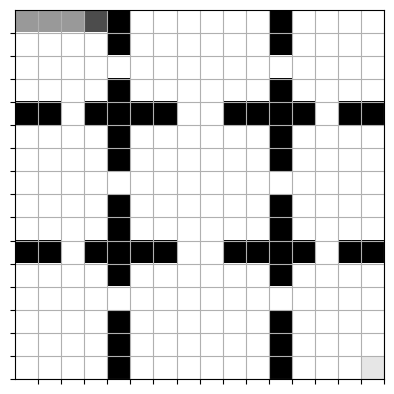

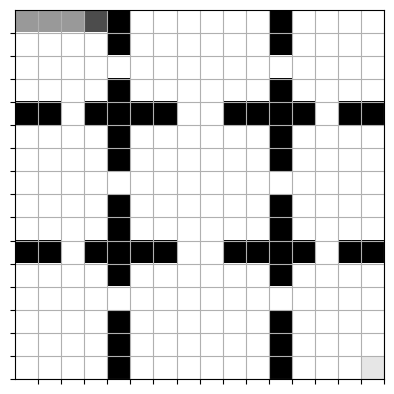

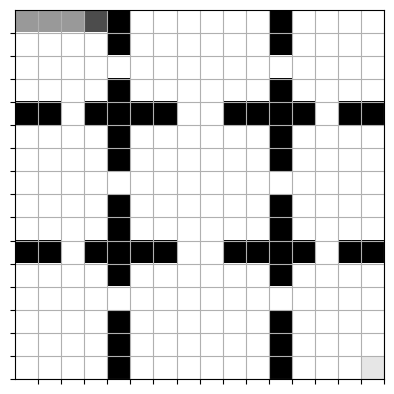

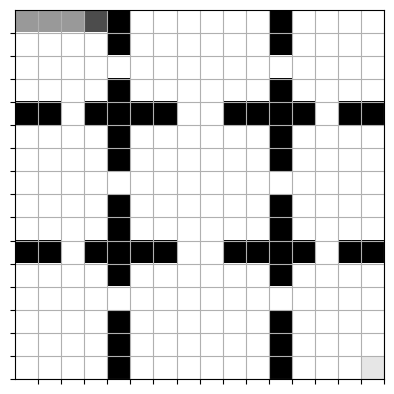

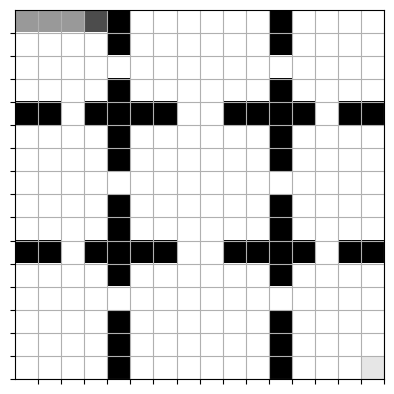

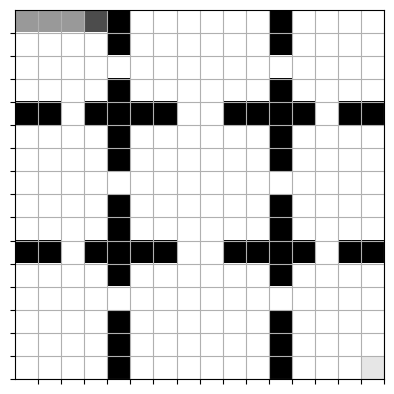

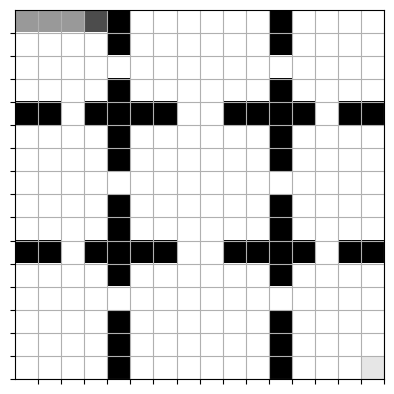

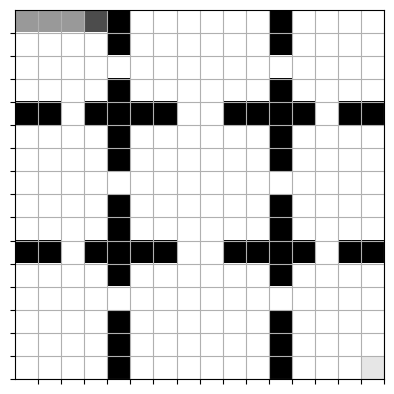

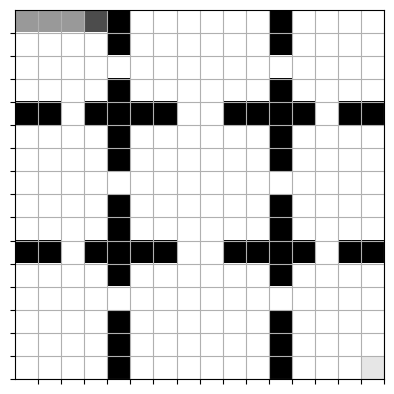

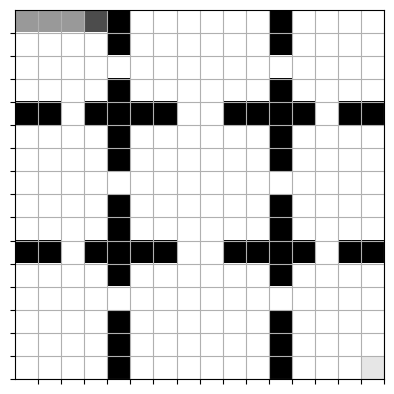

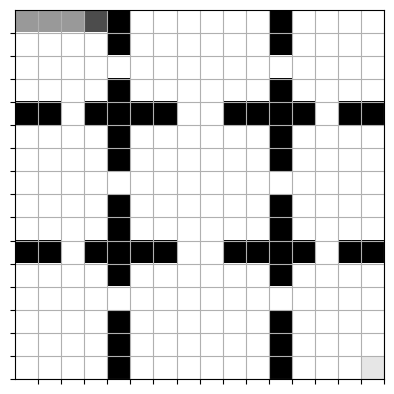

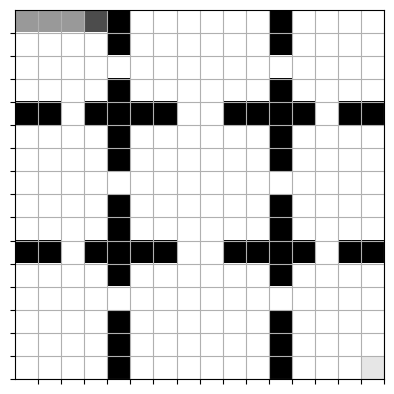

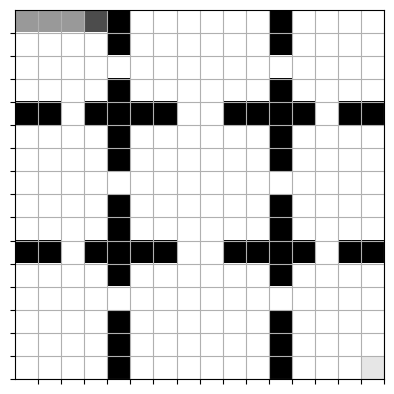

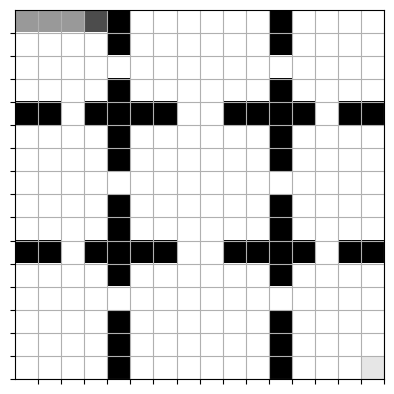

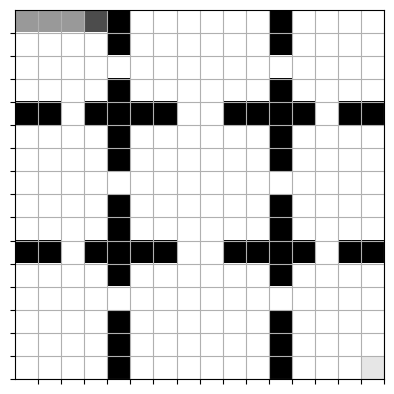

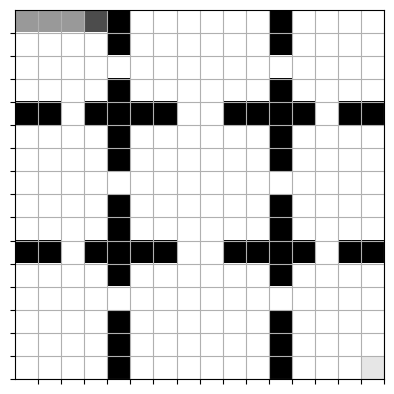

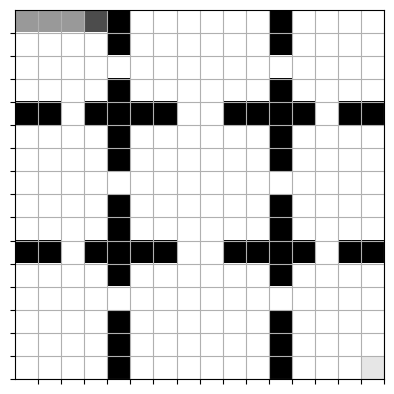

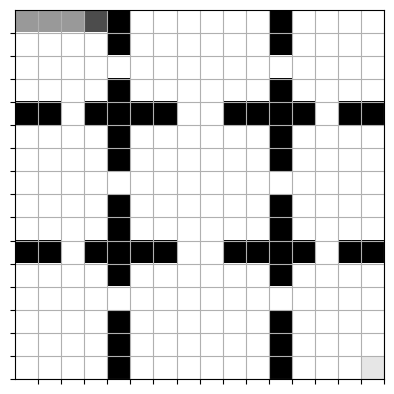

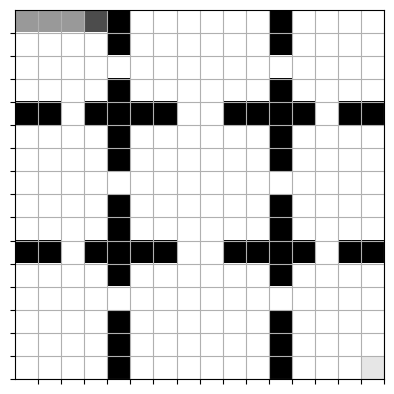

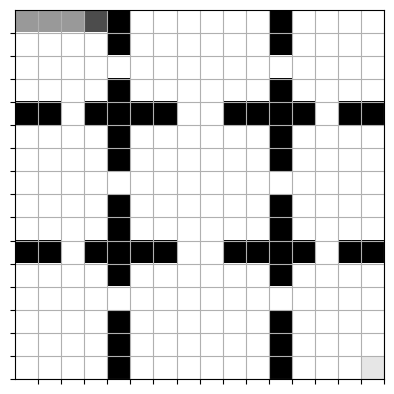

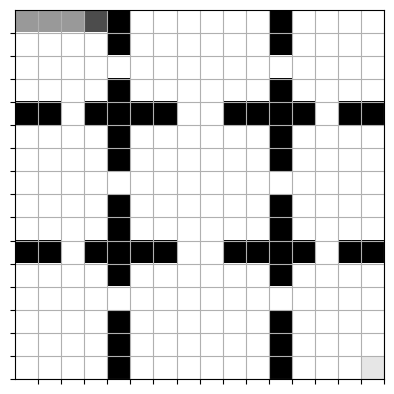

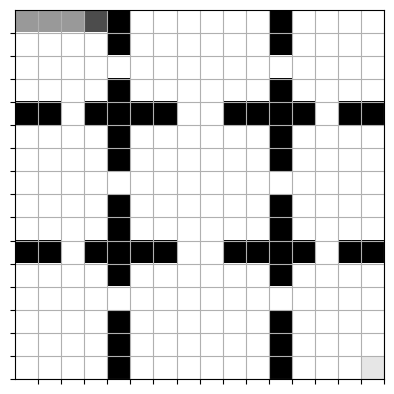

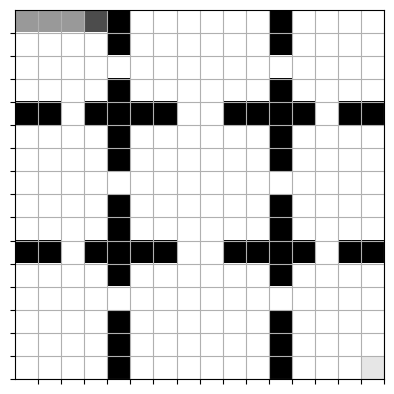

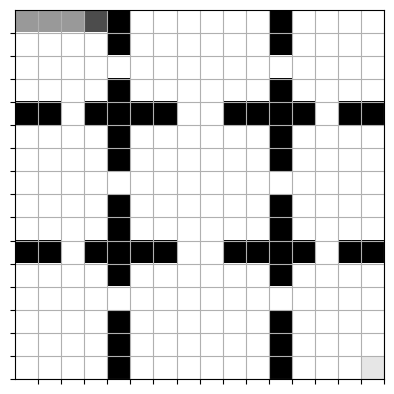

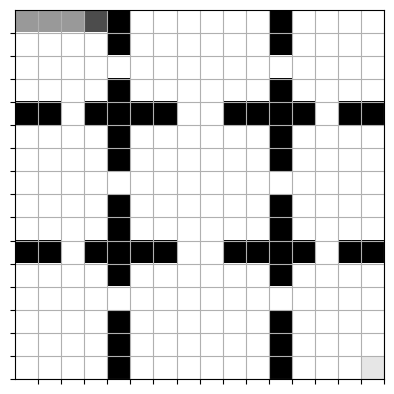

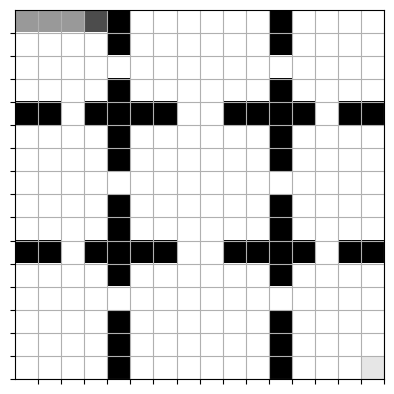

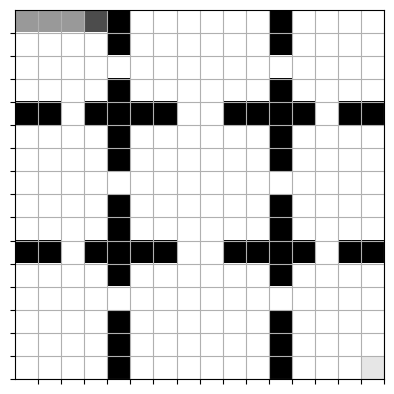

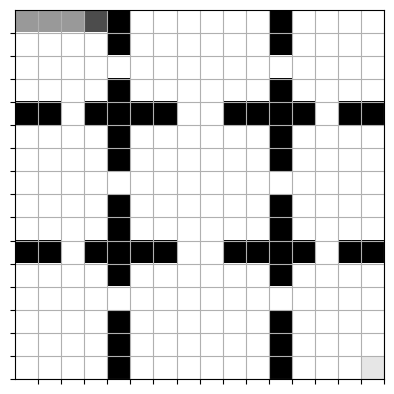

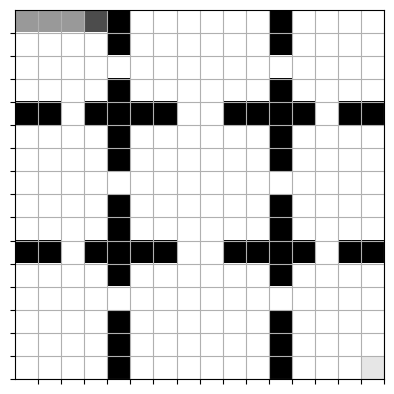

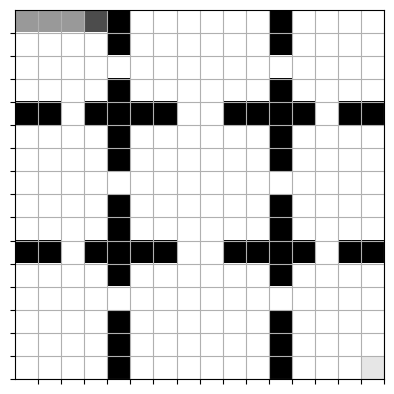

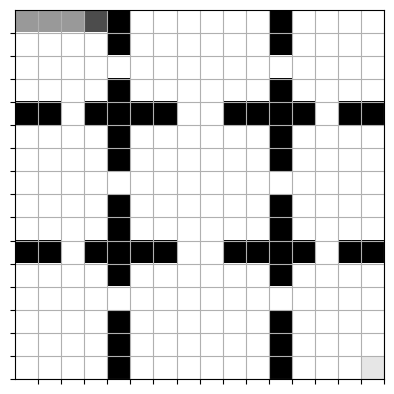

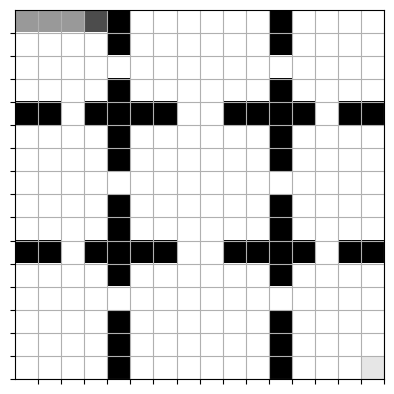

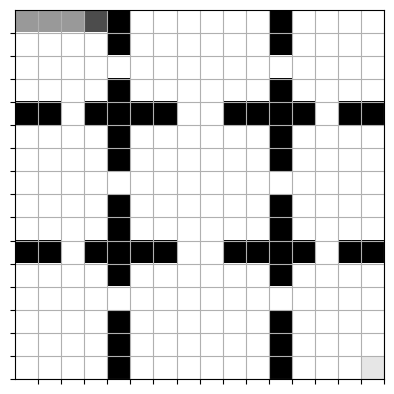

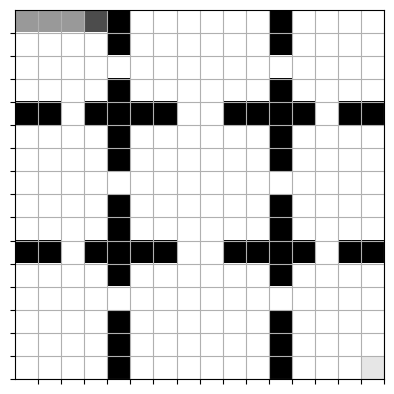

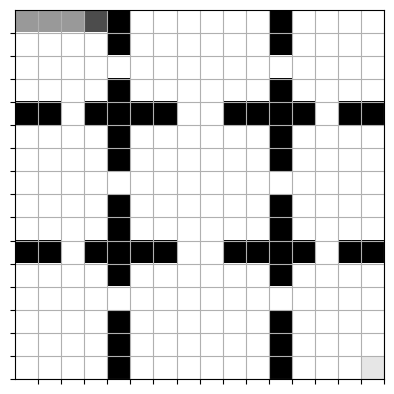

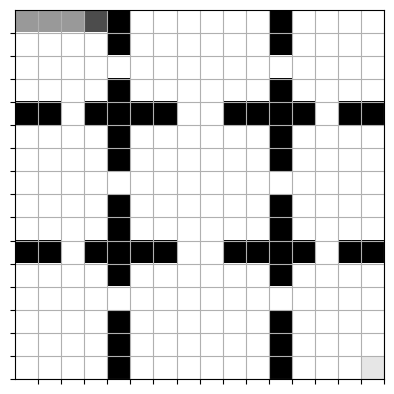

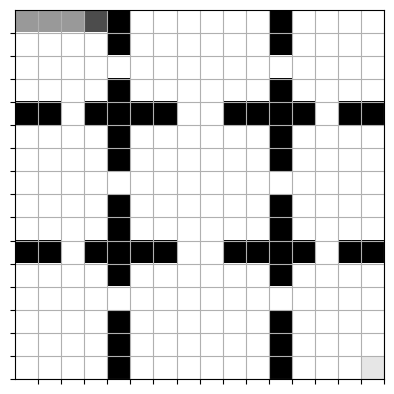

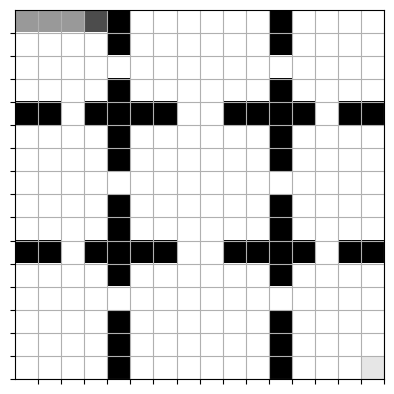

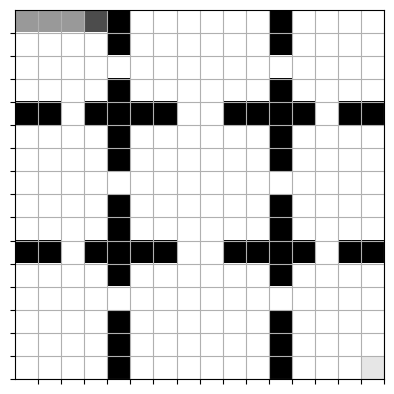

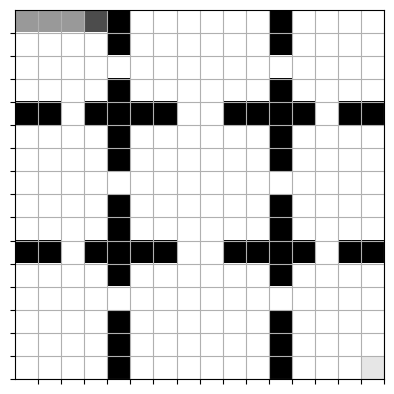

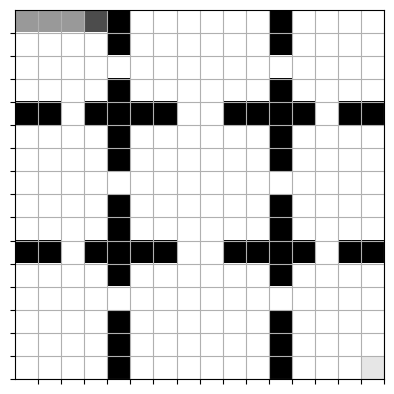

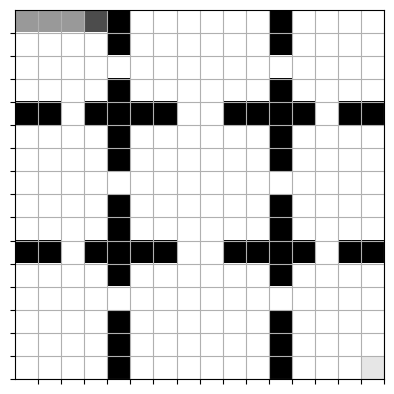

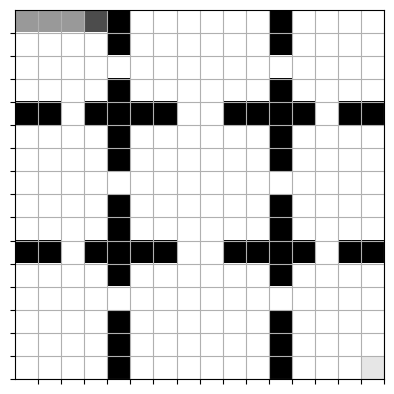

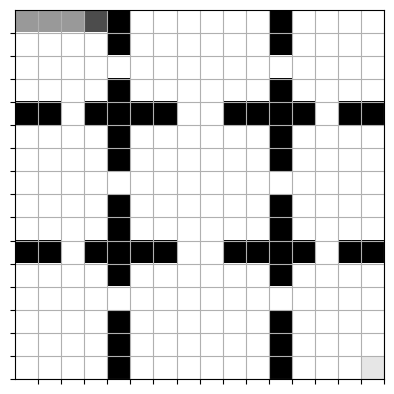

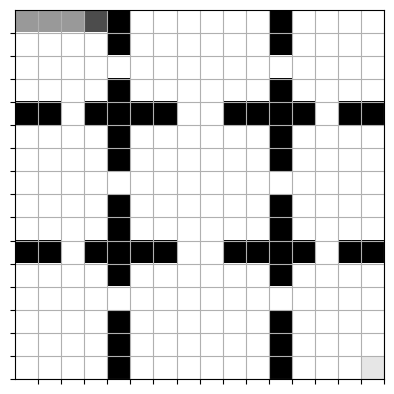

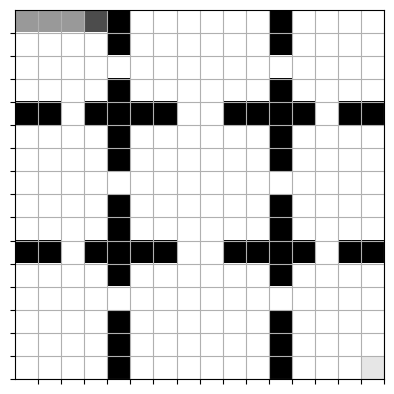

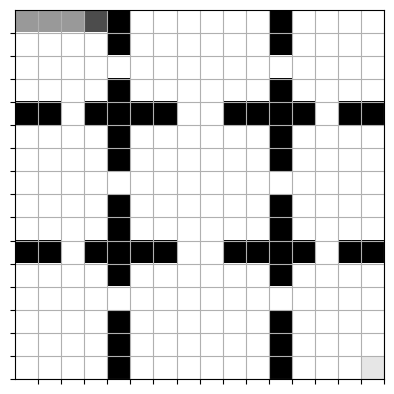

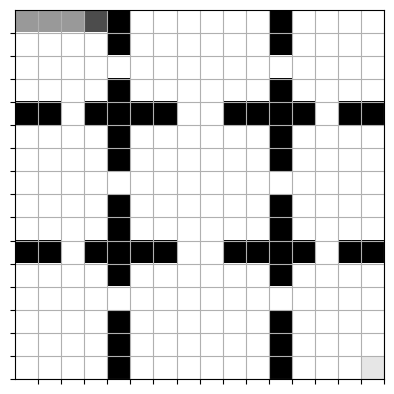

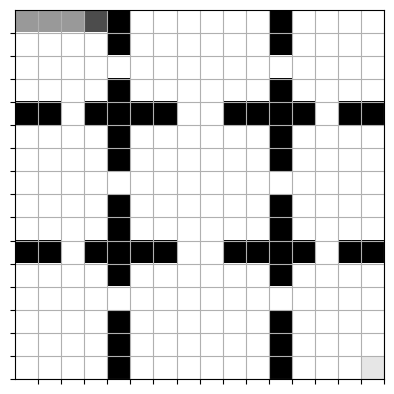

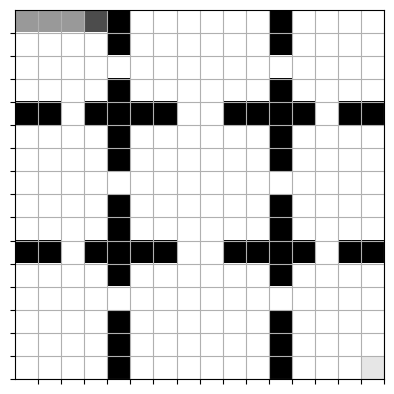

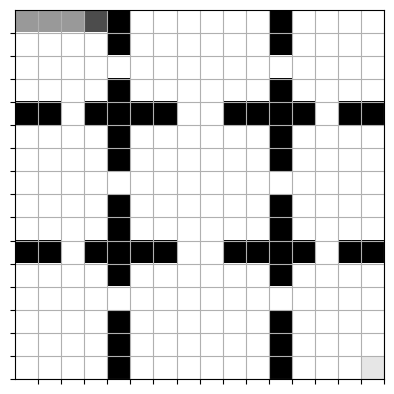

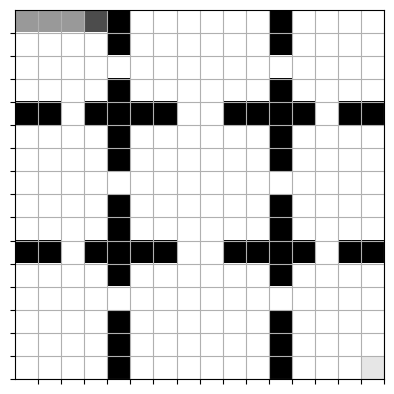

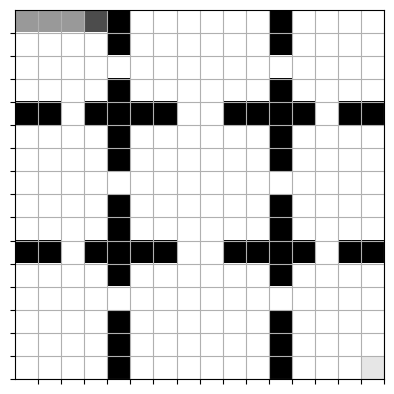

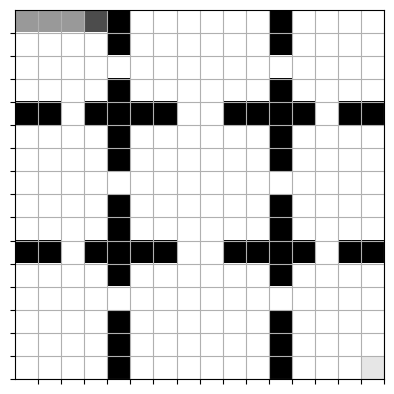

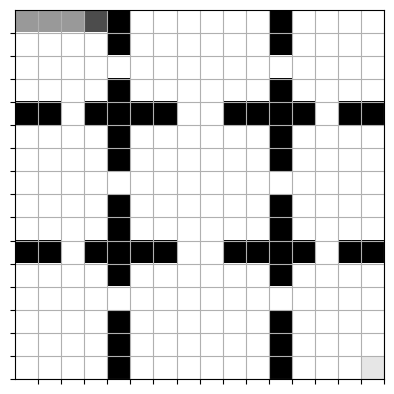

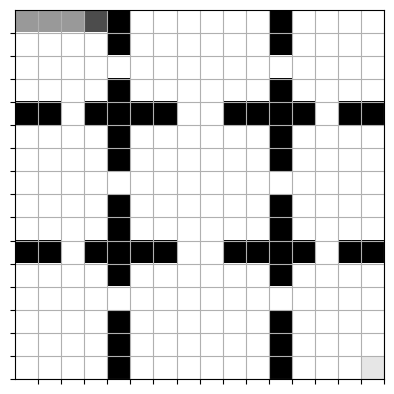

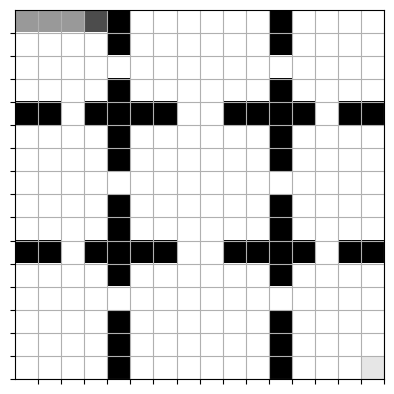

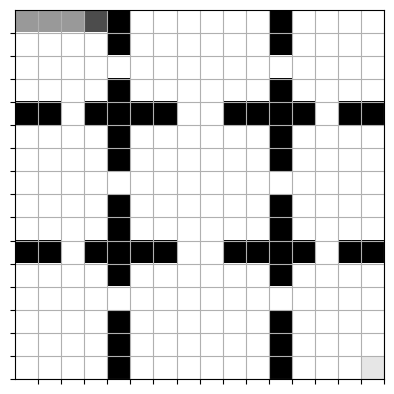

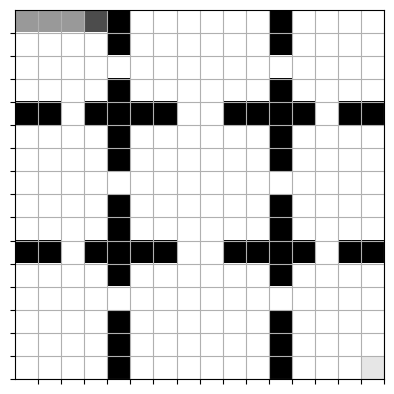

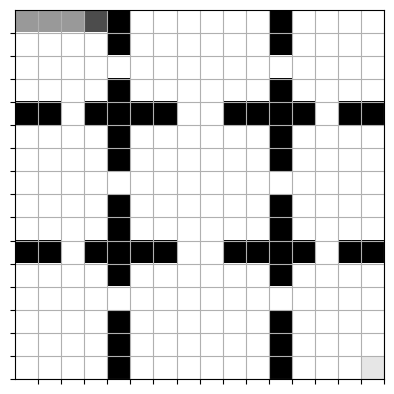

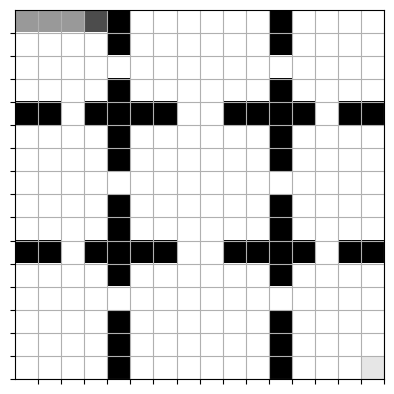

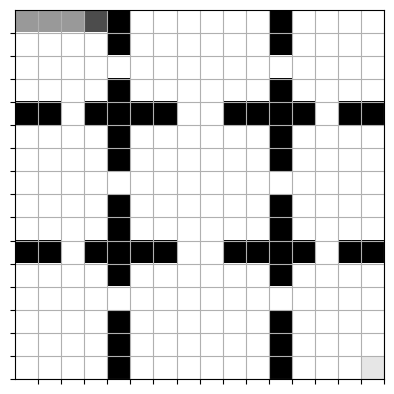

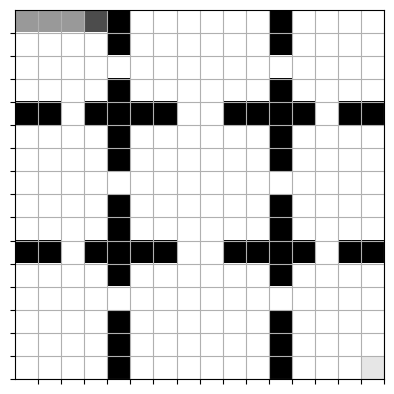

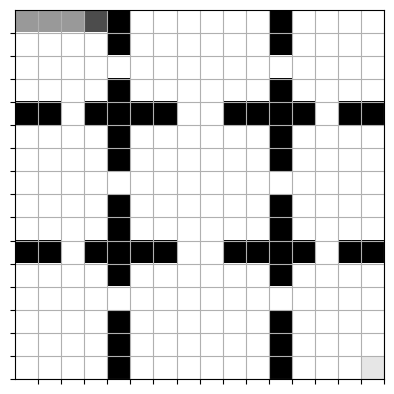

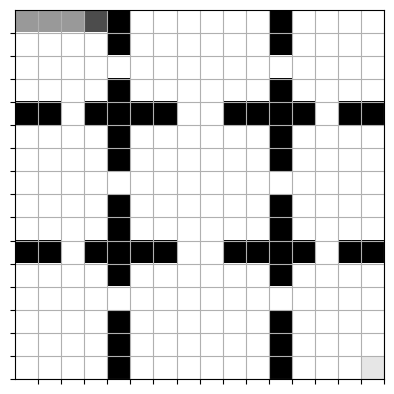

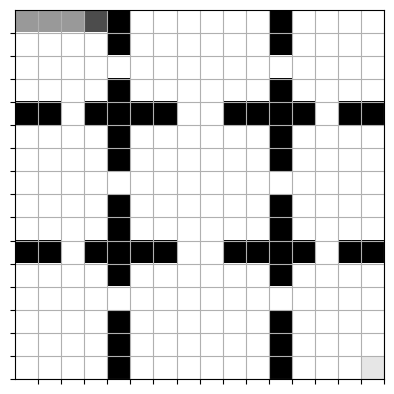

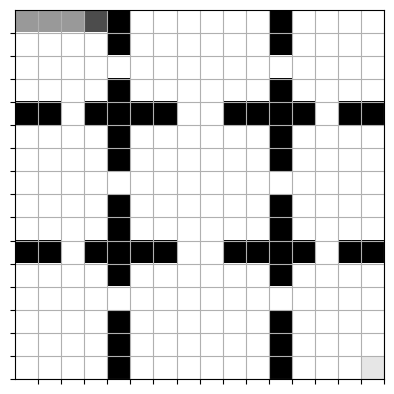

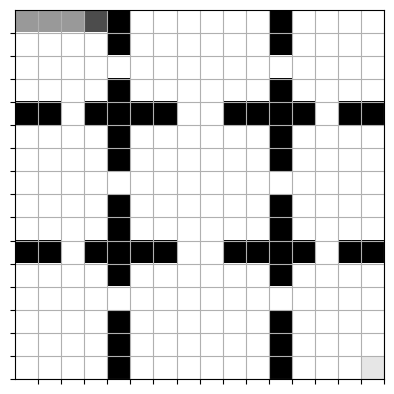

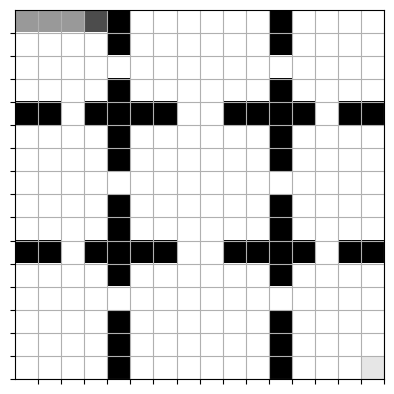

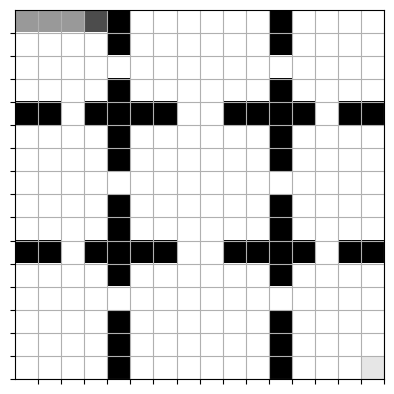

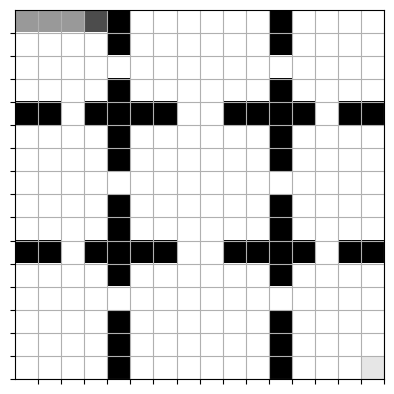

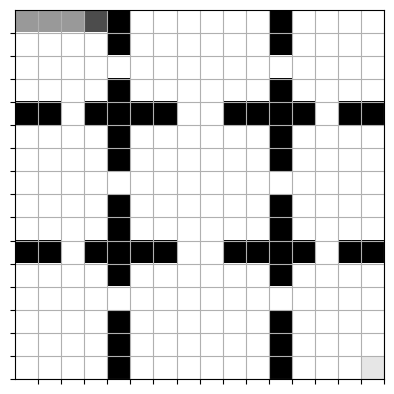

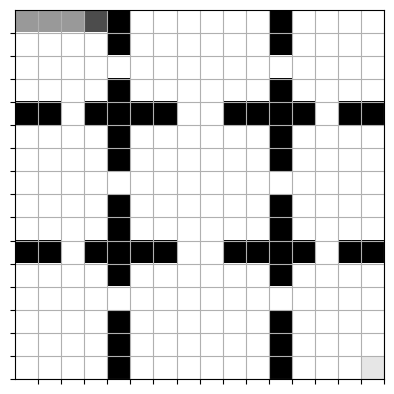

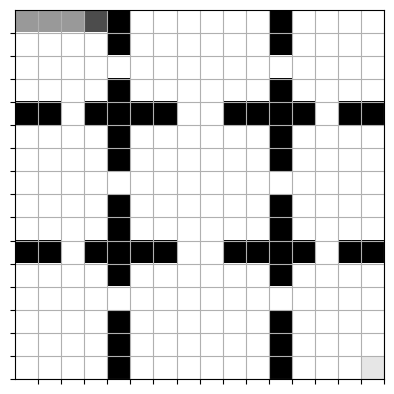

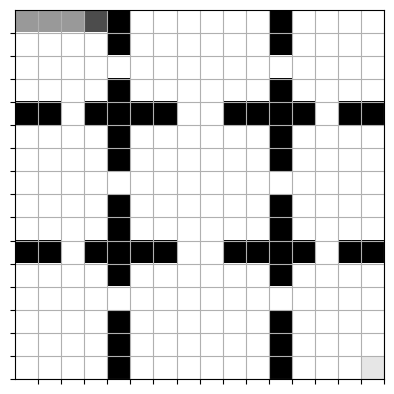

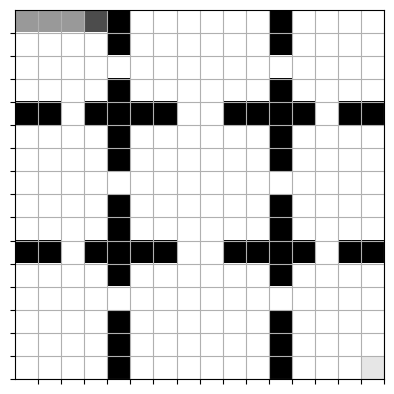

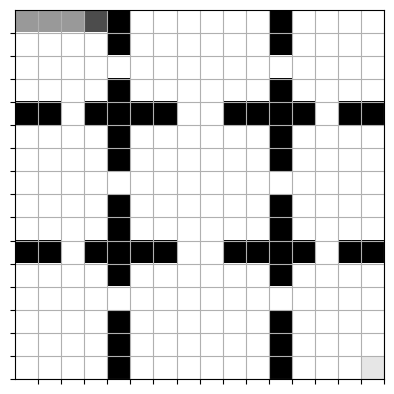

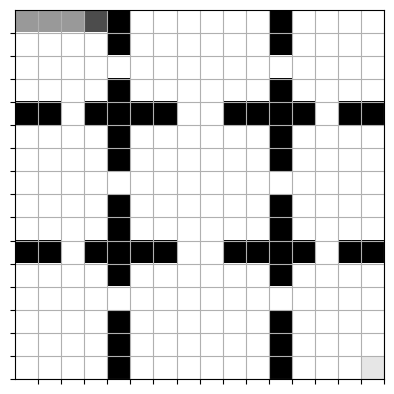

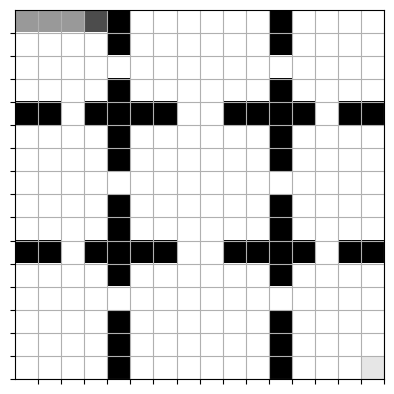

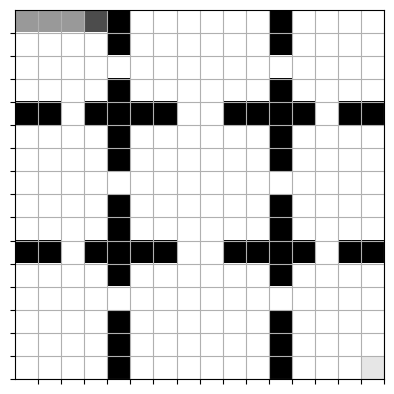

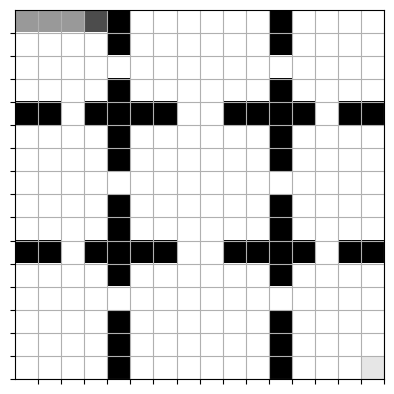

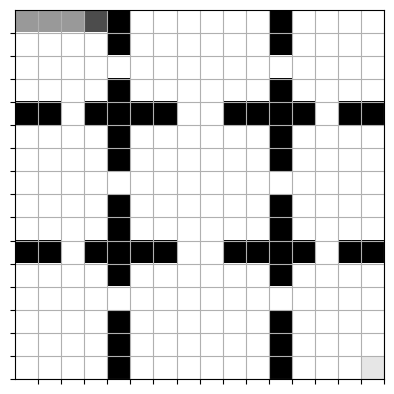

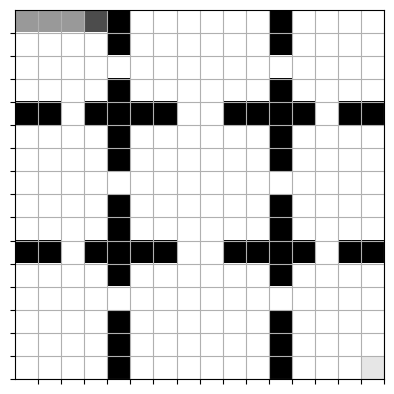

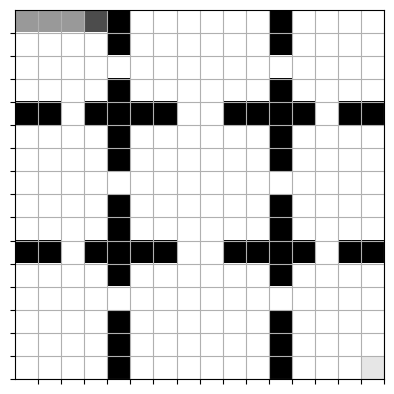

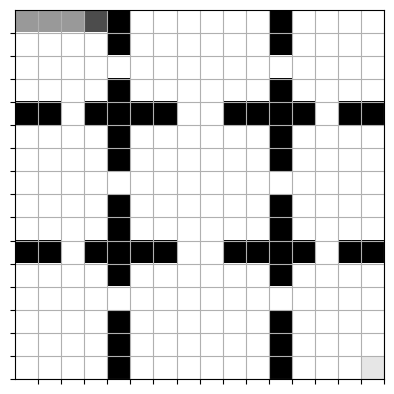

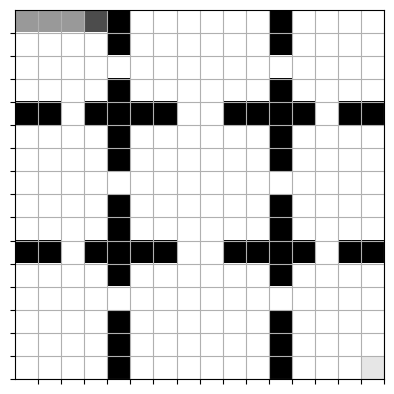

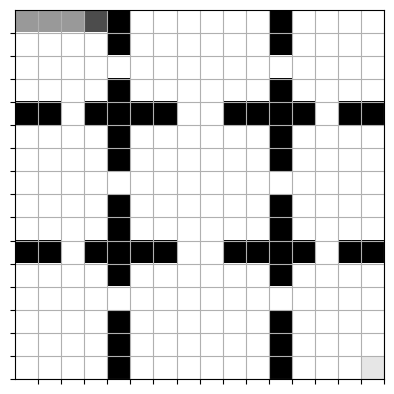

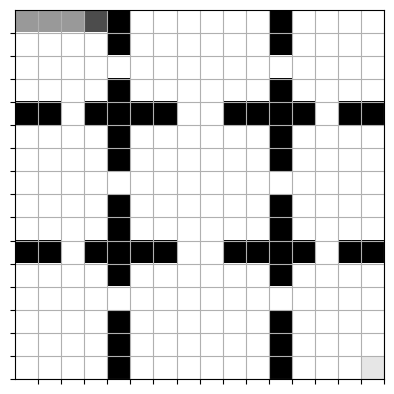

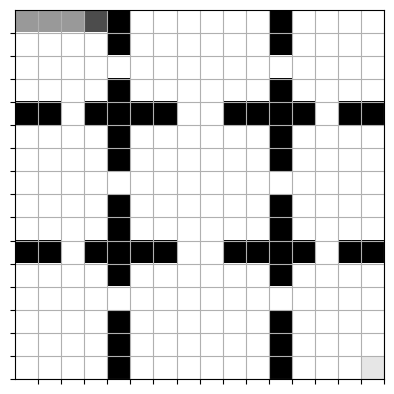

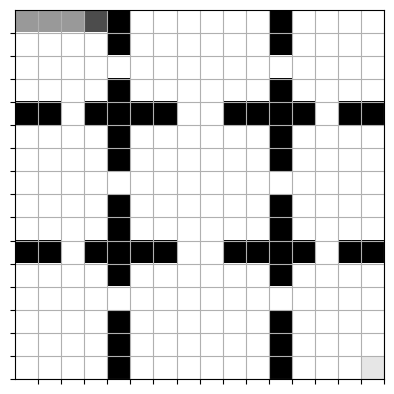

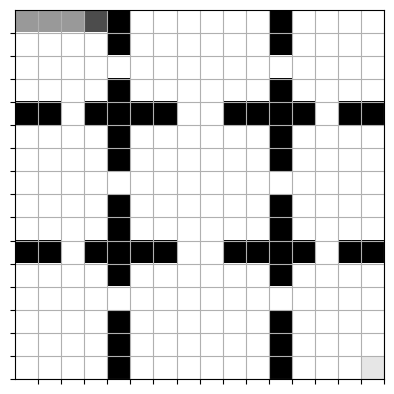

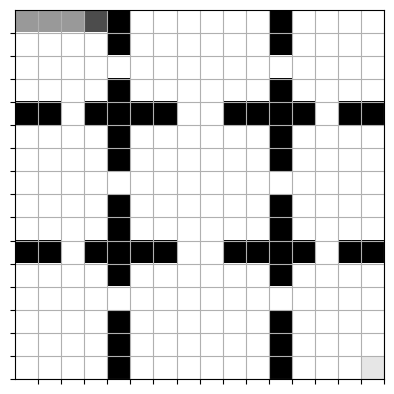

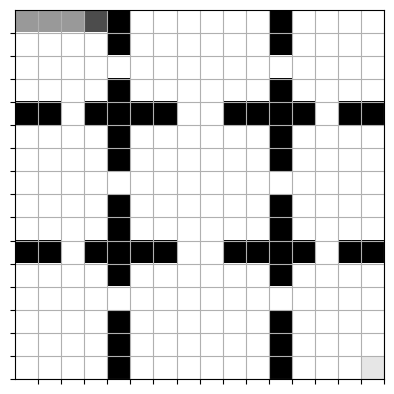

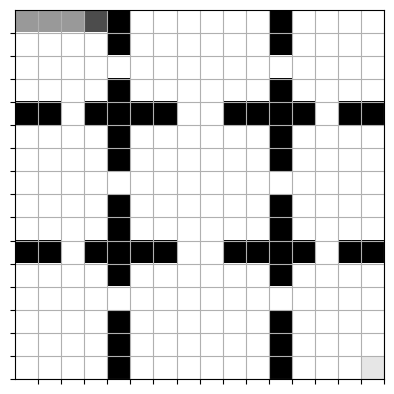

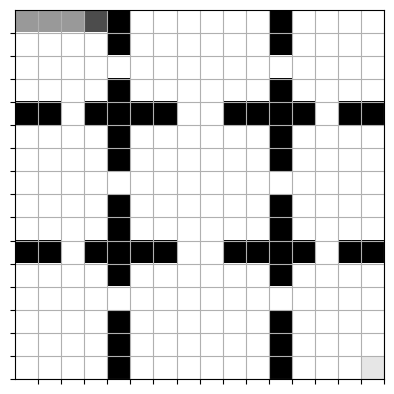

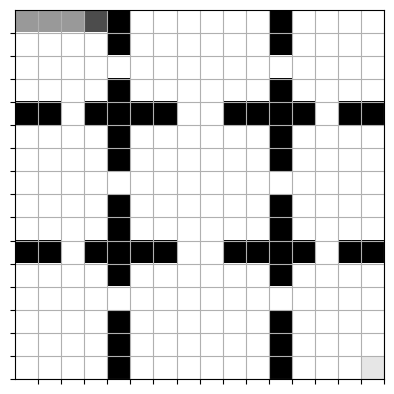

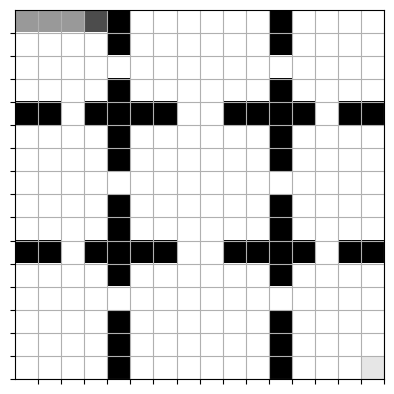

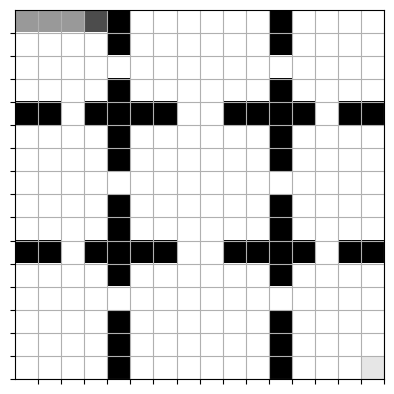

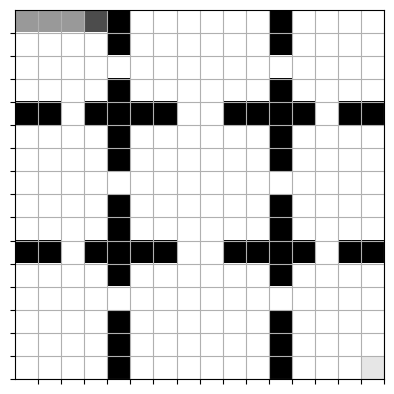

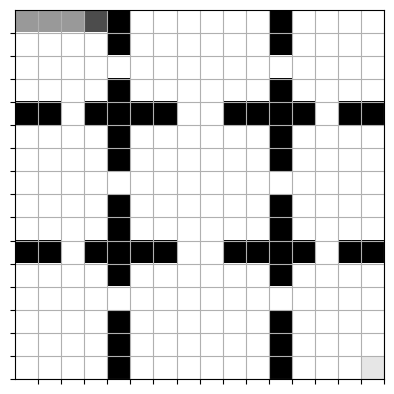

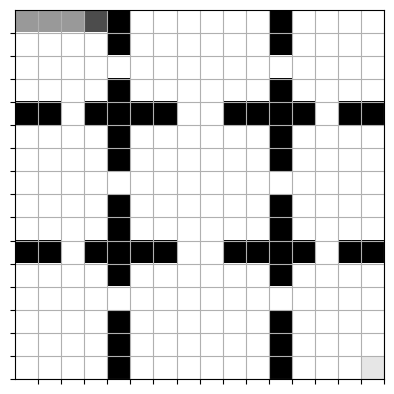

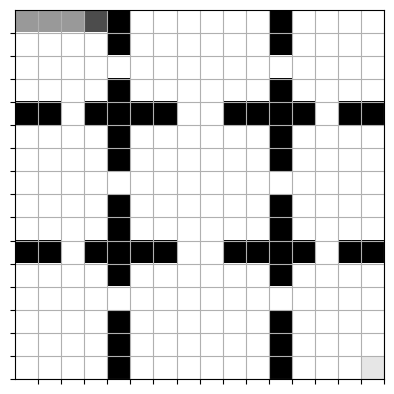

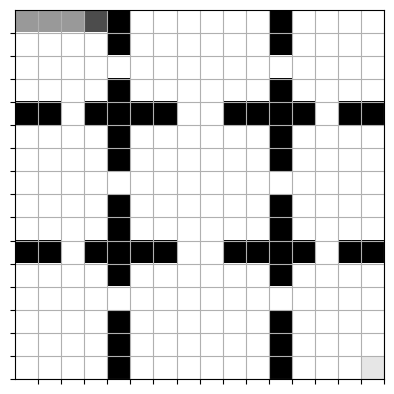

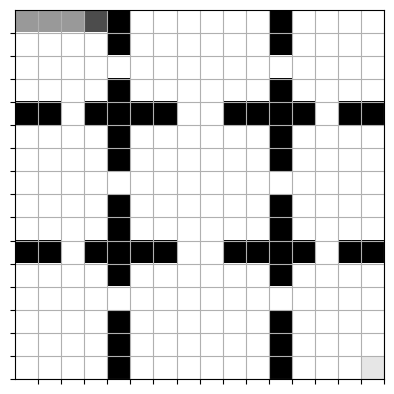

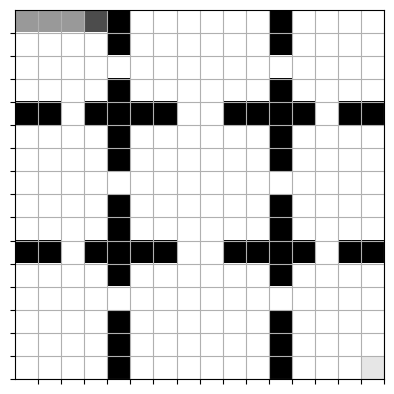

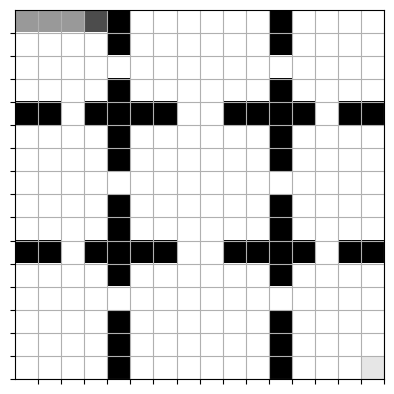

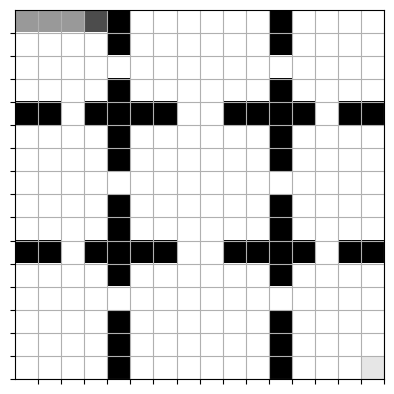

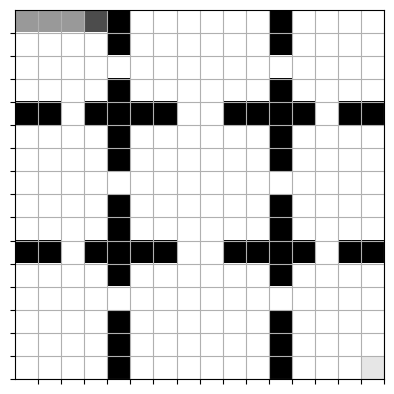

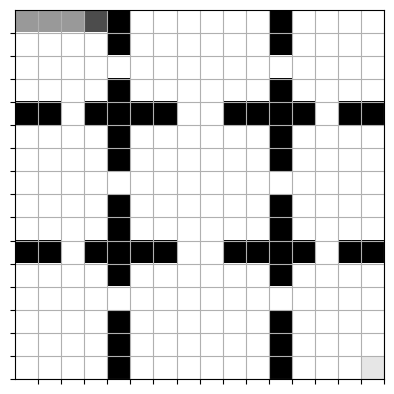

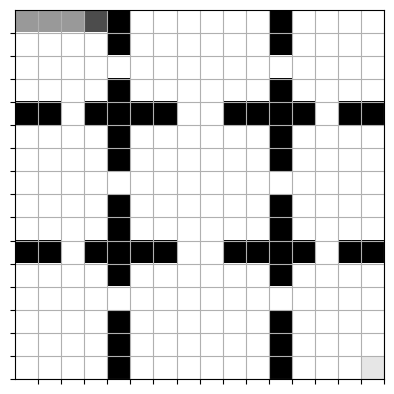

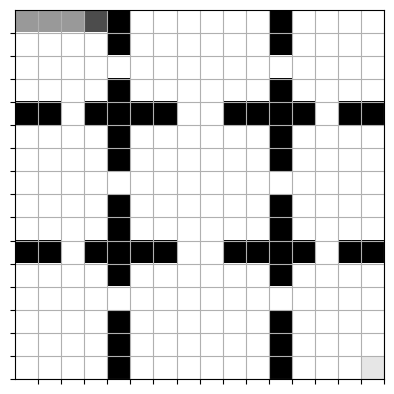

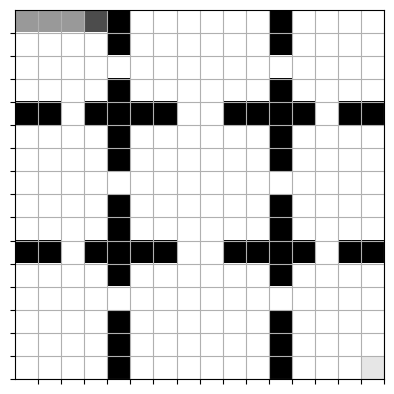

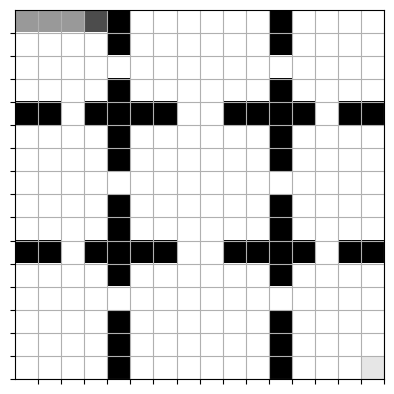

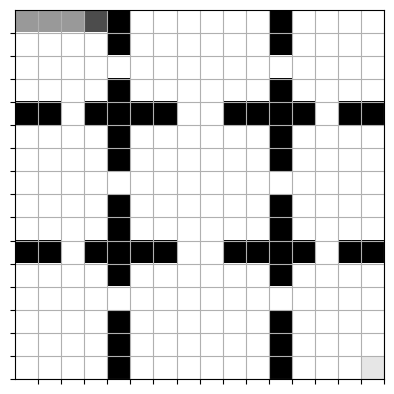

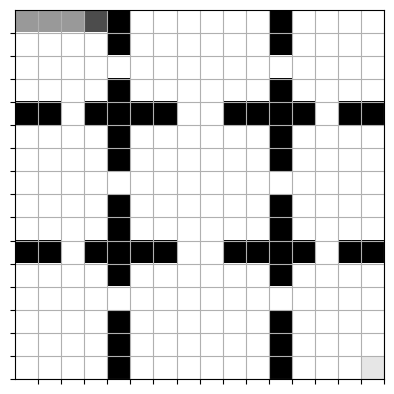

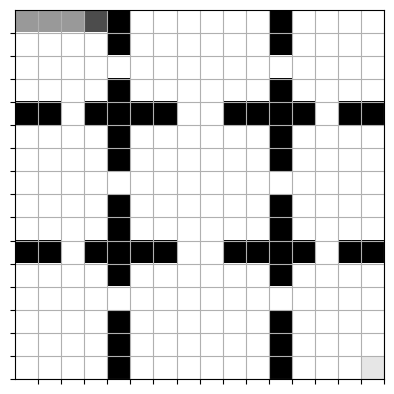

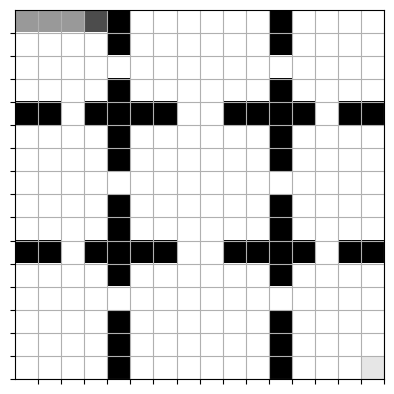

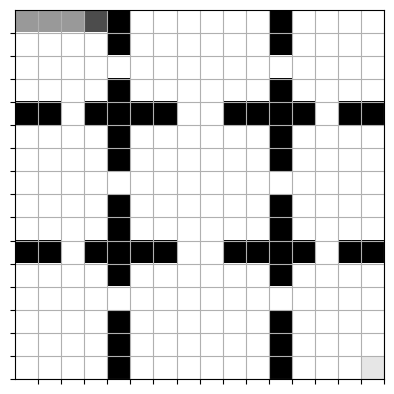

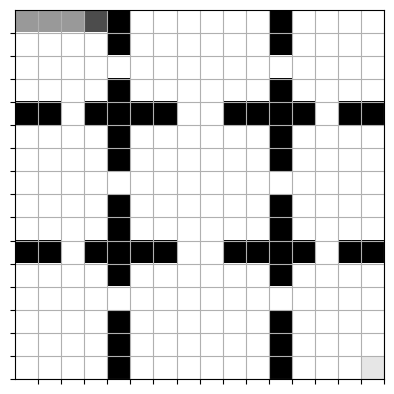

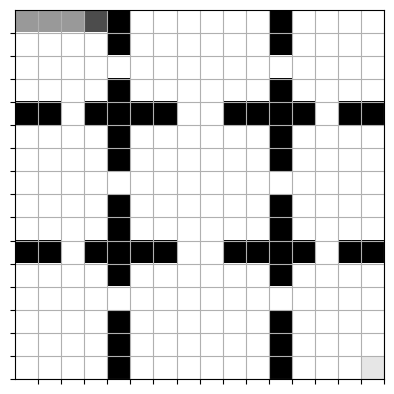

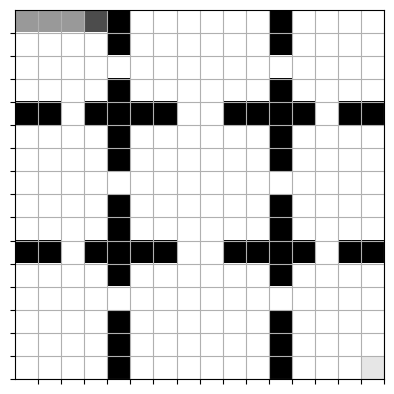

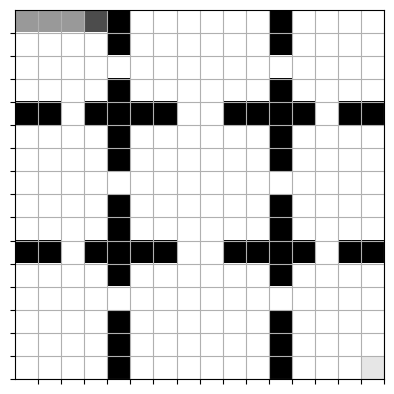

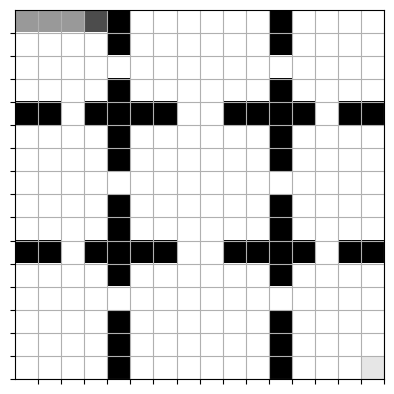

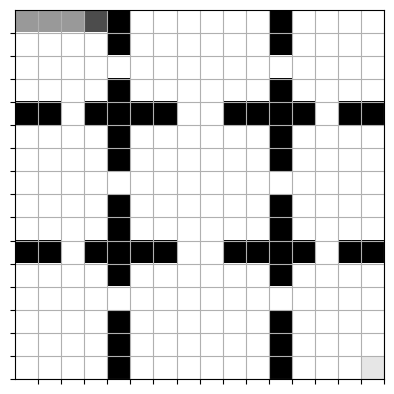

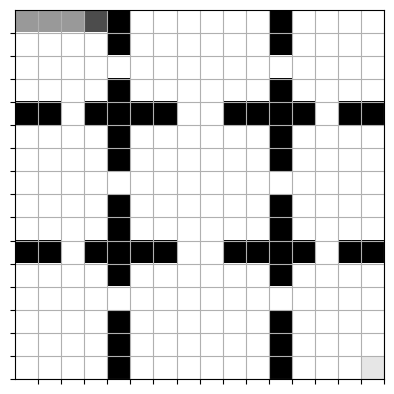

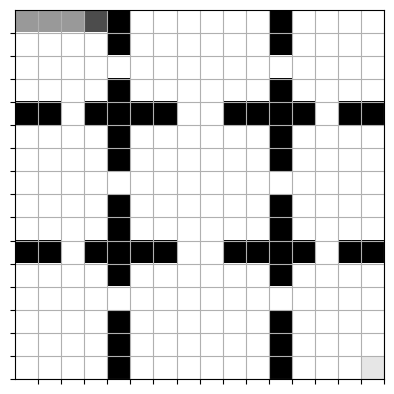

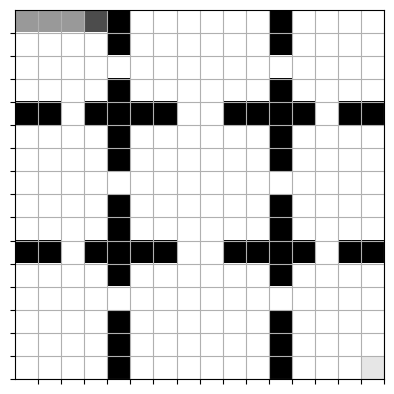

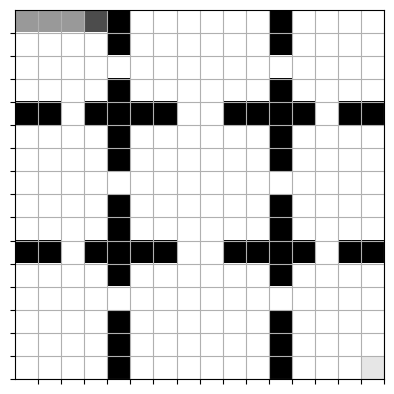

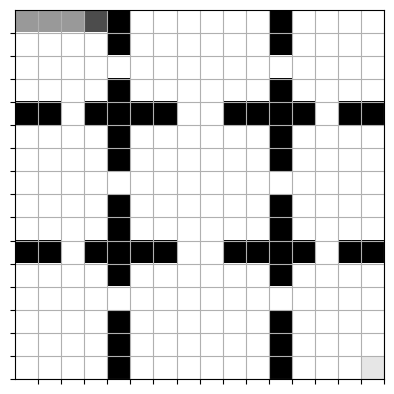

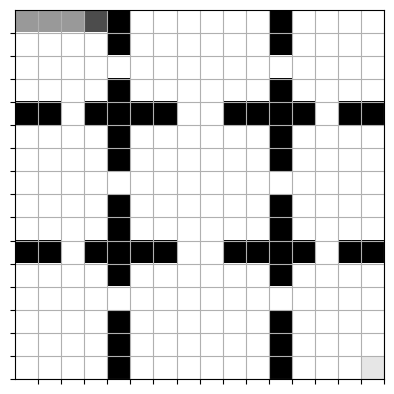

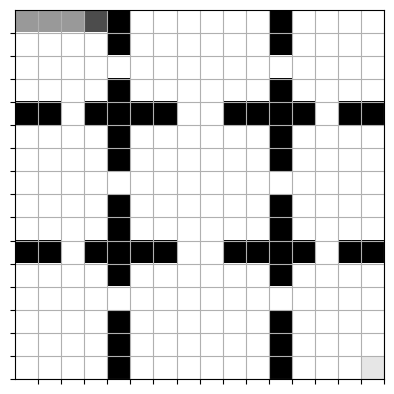

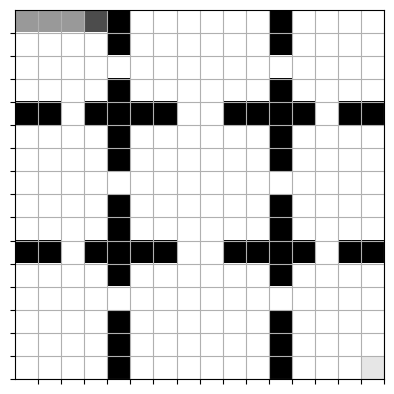

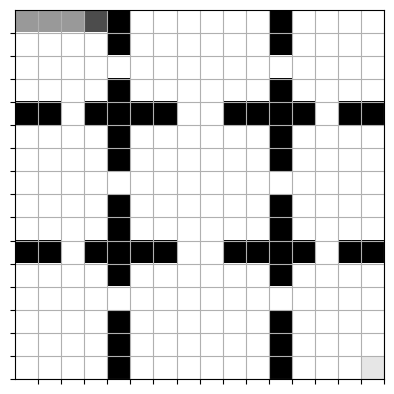

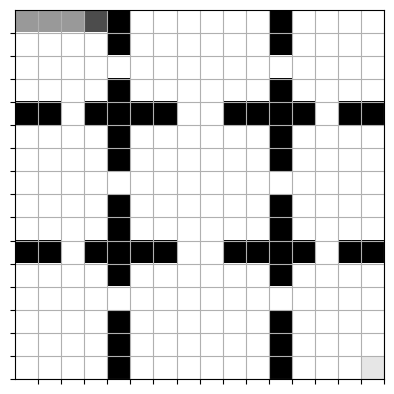

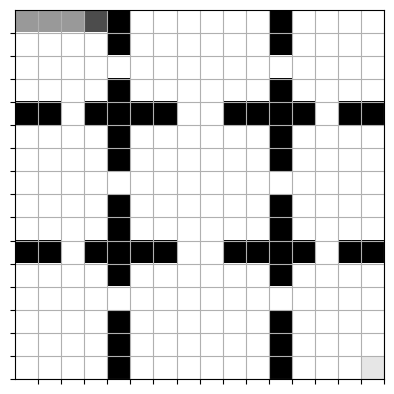

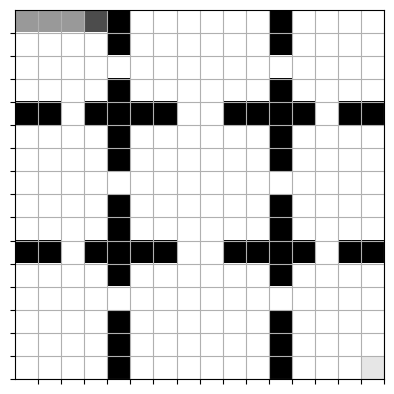

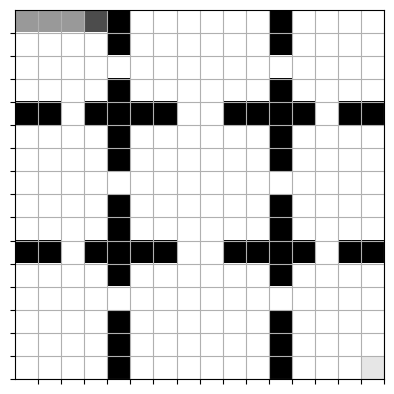

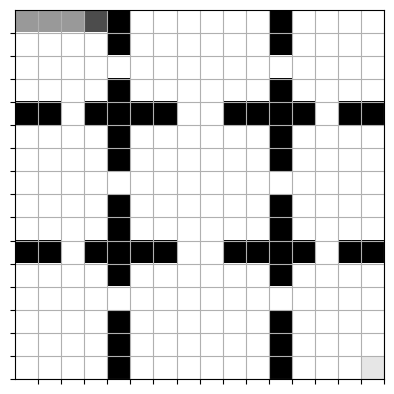

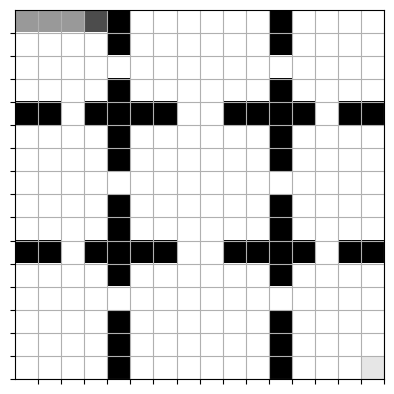

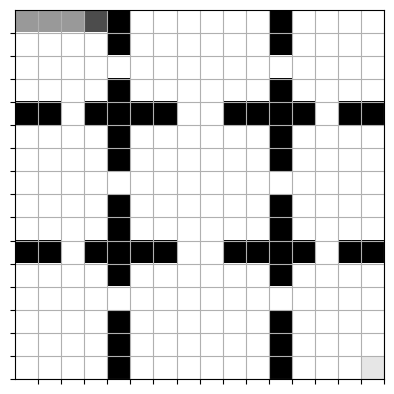

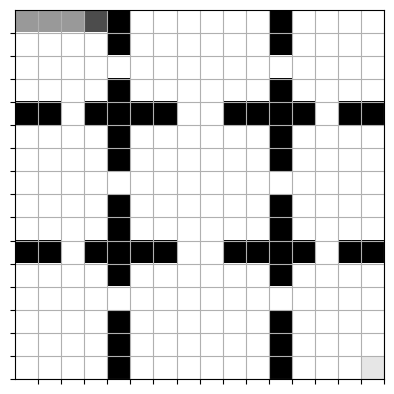

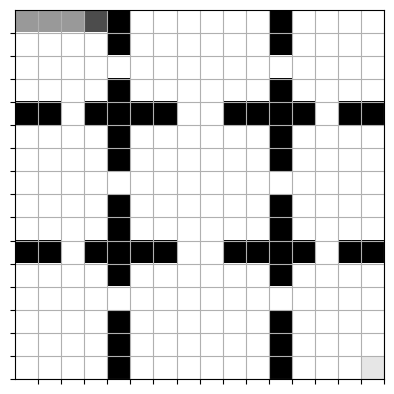

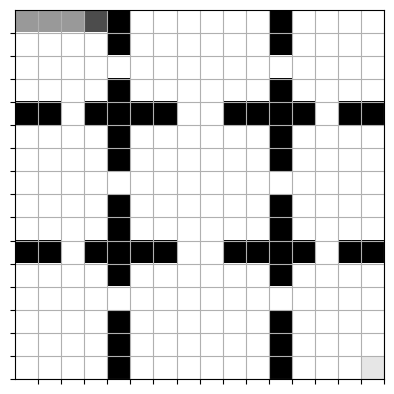

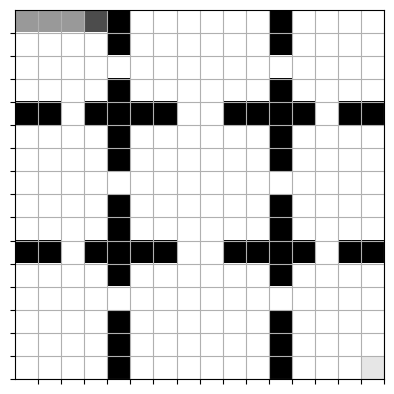

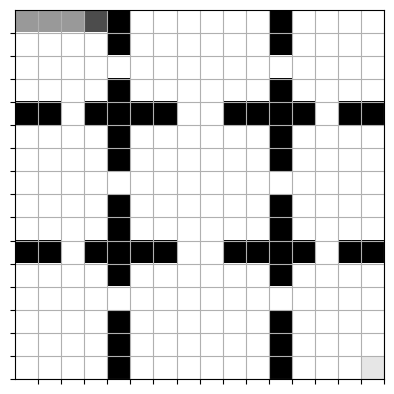

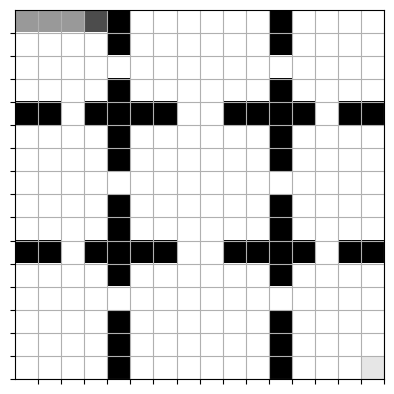

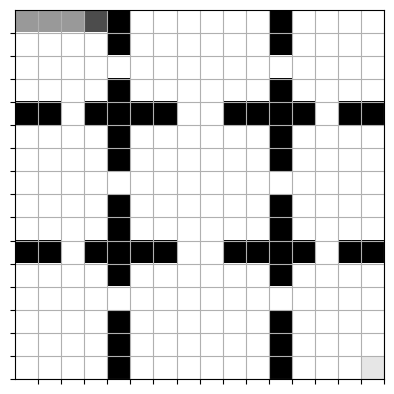

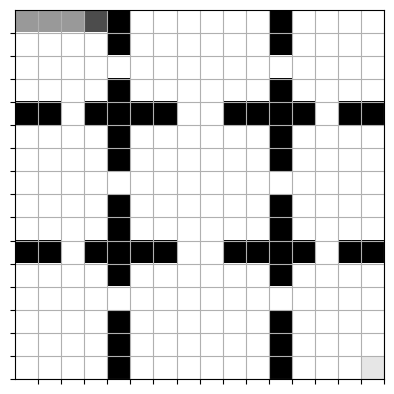

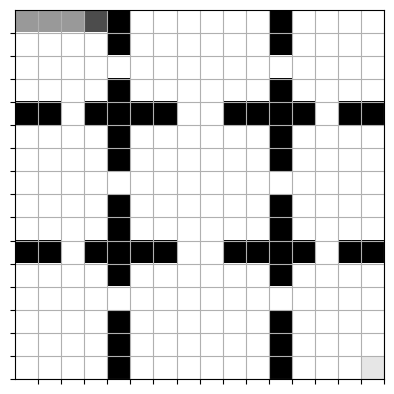

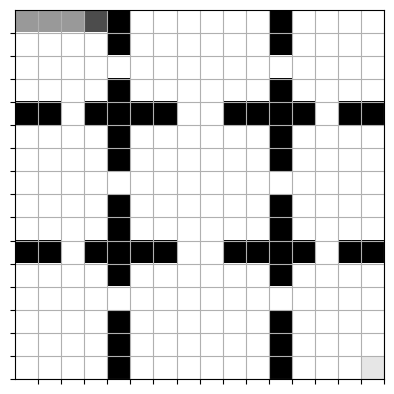

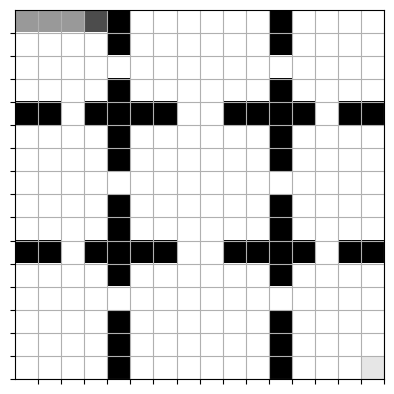

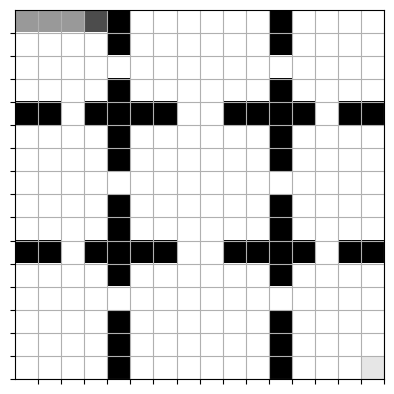

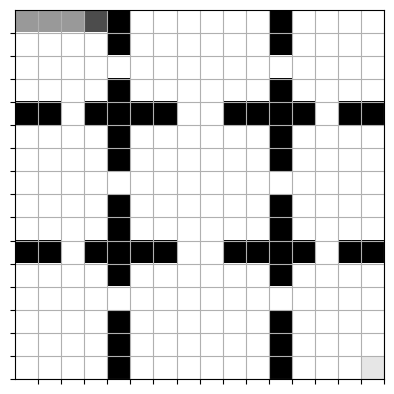

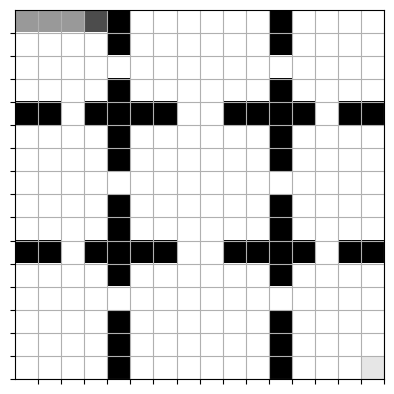

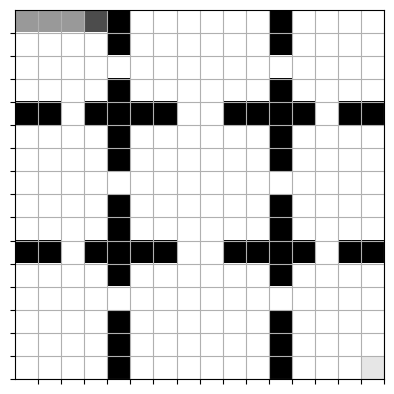

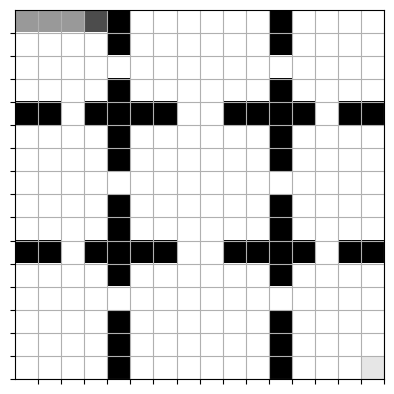

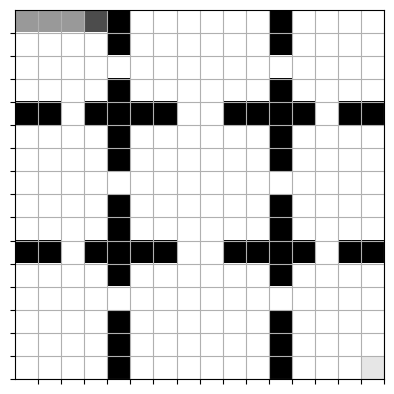

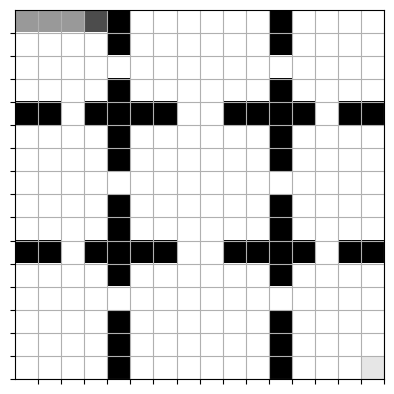

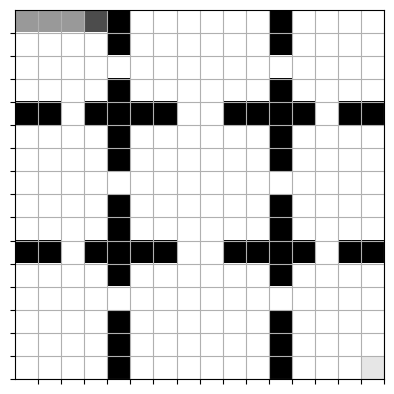

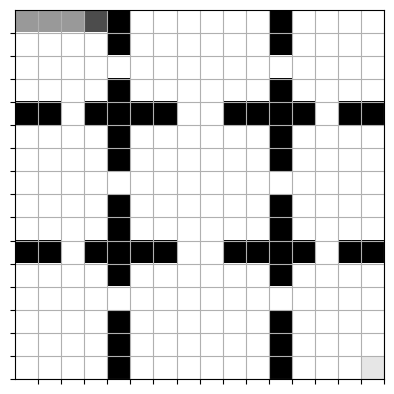

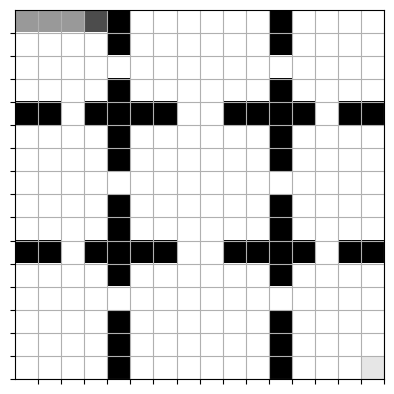

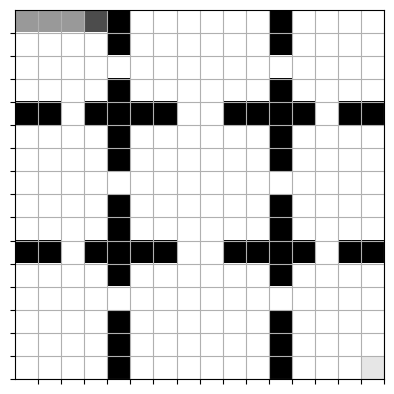

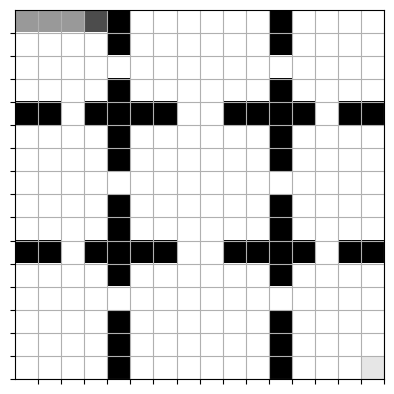

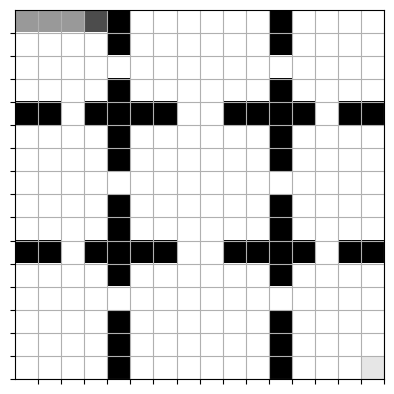

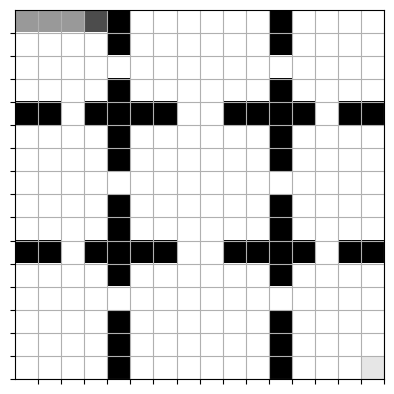

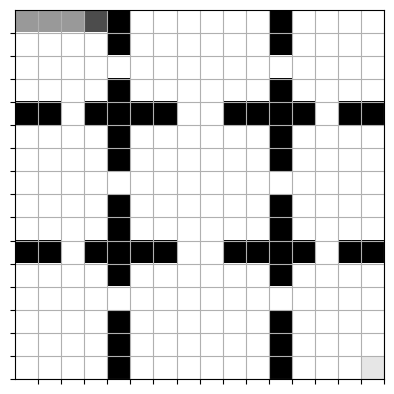

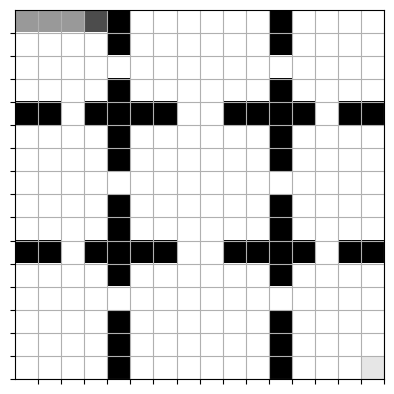

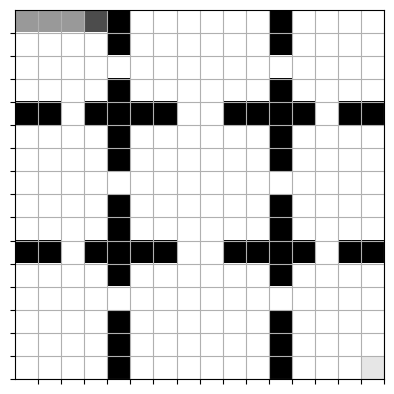

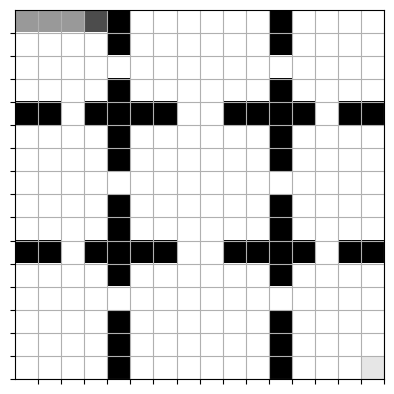

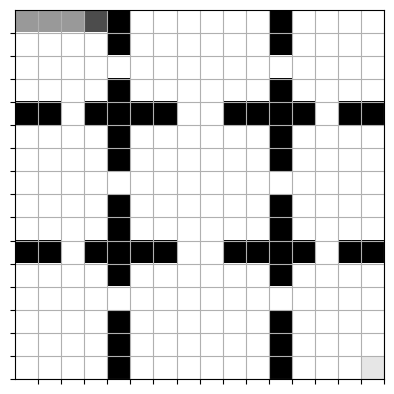

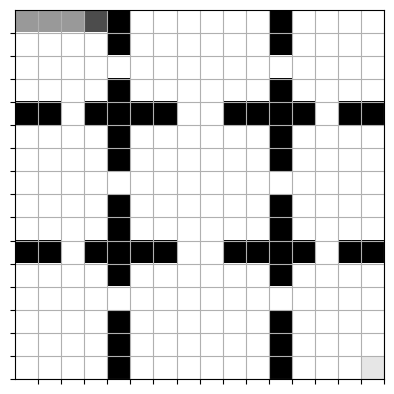

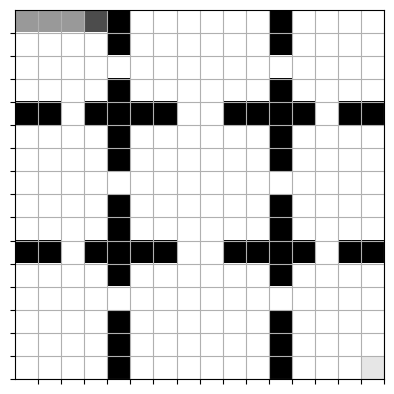

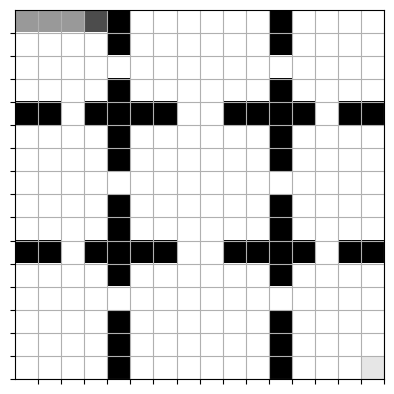

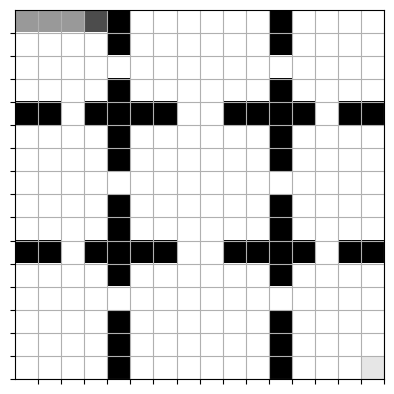

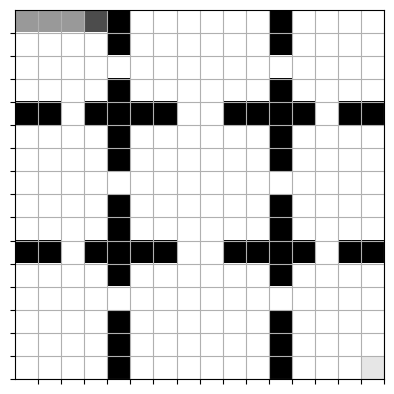

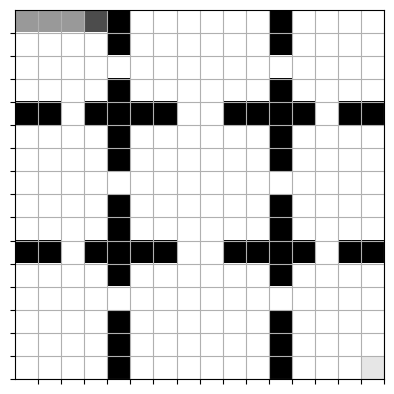

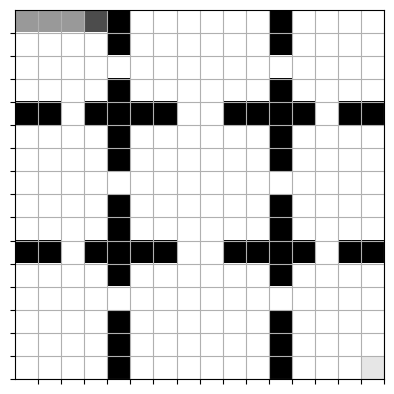

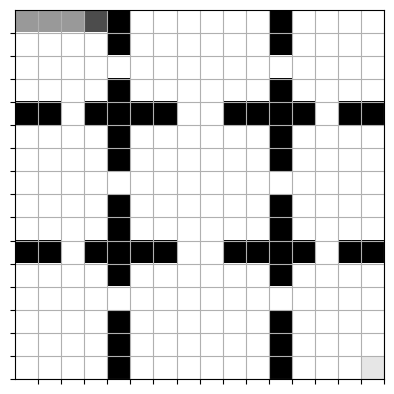

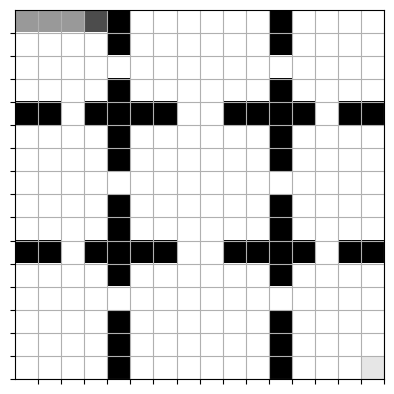

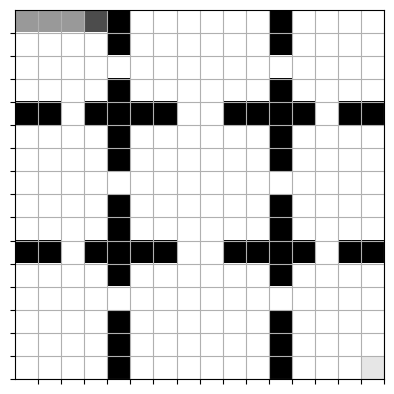

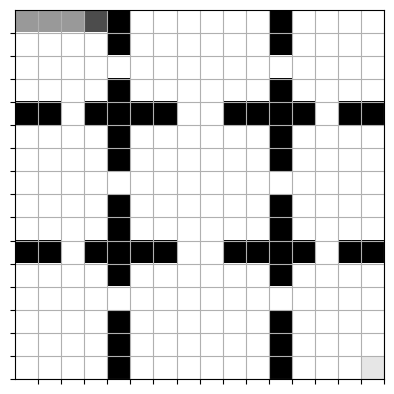

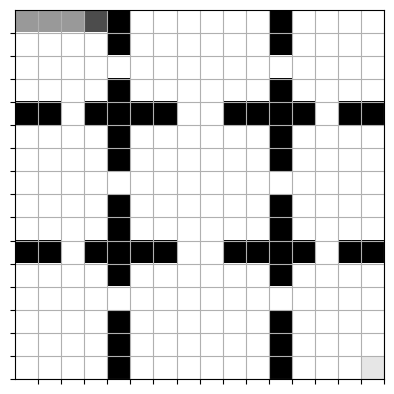

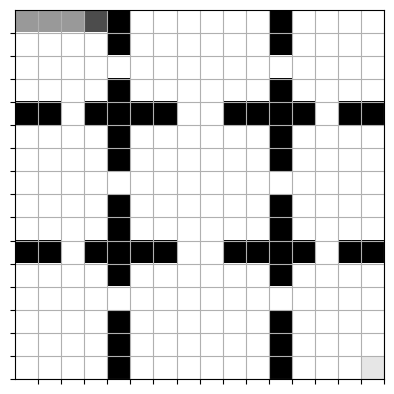

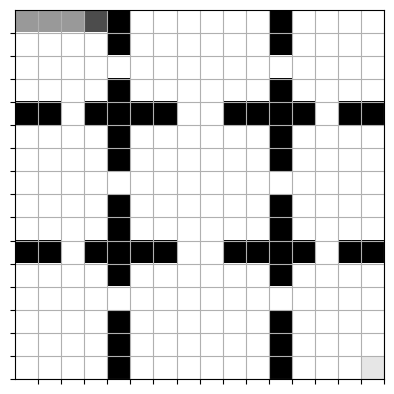

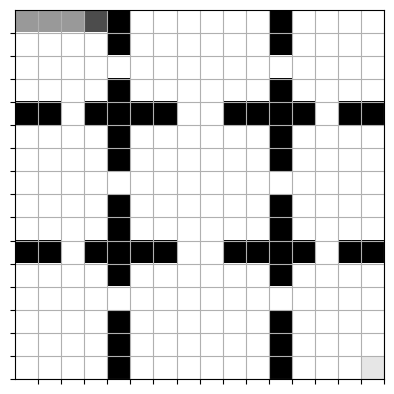

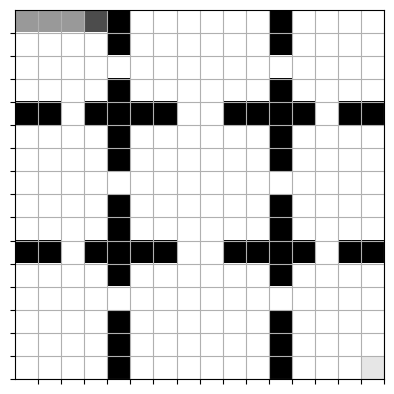

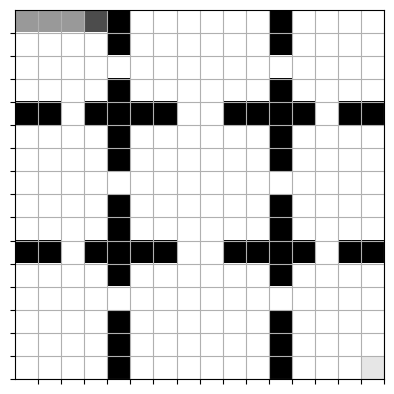

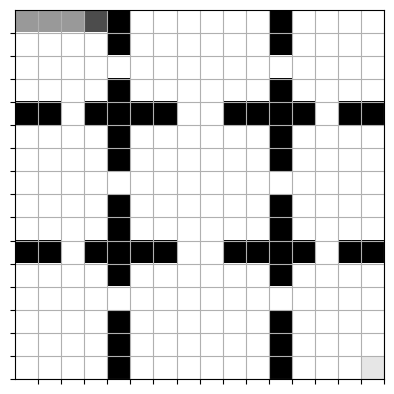

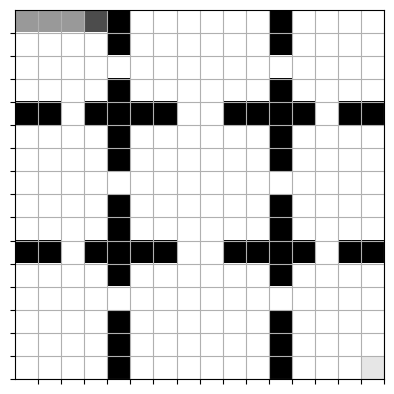

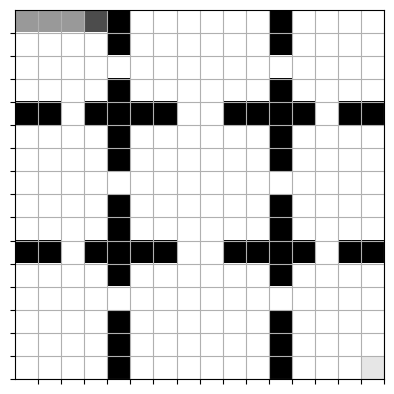

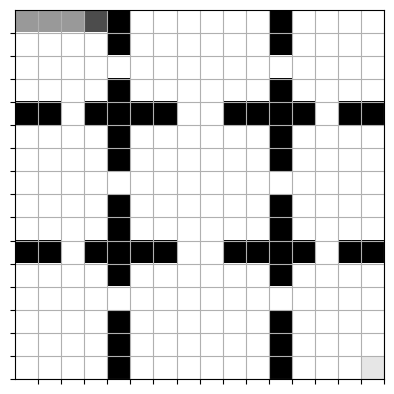

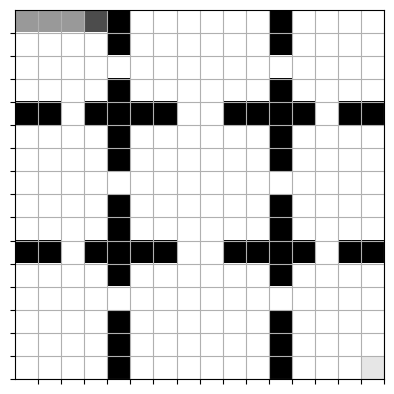

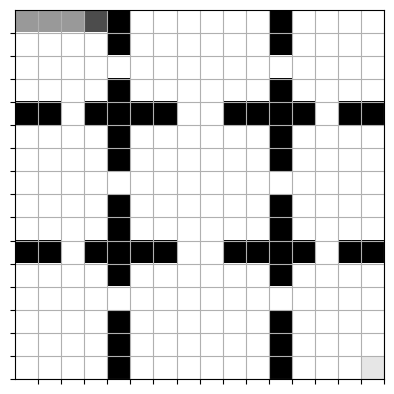

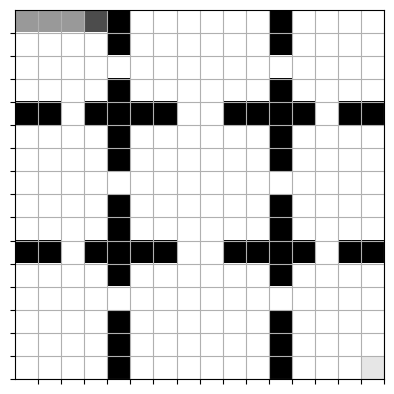

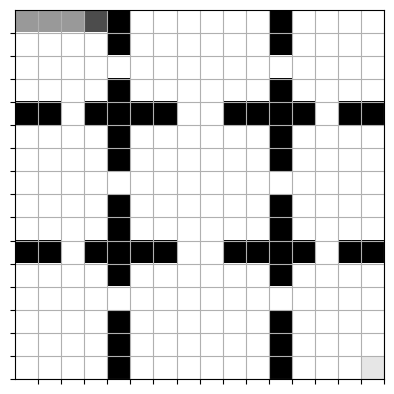

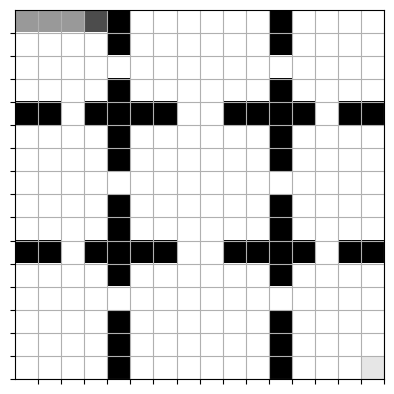

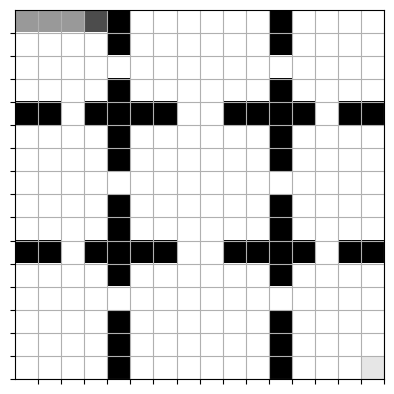

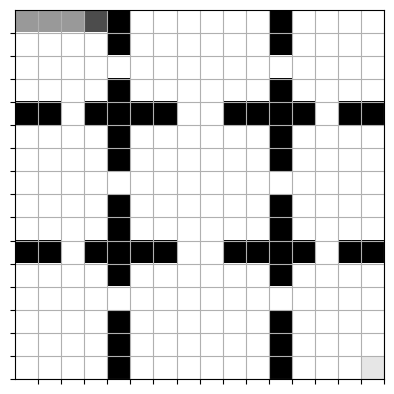

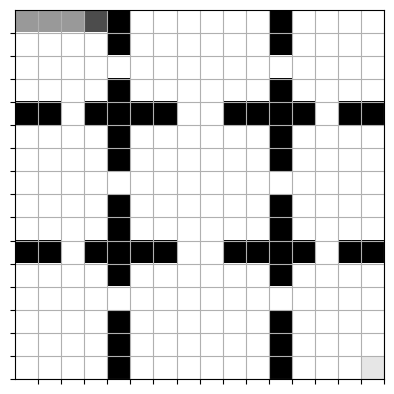

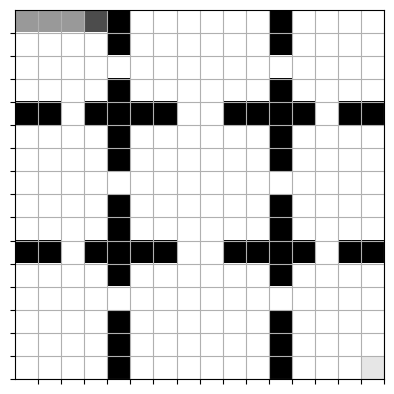

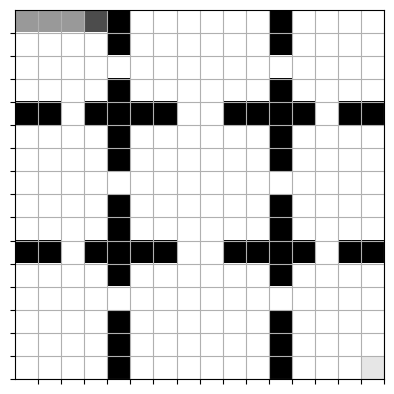

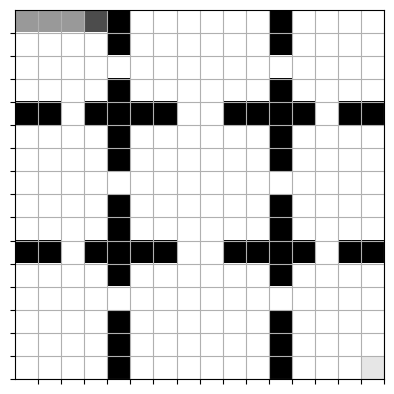

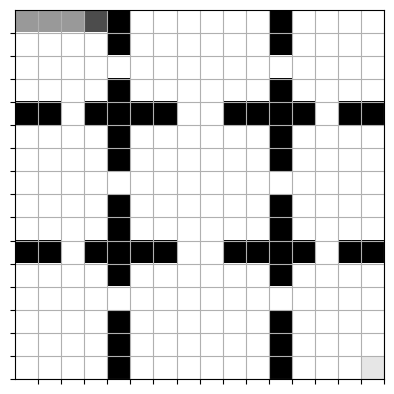

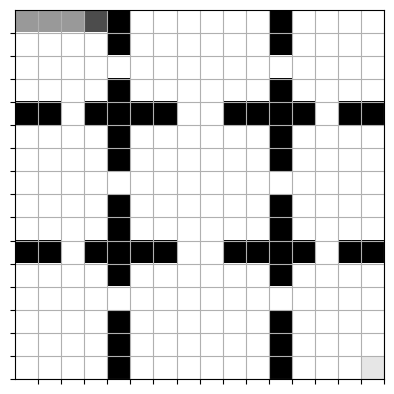

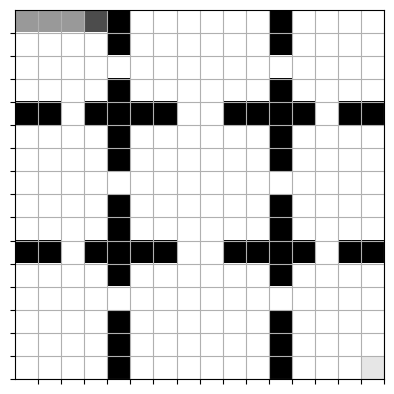

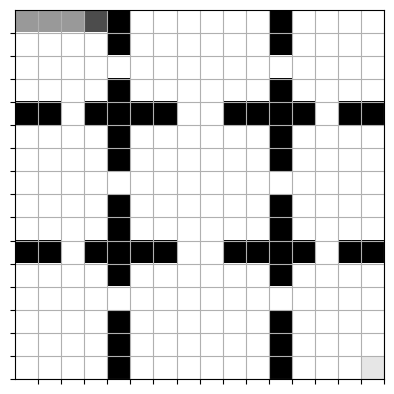

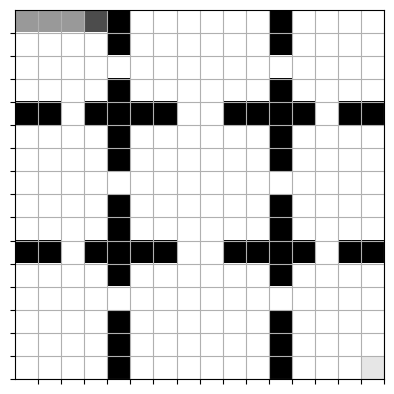

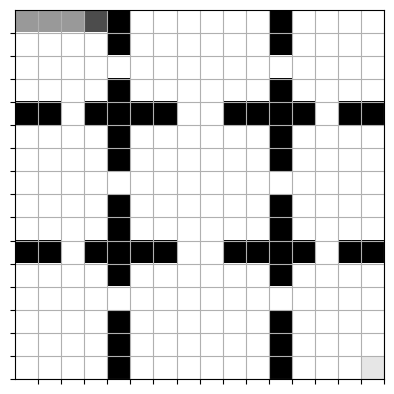

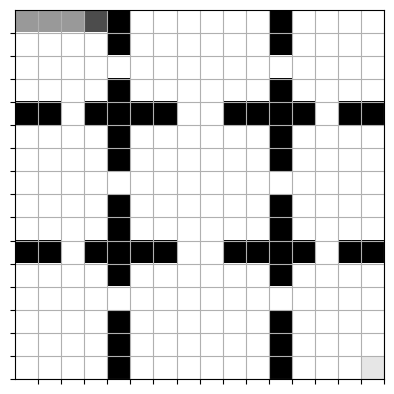

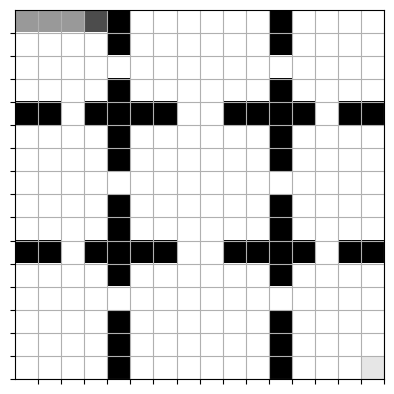

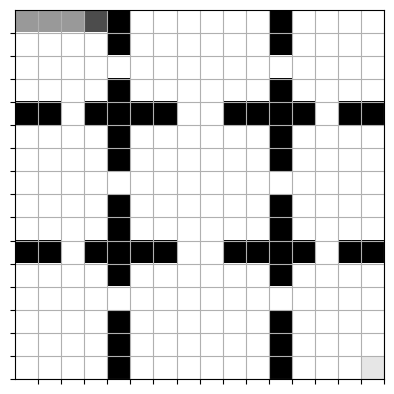

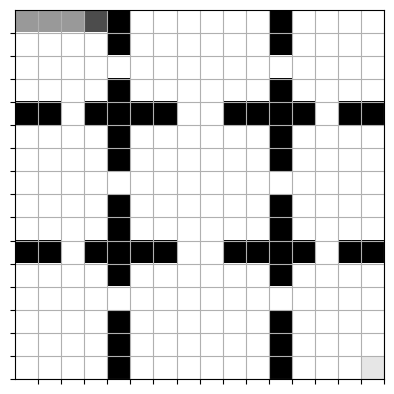

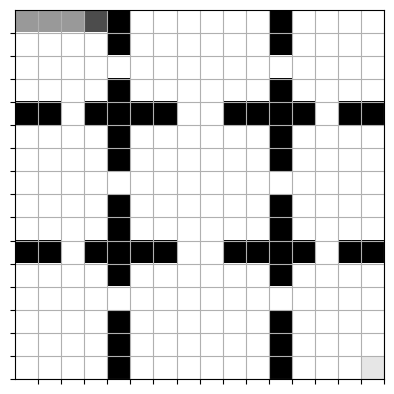

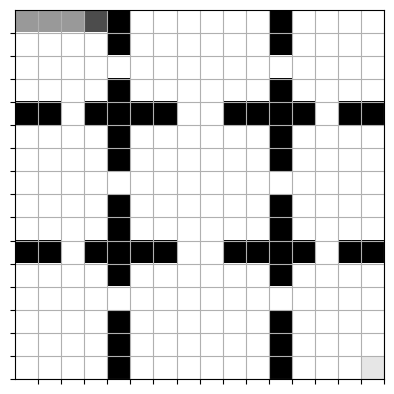

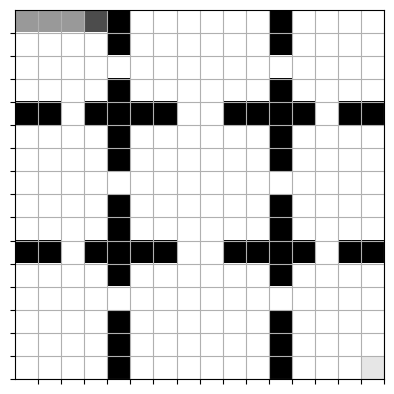

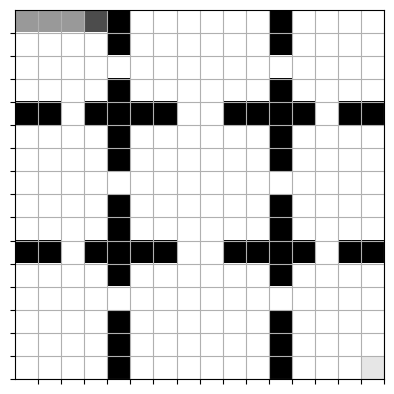

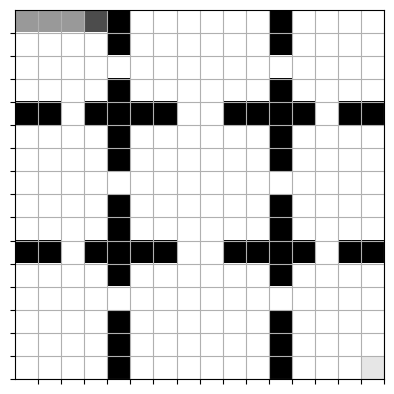

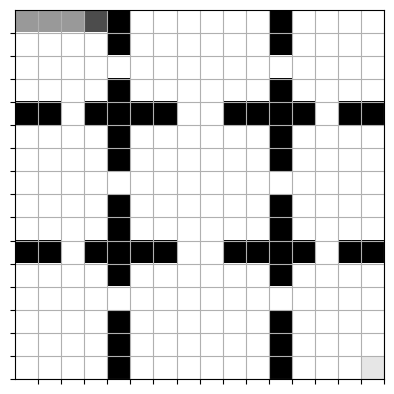

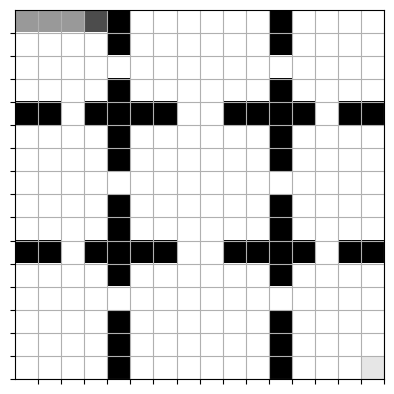

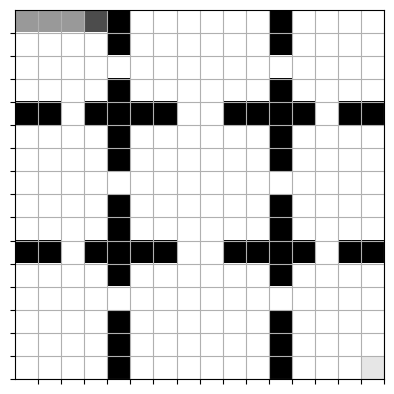

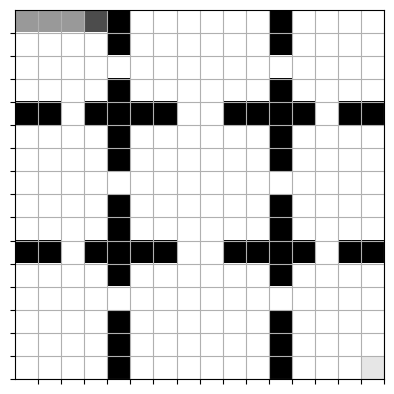

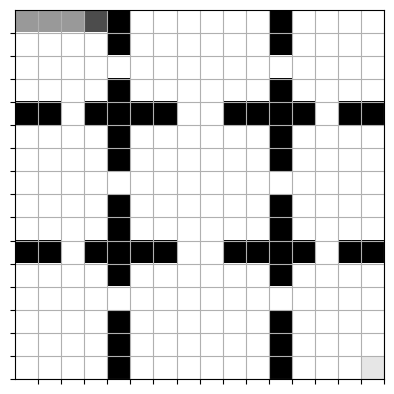

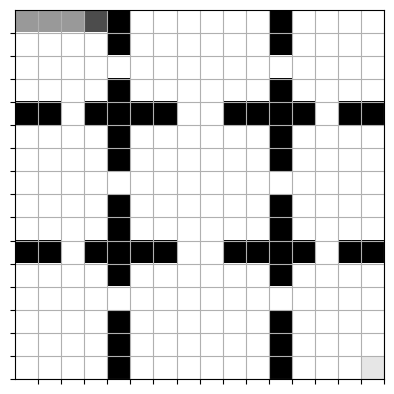

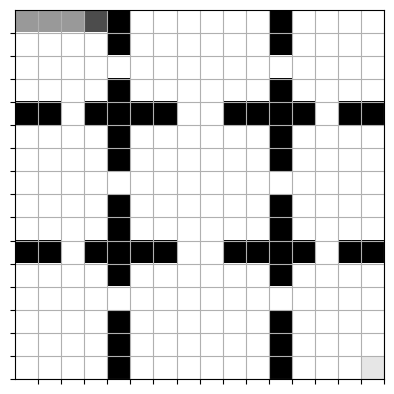

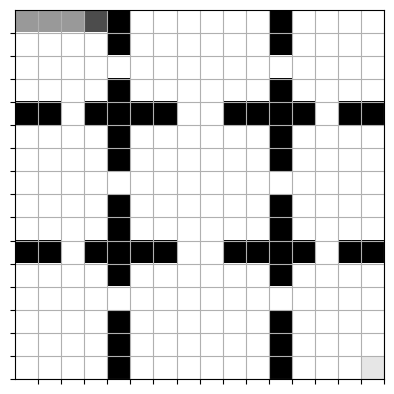

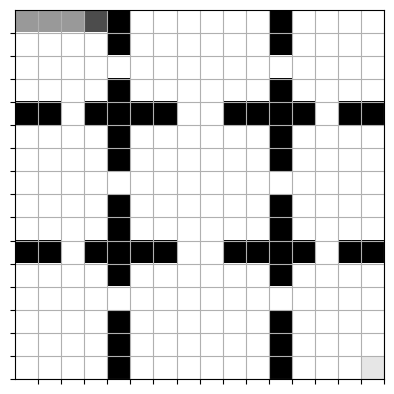

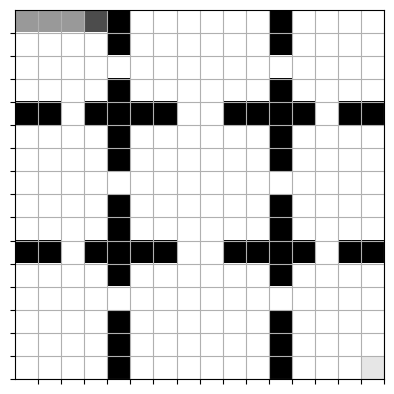

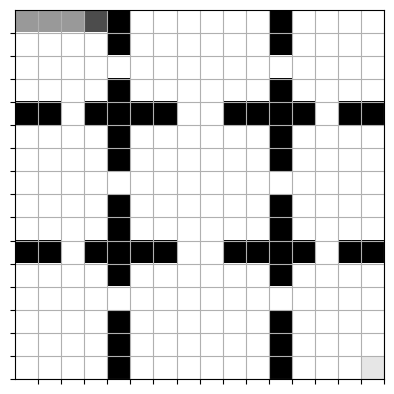

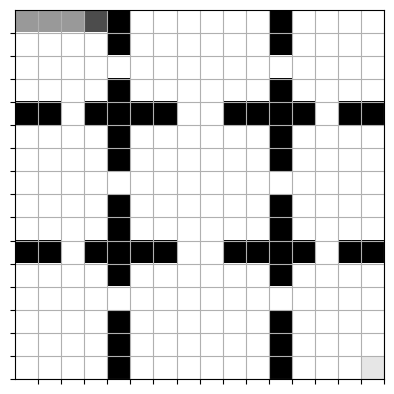

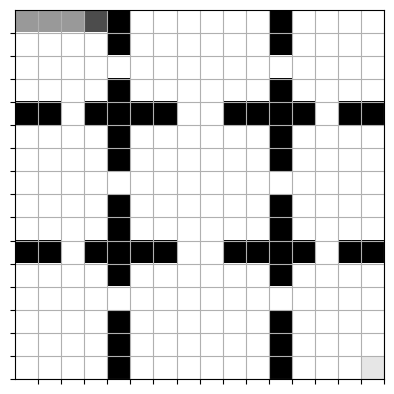

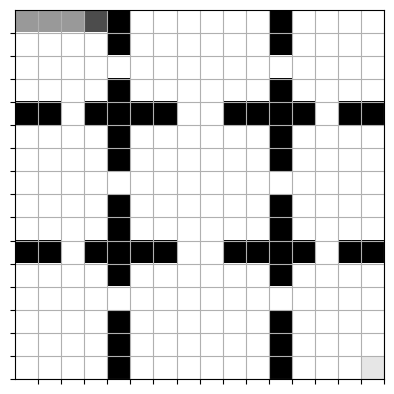

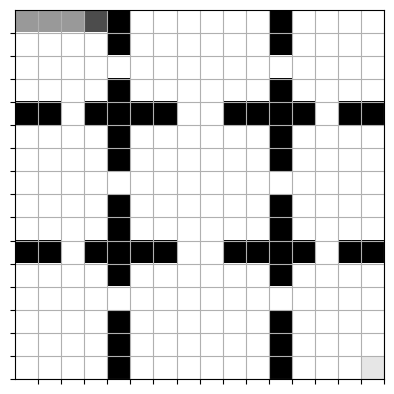

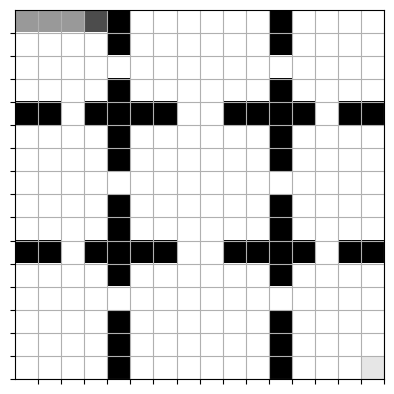

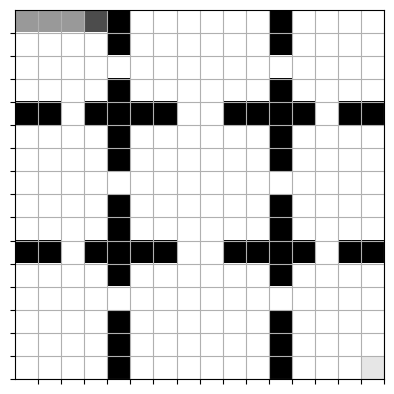

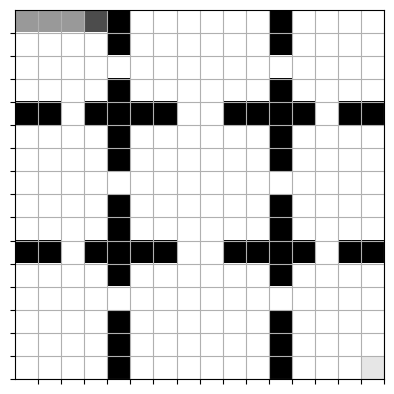

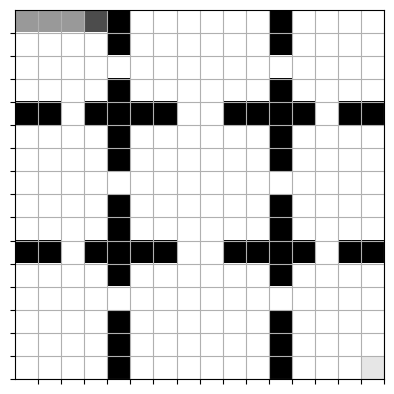

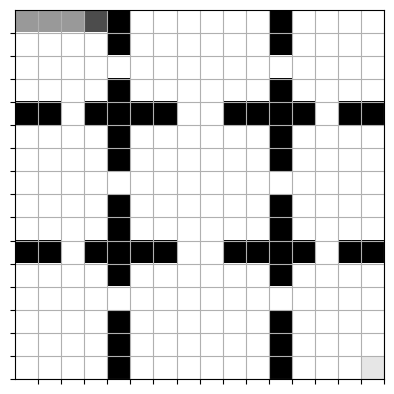

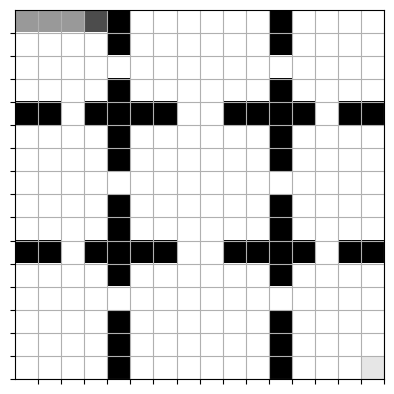

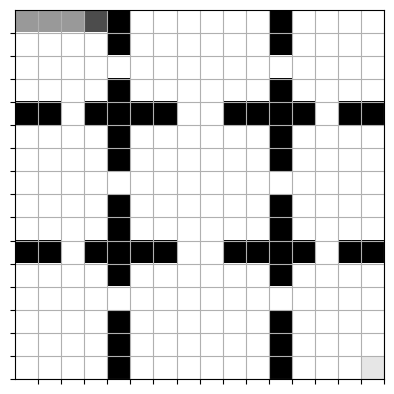

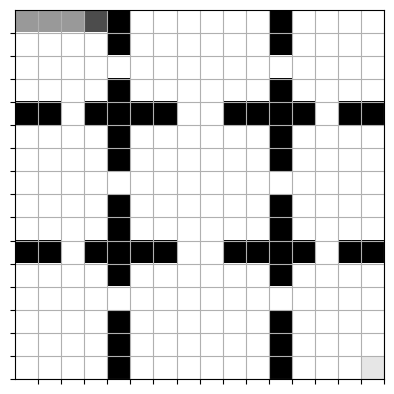

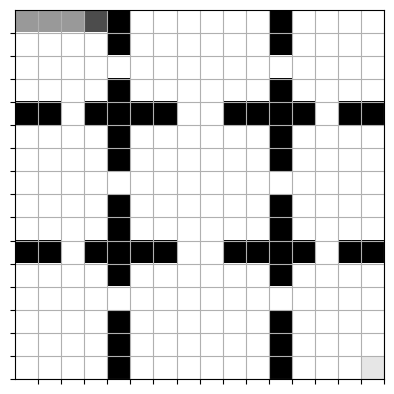

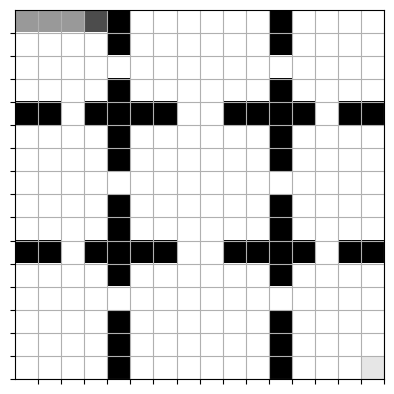

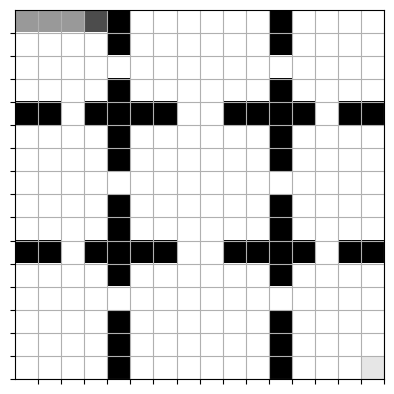

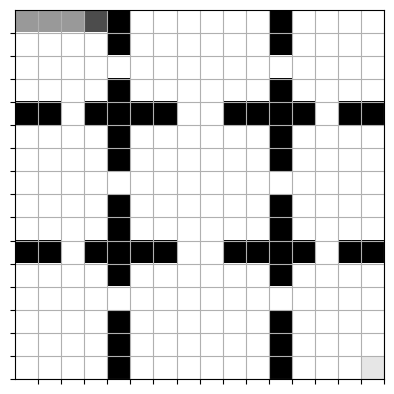

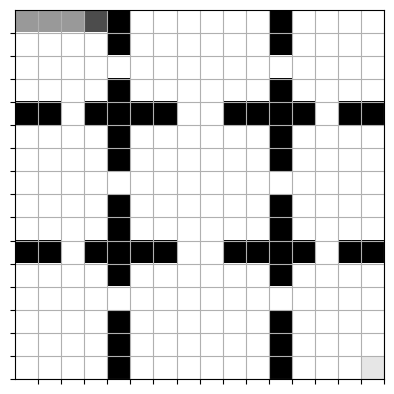

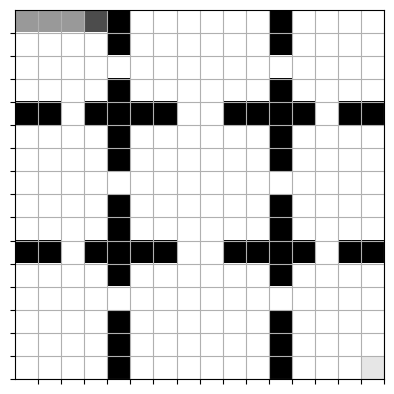

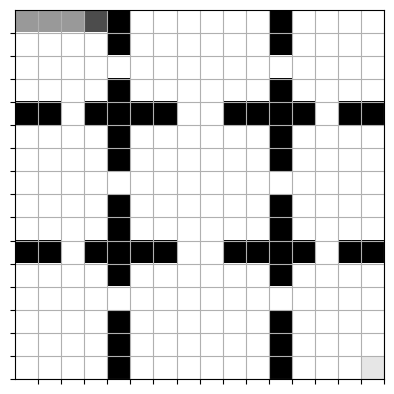

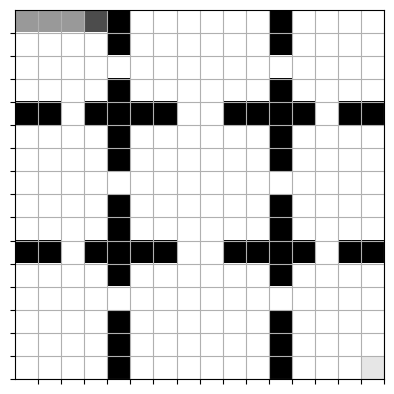

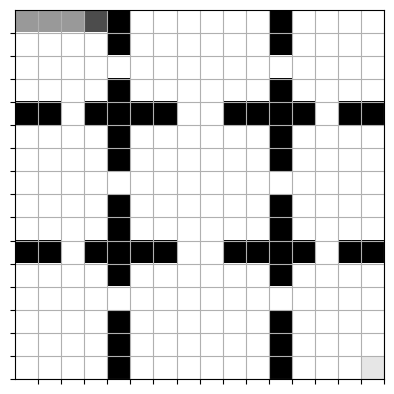

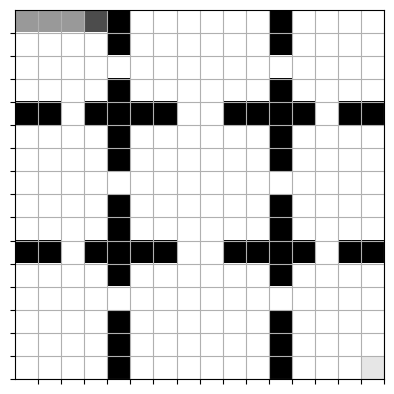

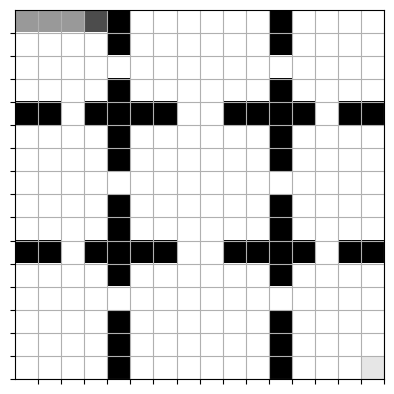

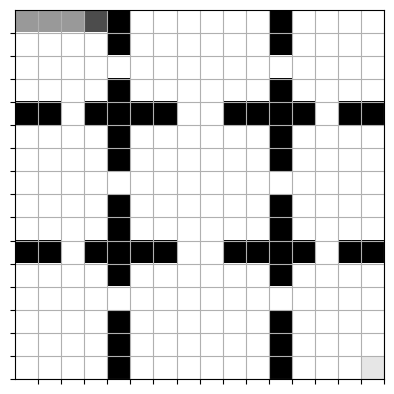

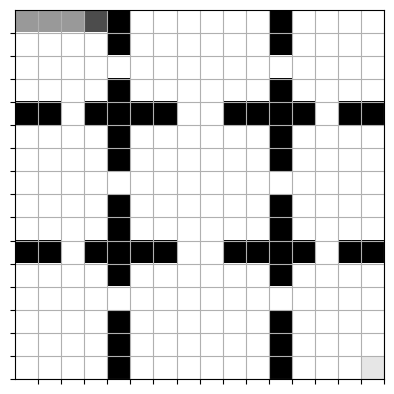

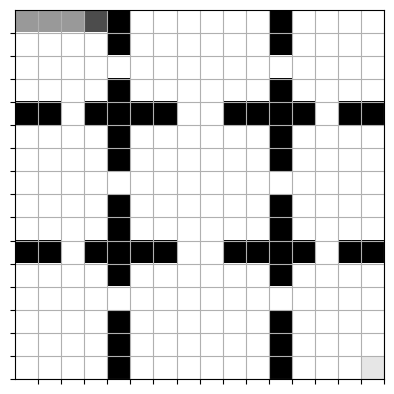

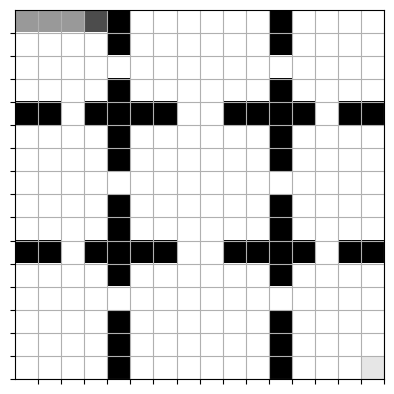

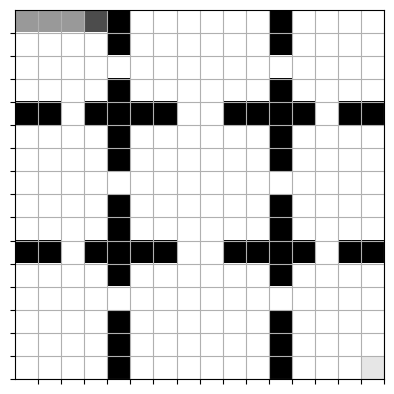

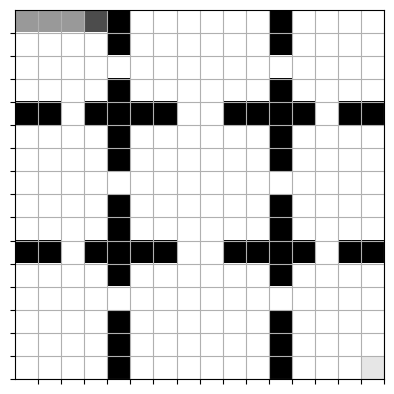

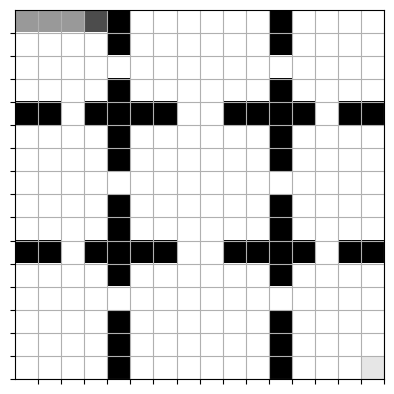

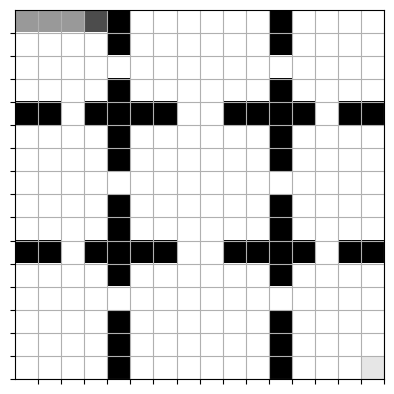

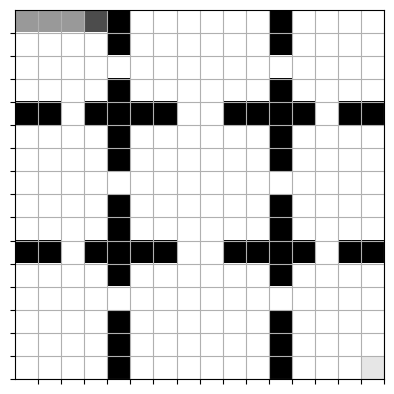

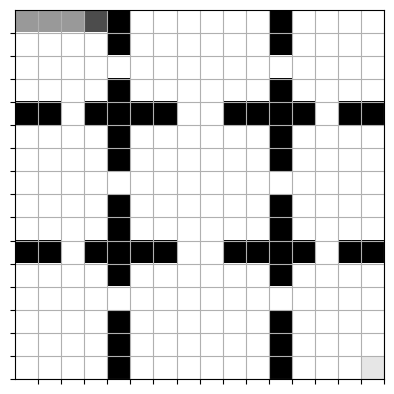

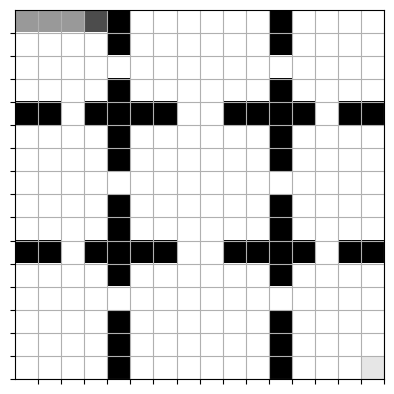

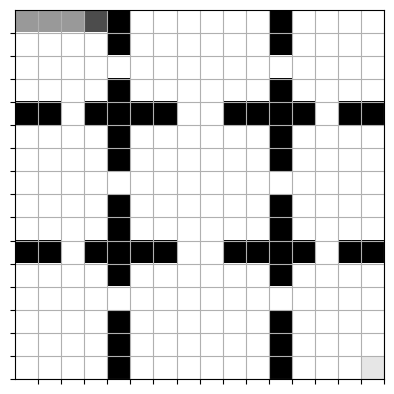

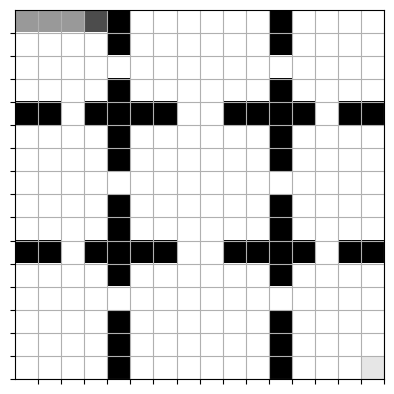

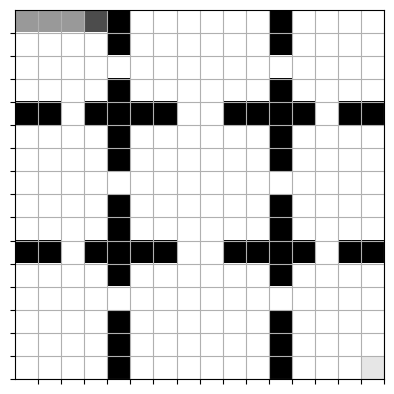

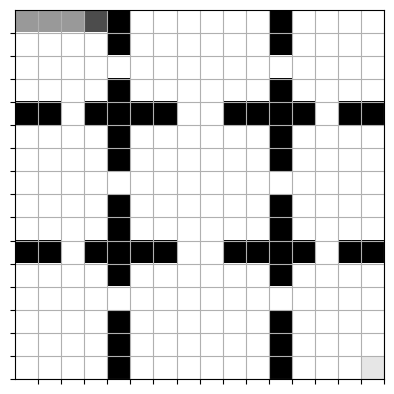

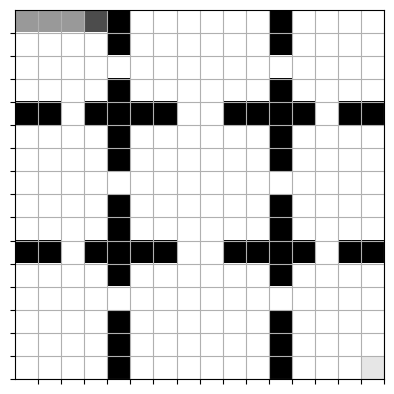

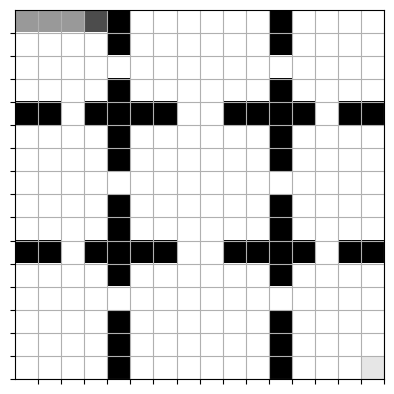

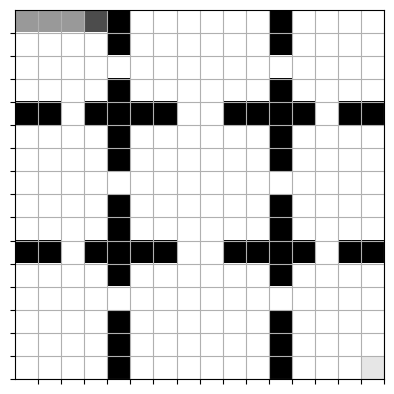

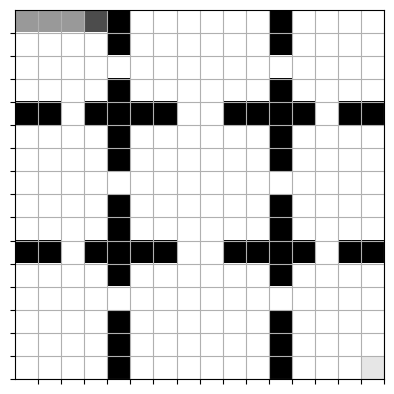

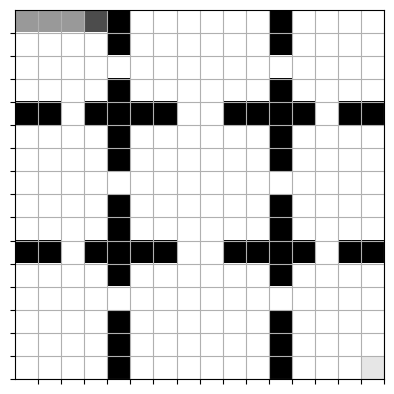

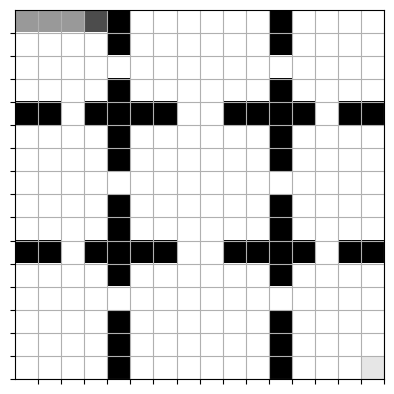

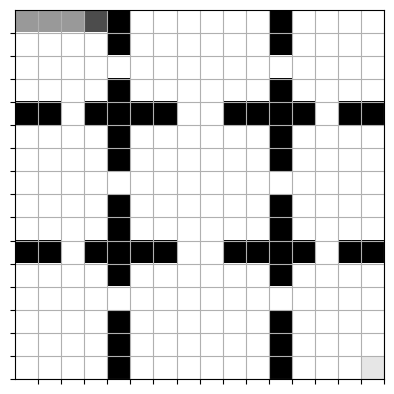

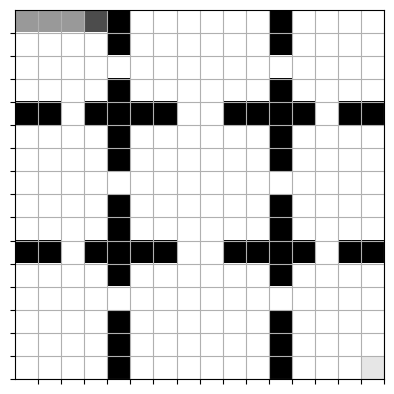

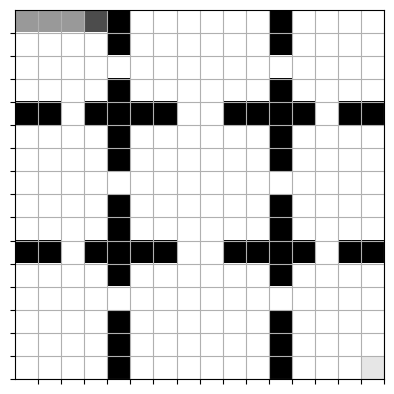

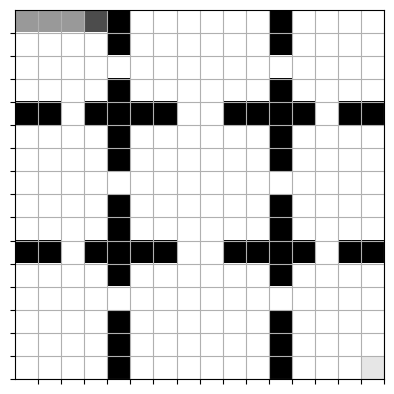

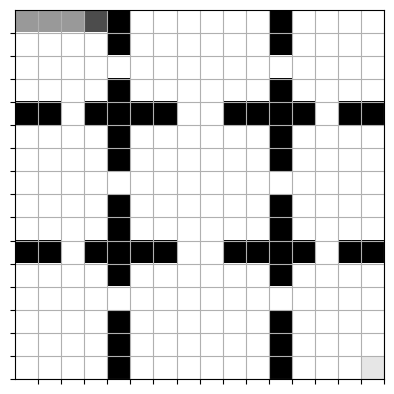

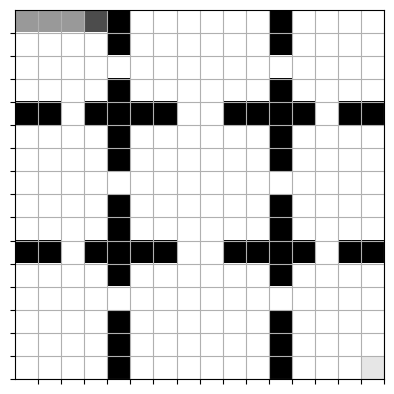

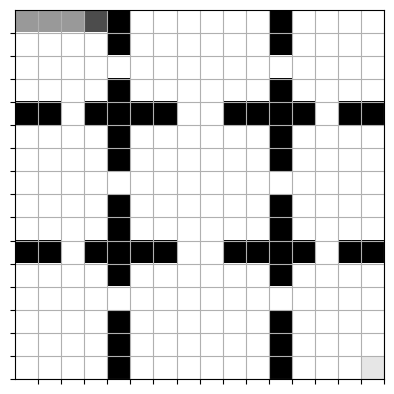

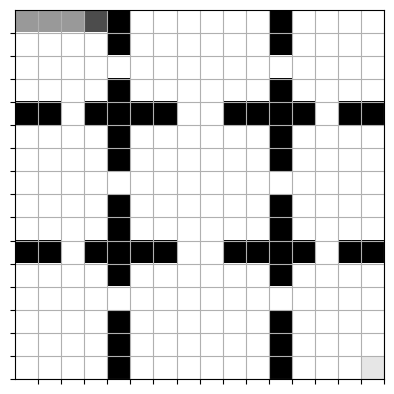

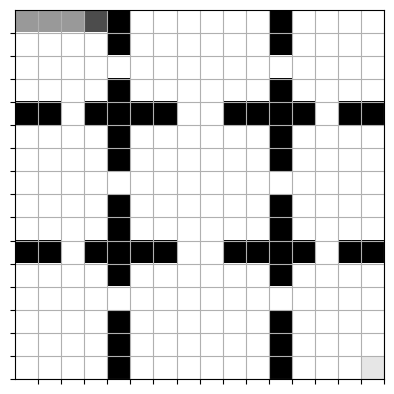

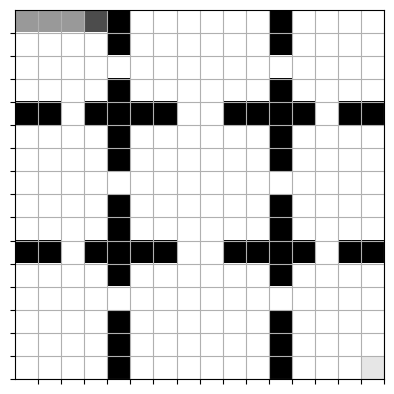

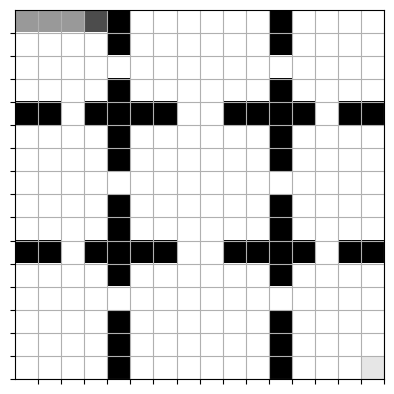

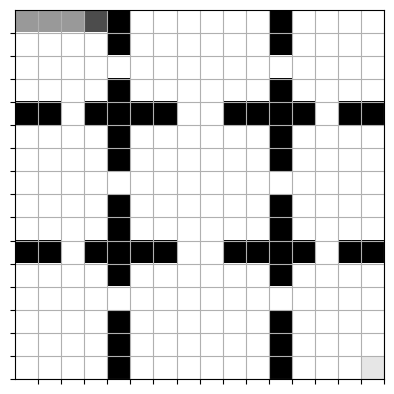

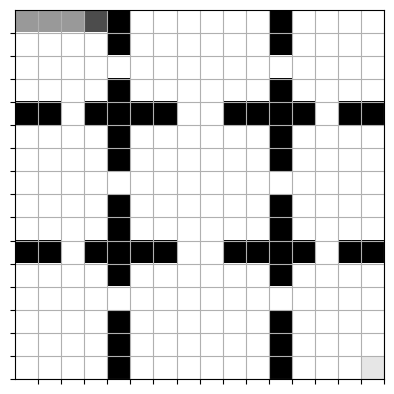

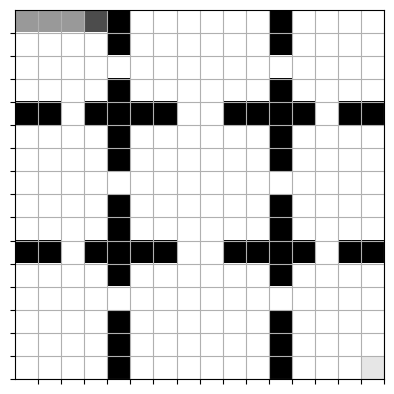

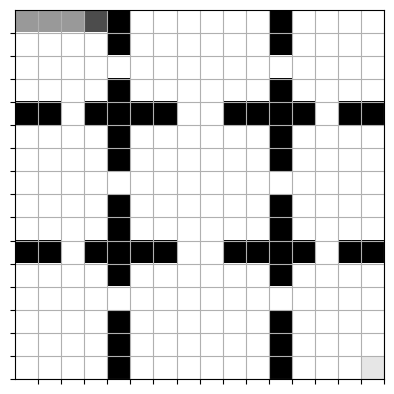

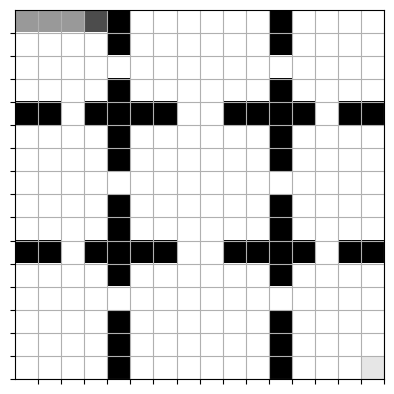

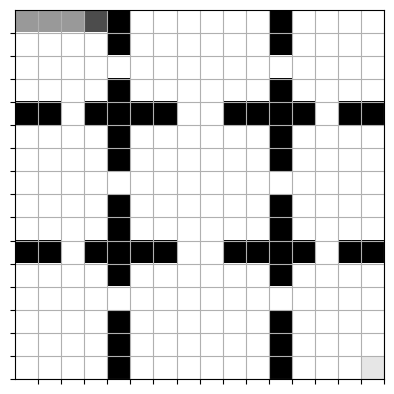

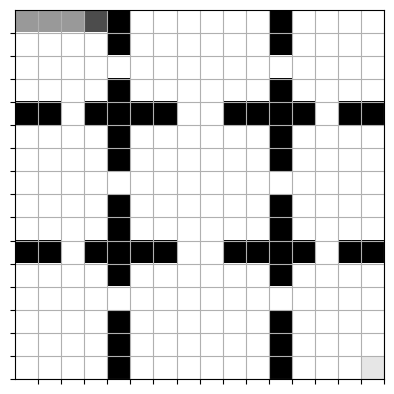

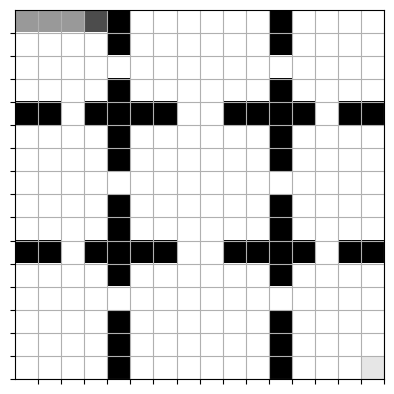

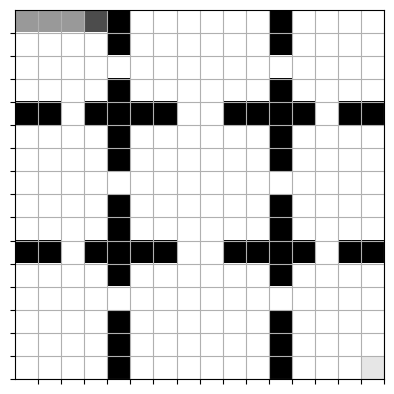

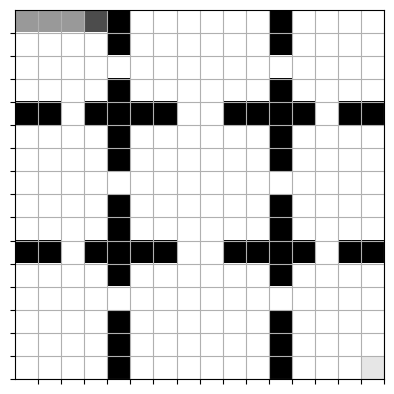

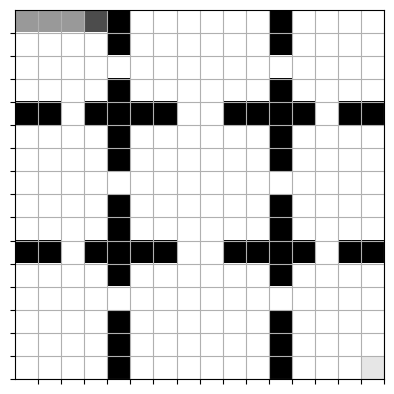

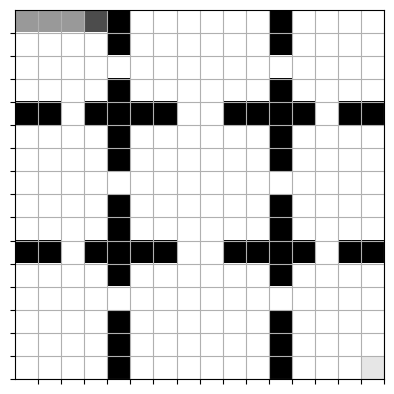

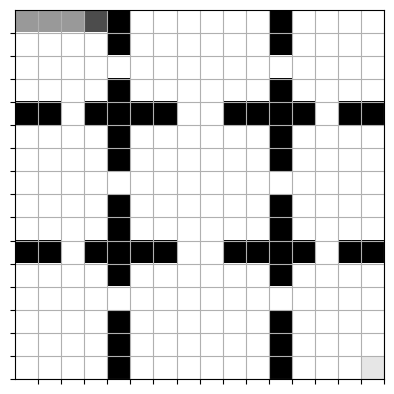

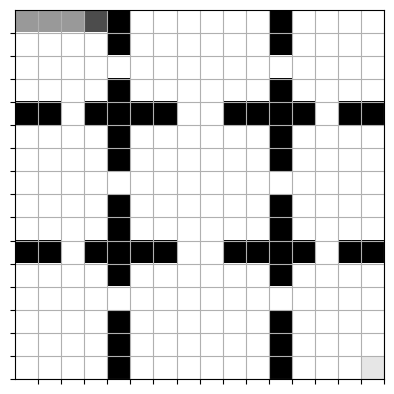

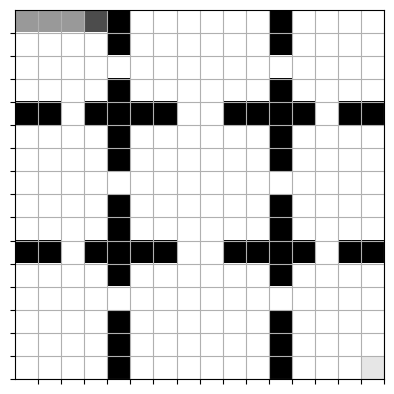

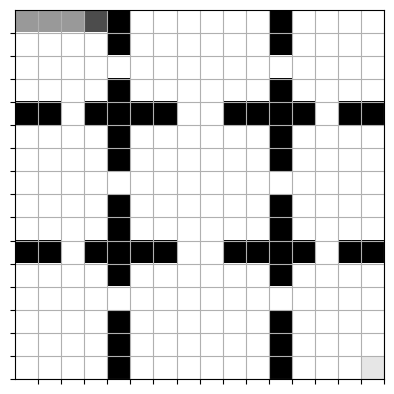

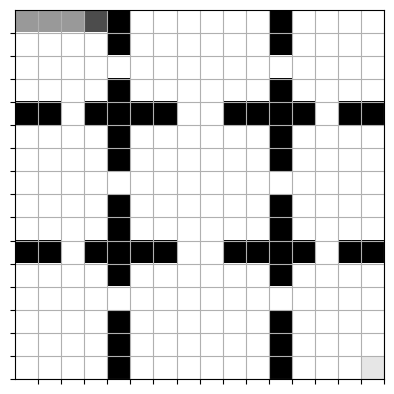

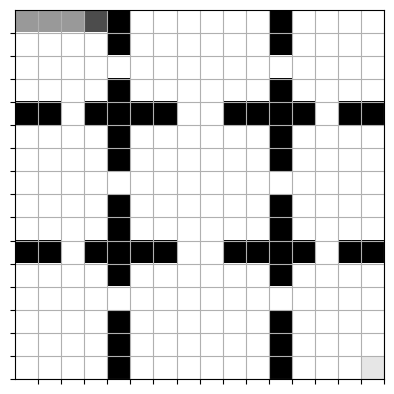

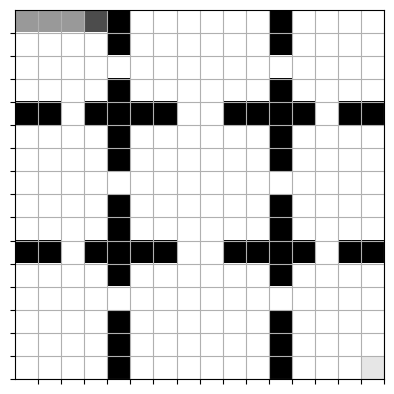

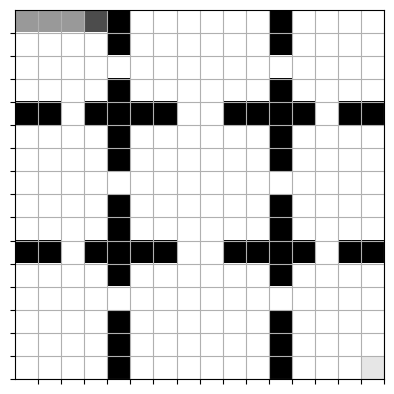

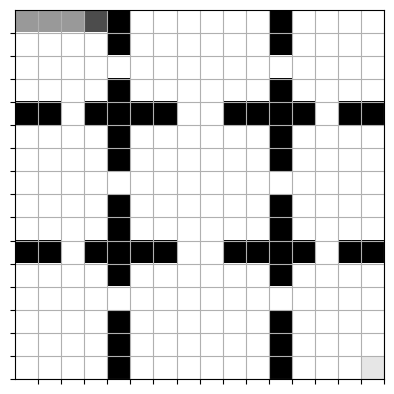

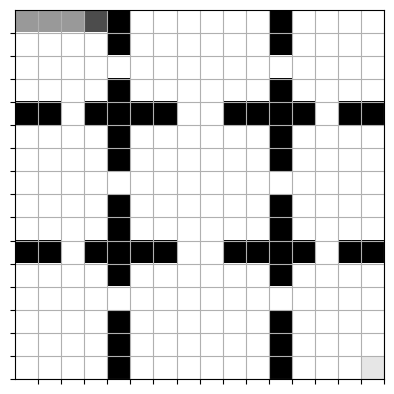

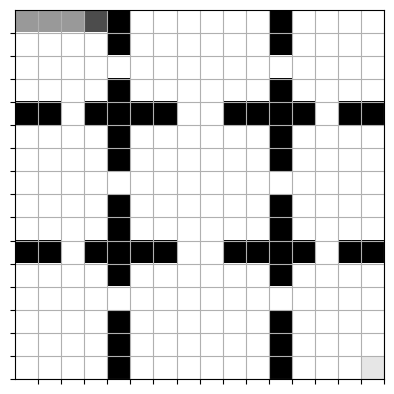

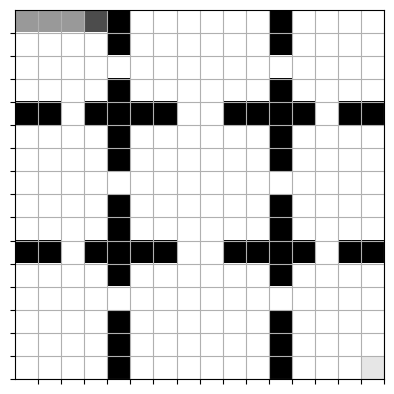

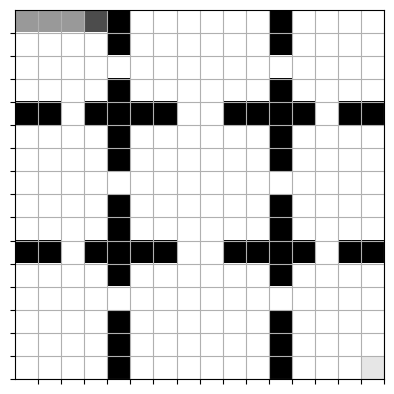

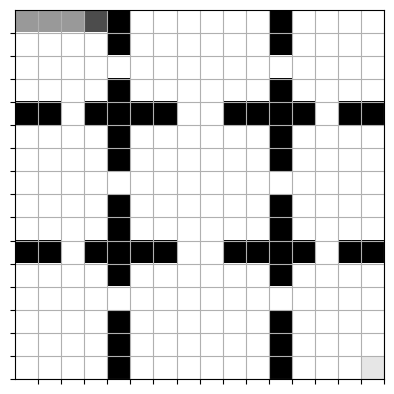

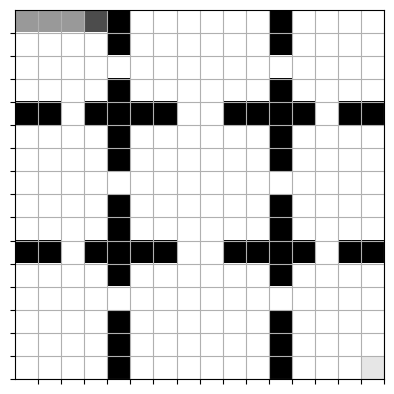

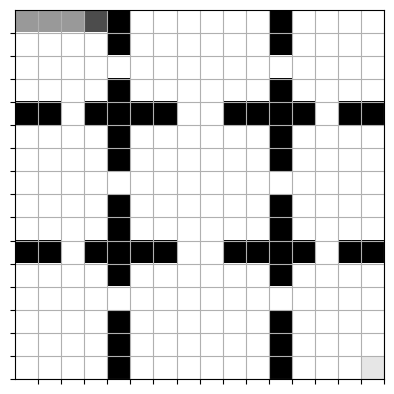

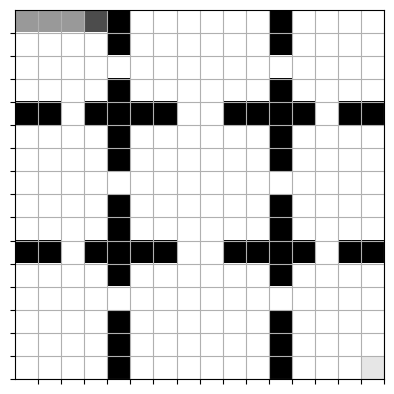

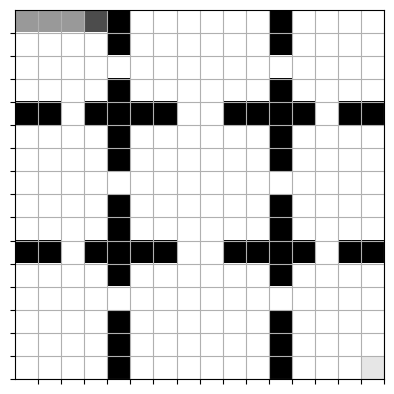

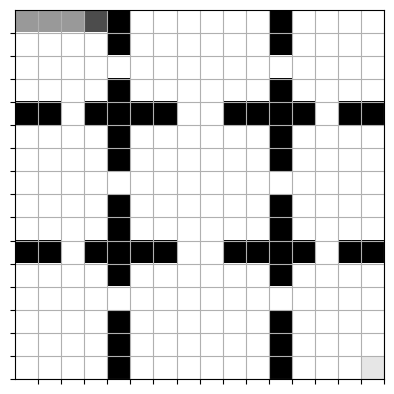

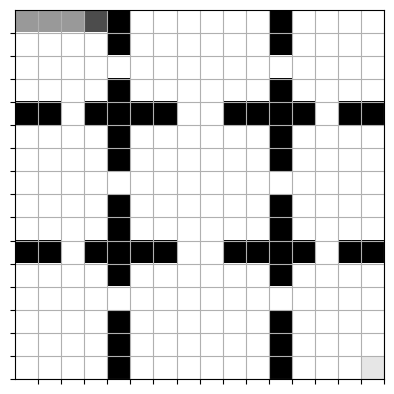

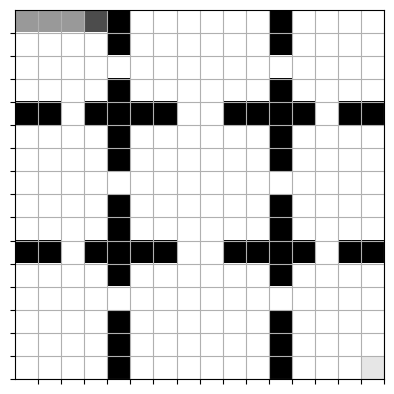

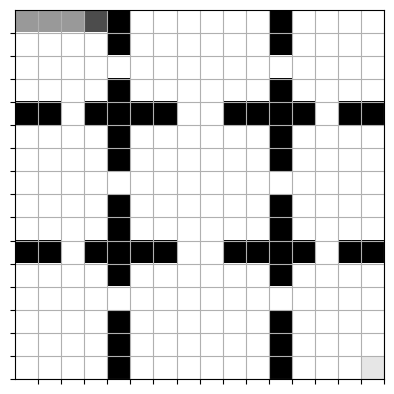

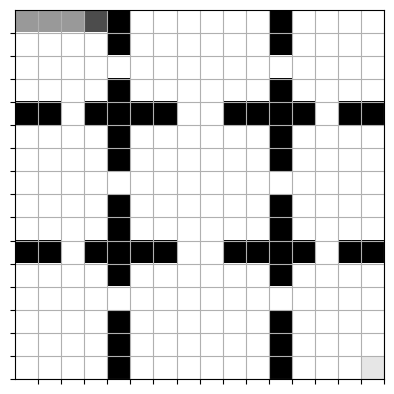

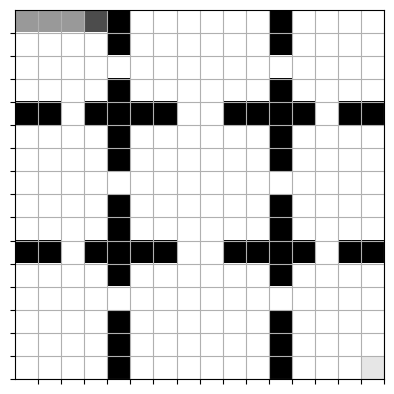

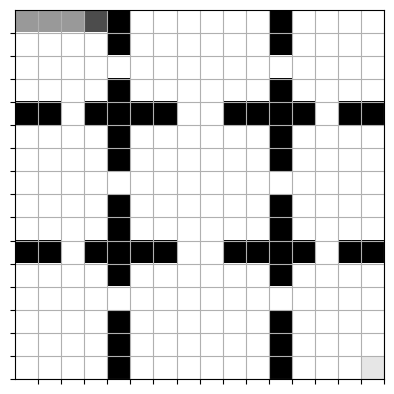

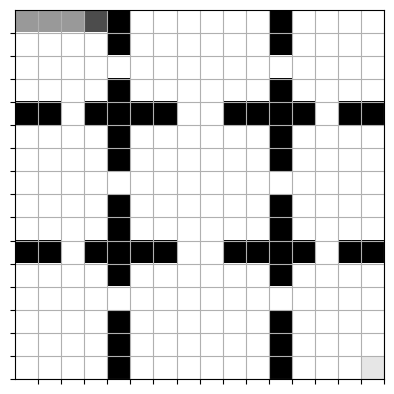

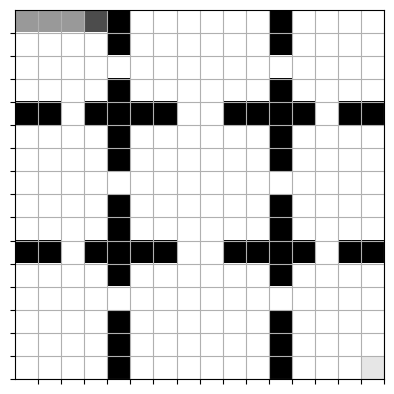

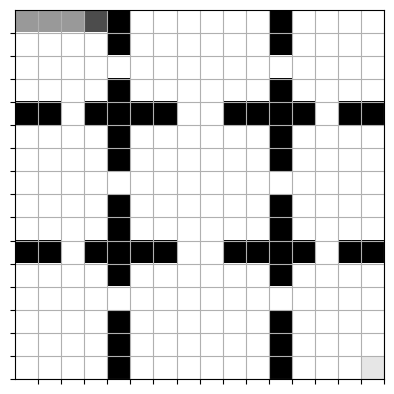

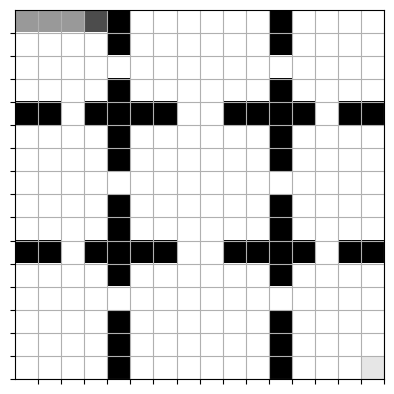

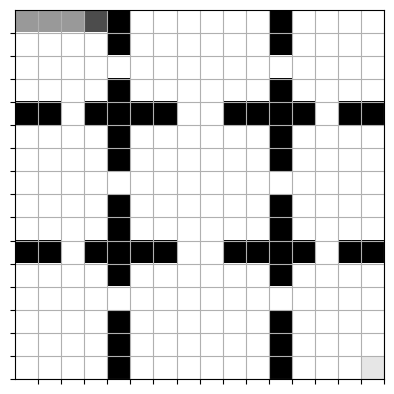

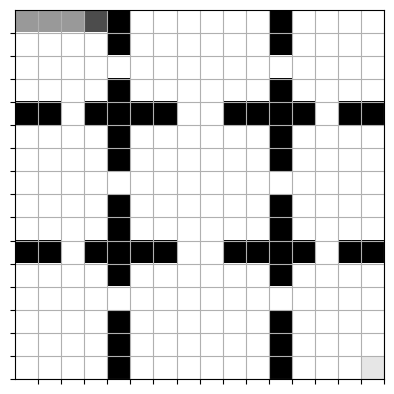

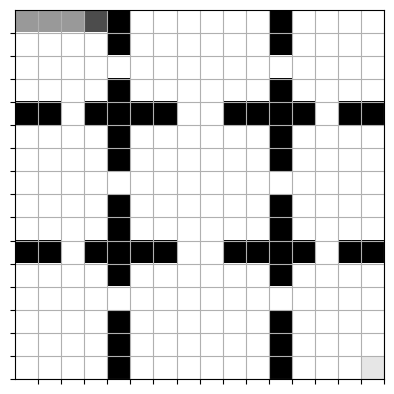

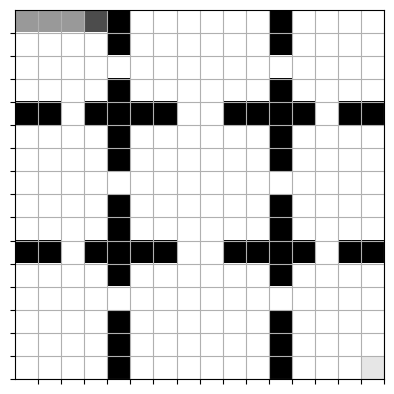

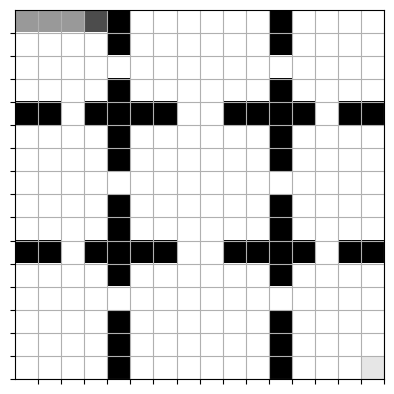

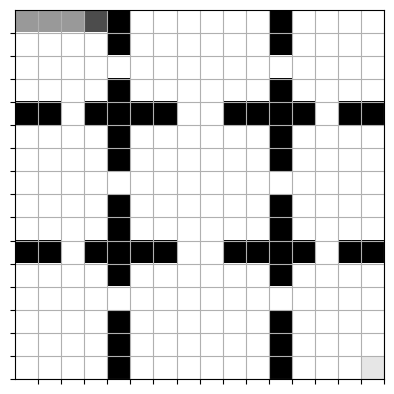

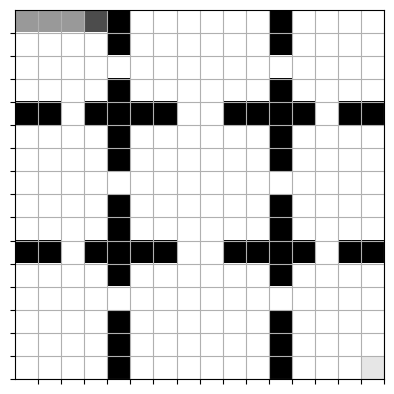

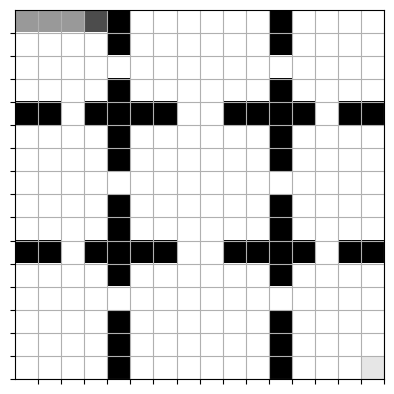

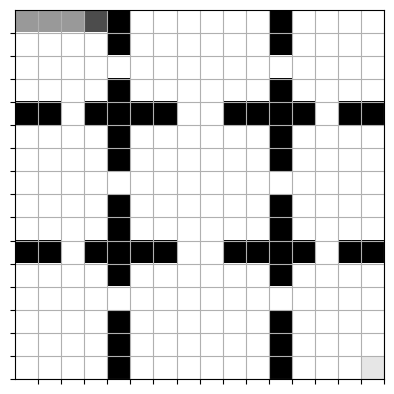

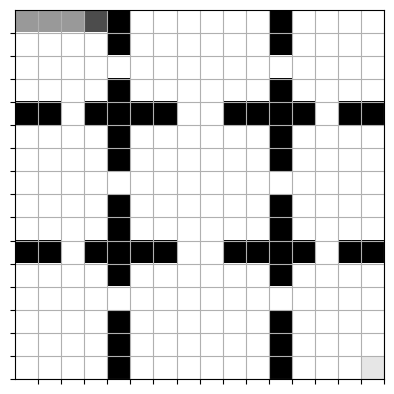

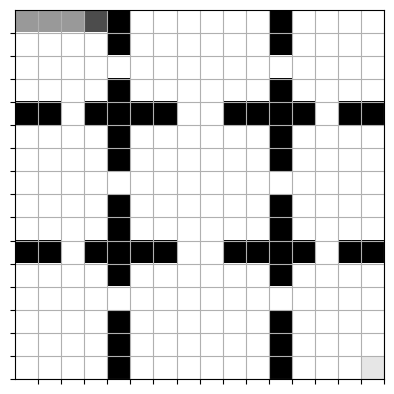

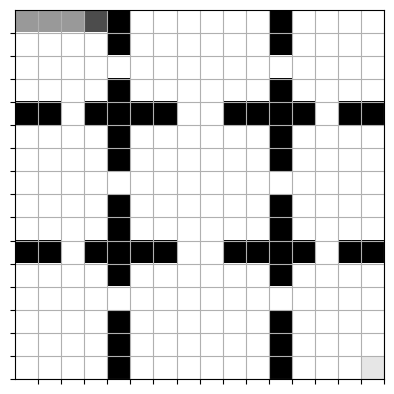

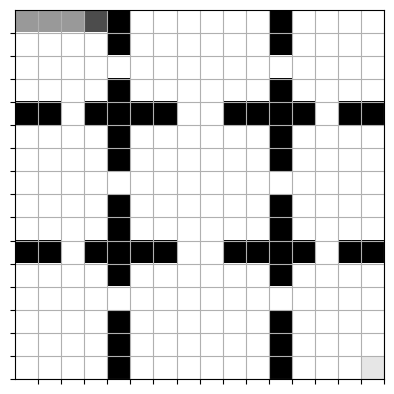

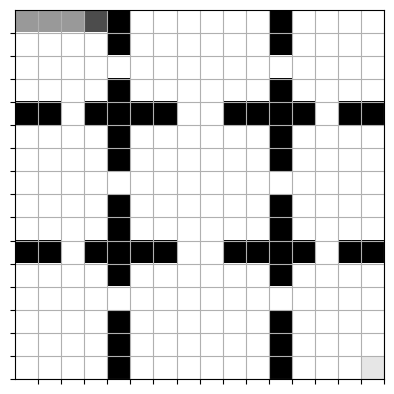

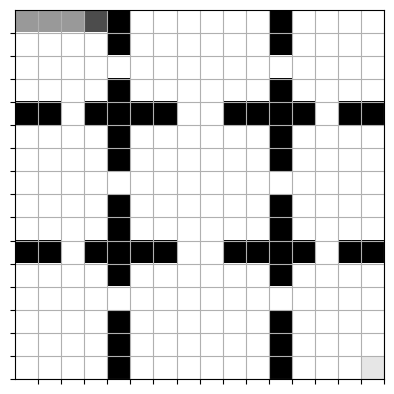

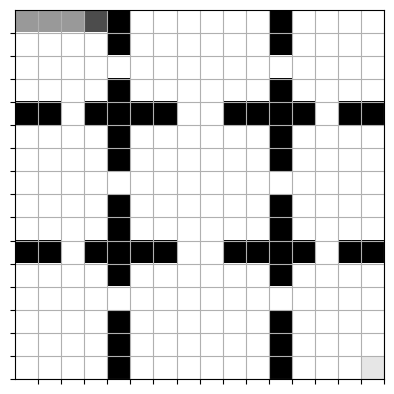

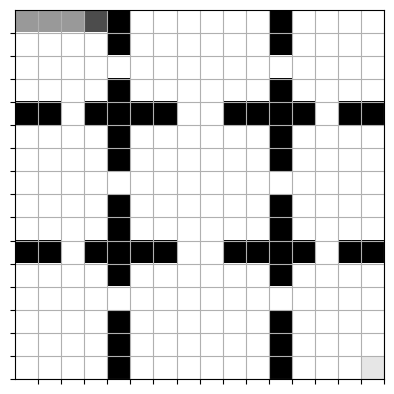

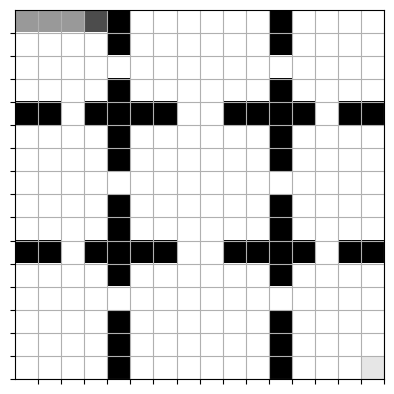

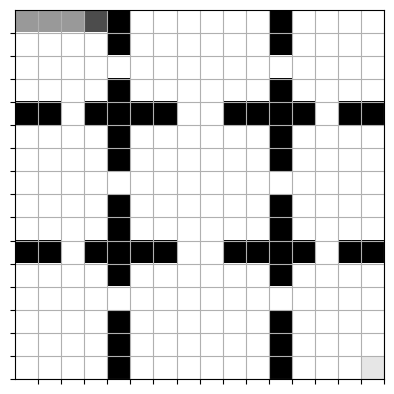

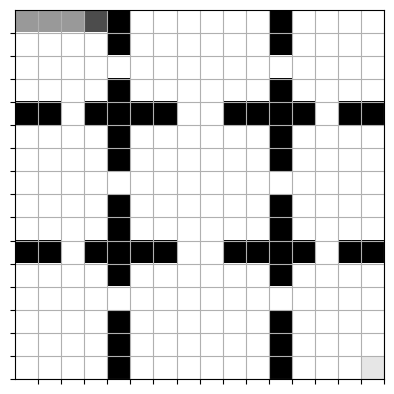

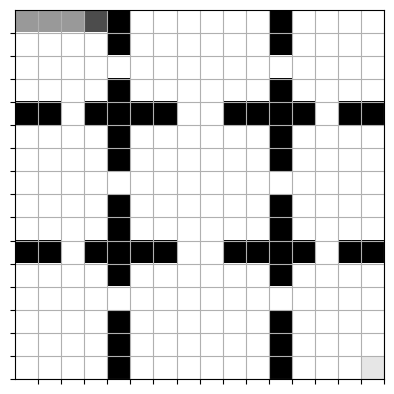

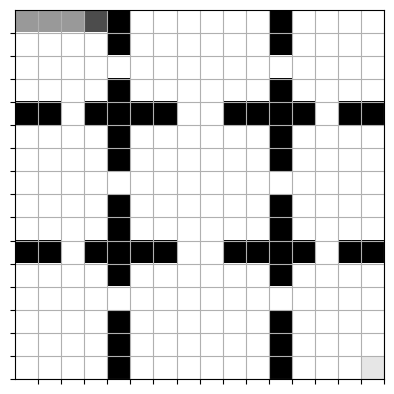

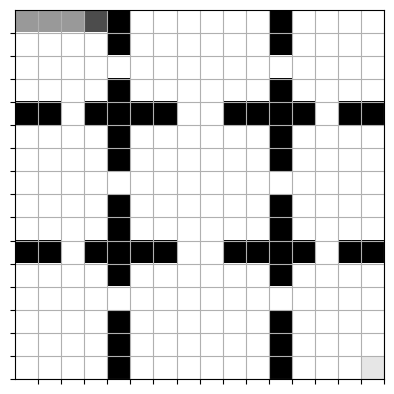

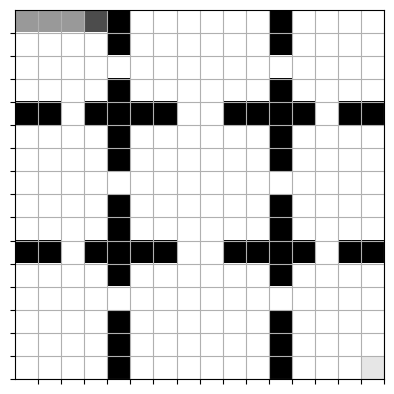

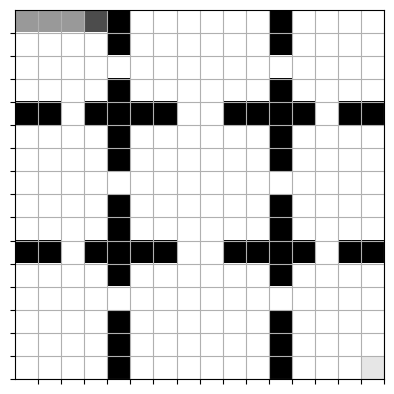

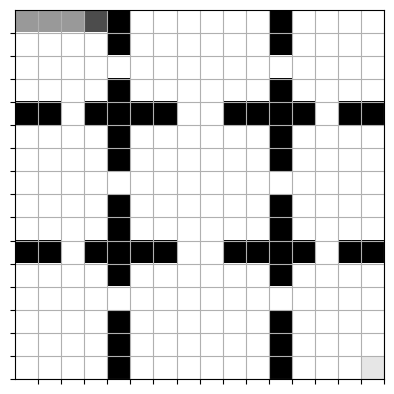

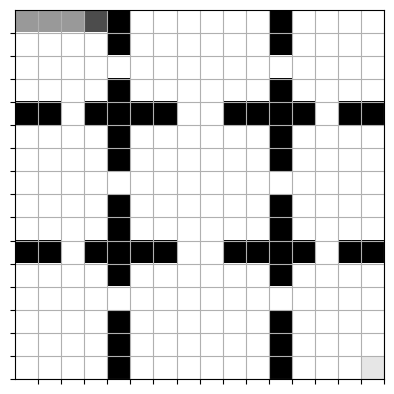

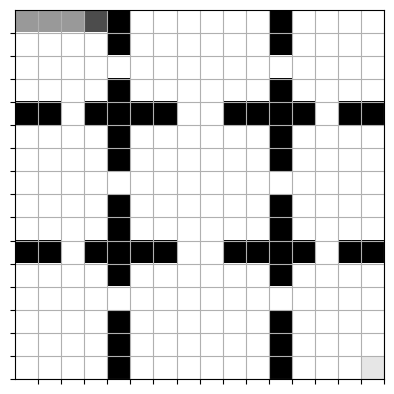

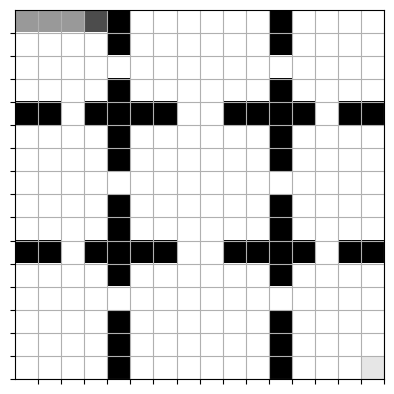

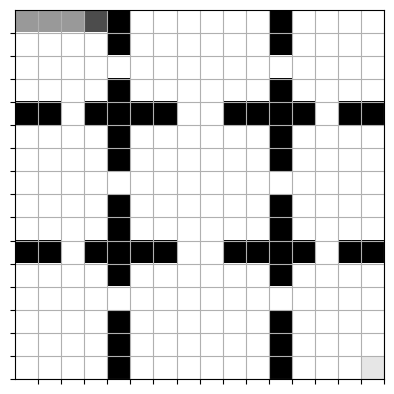

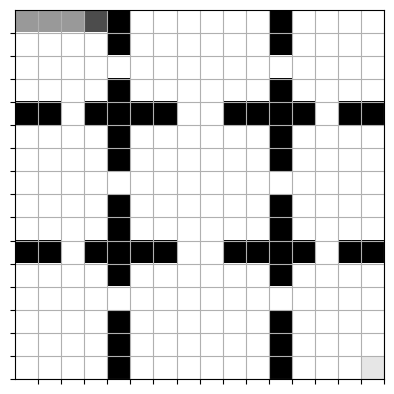

Error in callback <function flush_figures at 0x789ad08912d0> (for post_execute):


KeyboardInterrupt: ignored

In [174]:
env.reset((0, 0))
done = 'not_over'
while done == 'not_over':
    action = agent_off.choose_action(step, obs)

    new_obs, rew, done = env.act(action)

    step += 1
    obs = new_obs
    plt.figure()
    show(env)
print(step)